In [10]:
import pandas as pd
import time
import numpy as np
from tqdm import tqdm_notebook as tqdm
from numpy import dot, array
import scipy
from scipy import sparse
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from sklearn.datasets import make_classification
from sklearn.datasets import make_blobs
from sklearn.datasets import make_gaussian_quantiles

In [163]:
def dimensionality_reduction(X_data,Y_label):
    meanVector = np.mean(X_data,axis = 0)
    centeredX_data = X_data - meanVector
    sdVector = np.std(centeredX_data.astype(float),axis = 0)
    for index,value in enum(sdVector):
        if value == 0:
            sdVector[index] = 1.0             
    centeredX_data /= sdVector
    
    covX_data = np.array([centeredX_data[0,:]]).T@ np.array([centeredX_data[0,:]])
    for i in tqdm(range(1,len(centeredX_data))):
        covX_data += np.array([centeredX_data[i,:]]).T@ np.array([centeredX_data[i,:]])
    covX_data /= len(covX_data)

    eigenValues, eigenVectors = np.linalg.eig(covX_data)
    idx = eigenValues.argsort()[::-1] 
    eigenVectors = eigenVectors[:,idx]

    neededEigenVectors = []
    for idx, val in enumerate(eigenValues):
        if (sum(eigenValues[0:idx])/sum(eigenValues))>0.9:
            neededEigenVectors = eigenVectors[:,0:idx]
            break

    reconstructX_data = centeredX_data@neededEigenVectors
    return reconsturctX_data

In [114]:
class SMCSVM:
    def __init__(self):
        self.kernel = 'rbf'
        self.C=10
        self.degree = 1
        self.sigma=1.0
        self.alphas2=None
        self.fullXmatrix=None
        self.IntermXmatrix=None
        self.train_X_data = None
        self.num_classes = None
    
    def fit(self, X_data, Y_label,C=10,kernel='rbf',degree=1,sigma=1.0):
        self.kernel = kernel
        self.C= C
        self.degree = degree
        self.sigma= sigma 
        self.train_X_data = X_data
        X = X_data
        trainLabelVector = Y_label
        #fullXmatrix =[]
        num_classes = len(np.unique(Y_label))
        self.num_classes = num_classes
        #print(trainLabelVector.shape)

        fullXmatrix = np.zeros(((X_data.shape[0]*(num_classes-1)),num_classes*((X_data.shape[1])+1)))

        #for i in tqdm(range(0,(X_data.shape[0]*(num_class-1)))):

        count5 = 0
        print('\n Calculating fullXmatrix')
        for i in tqdm(range(0,X.shape[0])):
            for p in range(0,num_classes):
                if(trainLabelVector[i]!=p):   
                    for j in range(0,num_classes):
                        if(j==trainLabelVector[i]):
                            fullXmatrix[count5,(j*(X_data.shape[1]+1)):((j+1)*(X_data.shape[1]+1))-1] = X[i,:]
                            fullXmatrix[count5,((j+1)*(X_data.shape[1]+1))-1] = 1.0
                        elif(j==p):
                            fullXmatrix[count5,(j*(X_data.shape[1]+1)):((j+1)*(X_data.shape[1]+1))-1] = -1*X[i,:]
                            fullXmatrix[count5,((j+1)*(X_data.shape[1]+1))-1] = -1.0
                    count5 += 1
                    #print(count5)
        #print(fullXmatrix.shape)
        m = fullXmatrix.shape[0]
        M1 = sparse.csr_matrix(fullXmatrix) 
        IntermXmatrix = np.zeros(((X_data.shape[0]*(num_classes-1)),num_classes))
        #if(kernel=='polynomial'):   
        #    H = sparse.csr_matrix.dot(M1,M1.T) 
        #    H = (1+H.todense())**degree   
            #H,IntermXmatrix = self.getKernelizedProduct(X_data,Y_label,kernel,sigma)
        if(kernel=='linear'):
            H = sparse.csr_matrix.dot(M1,M1.T)
        else:
            H,IntermXmatrix = self.getKernelizedProduct(X_data,Y_label,kernel,sigma,degree)        

        from cvxopt import matrix as cvxopt_matrix
        from cvxopt import solvers as cvxopt_solvers
        if(kernel=='linear'):
            P = cvxopt_matrix(H.todense())
        else:
            P = cvxopt_matrix(H)
        q = cvxopt_matrix(-1*np.ones((m, 1)))
        G = cvxopt_matrix(np.vstack((np.eye(m)*-1,np.eye(m))))
        h = cvxopt_matrix(np.hstack((np.zeros(m), np.ones(m) * C)))
        opts = {'maxiters' : 30,'solver':'mosek'}
        sol = cvxopt_solvers.qp(P, q, G, h ,options = opts)
        alphas2 = np.array(sol['x']) 
        #w = fullXmatrix.T@alphas2
        #wForEachLabel = {}
        #for i in range(0,num_classes):
            #wForEachLabel[i] = np.array_split(w,num_classes)[i]
        self.alphas2=alphas2
        self.fullXmatrix=fullXmatrix
        self.IntermXmatrix=IntermXmatrix
        
        #return alphas2,fullXmatrix,IntermXmatrix
    def predict(self,val_X_data):
    #def predict(train_X_data,val_X_data,IntermXmatrix,num_classes,alphas2,fullXmatrix,kernel,degree,sigma):
        num_classes = self.num_classes
        train_X_data = self.train_X_data
        kernel = self.kernel
        degree = self.degree
        sigma = self.sigma
        alphas2=self.alphas2
        fullXmatrix=self.fullXmatrix
        IntermXmatrix=self.IntermXmatrix

        predictedLabelVector = []
        if(kernel == 'linear'):
            w = fullXmatrix.T@alphas2
            wForEachLabel = {}
            for i in range(0,num_classes):
                wForEachLabel[i] = np.array_split(w,num_classes)[i]
            print('\n Calculating prediction values')
            for i in tqdm(range(0,val_X_data.shape[0])):
                scoresForEachLabel = []
                for j in range(0,len(wForEachLabel)):
                    score = (wForEachLabel[j].T@np.append(val_X_data[i,:],1.0).reshape(-1,1))
                    scoresForEachLabel.append(score)
                maxScoreLabel = np.argmax(scoresForEachLabel)
                predictedLabelVector.append(maxScoreLabel)
        elif(kernel == 'polynomial'):
            print('\n Calculating prediction values')
            for i in tqdm(range(0,val_X_data.shape[0])):
                #tempMatrix1 = np.zeros((num_classes*(val_X_data.shape[1]+1),num_classes))
                #for j in range(0,num_classes):
                #    tempMatrix1[j*(val_X_data.shape[1]+1):(j+1)*(val_X_data.shape[1]+1),j] = np.append(val_X_data[i,:],1.0)
                #scoresForEachLabel = (alphas2.T)@((1+(fullXmatrix@tempMatrix1))**degree)
                scoresForEachLabel = (alphas2.T)@(self.getKernelizedProductforPrediction(train_X_data,val_X_data,IntermXmatrix,i,num_classes,kernel,sigma,degree))
                maxScoreLabel = np.argmax(scoresForEachLabel)
                predictedLabelVector.append(maxScoreLabel)
        elif(kernel == 'rbf'):
            print('\n Calculating prediction values')
            for i in tqdm(range(0,val_X_data.shape[0])):
                #tempMatrix1 = np.zeros((num_classes*(val_X_data.shape[1]+1),num_classes))
                #for j in range(0,num_classes):
                    #tempMatrix1[j*(val_X_data.shape[1]+1):(j+1)*(val_X_data.shape[1]+1),j] = np.append(val_X_data[i,:],1.0)
                scoresForEachLabel = (alphas2.T)@(self.getKernelizedProductforPrediction(train_X_data,val_X_data,IntermXmatrix,i,num_classes,kernel,sigma,degree))
                maxScoreLabel = np.argmax(scoresForEachLabel)
                predictedLabelVector.append(maxScoreLabel)
        return predictedLabelVector
    def getKernelizedProductforPrediction(self,X_data,val_X_data,IntermXmatrix,currentValIndex,num_classes,kernel,sigma,degree):
        X = X_data
        m = (X_data.shape[0]*(num_classes-1))
        H = np.zeros((m,num_classes))    
        matrix2 = (currentValIndex+1)*np.eye(num_classes)
        tempCoeff = (1/(X.shape[1]+1))
        
        if(kernel == 'polynomial'): 
            for i in (range(0,m)):
                for j in range(0,num_classes):
                    count1 = 0
                    for k in range(0,num_classes):
                        if(count1==2):
                            break
                        else:
                            temp3 = int(IntermXmatrix[i,k])
                            temp4 = int(matrix2[k,j])
                            if(temp3>0):
                                count1+=1
                                if(temp4>0):                             
                                    H[i,j] += (1+((1/tempCoeff)*np.dot(np.append(X[temp3-1,:],1.0),np.append(val_X_data[temp4-1,:],1.0))))**degree
                            elif(temp3<0):
                                count1+=1
                                if(temp4>0):
                                    H[i,j] += (1+((1/tempCoeff)*np.dot(np.append(val_X_data[temp4-1,:],1.0),np.append(-1*X[-temp3-1,:],-1.0))))**degree
        

        elif(kernel == 'rbf'): 
            for i in (range(0,m)):
                for j in range(0,num_classes):
                    count1 = 0
                    for k in range(0,num_classes):
                        if(count1==2):
                            break
                        else:
                            temp3 = int(IntermXmatrix[i,k])
                            temp4 = int(matrix2[k,j])
                            if(temp3>0):
                                count1+=1
                                if(temp4>0):                             
                                    H[i,j] += np.exp(-1*(np.linalg.norm(X[temp3-1,:]-val_X_data[temp4-1,:])**2)/(2*sigma**2))                        
                            elif(temp3<0):
                                count1+=1
                                if(temp4>0):
                                    H[i,j] += np.exp(-1*(np.linalg.norm(np.append(val_X_data[temp4-1,:],1.0)-np.append(-1*X[-temp3-1,:],-1.0))**2)/(2*sigma**2))                    

        return H      
    def getKernelizedProduct(self,X_data,Y_label,kernel,sigma,degree):
        X = X_data
        trainLabelVector = Y_label
        num_classes = len(np.unique(Y_label))
        IntermXmatrix = np.zeros(((X_data.shape[0]*(num_classes-1)),num_classes))
        count6 = 0
        print('\n Calculating Kernalized Product')
        for i in tqdm(range(0,X.shape[0])):
            for p in range(0,num_classes):
                if(trainLabelVector[i]!=p):   
                    for j in range(0,num_classes):
                        if(j==trainLabelVector[i]):
                            IntermXmatrix[count6,j] = i+1
                        elif(j==p):
                            IntermXmatrix[count6,j] = -(i+1)
                    count6 += 1

        matrix2 = IntermXmatrix.T
        M2 = scipy.sparse.coo_matrix(IntermXmatrix)
        M3 = scipy.sparse.coo_matrix(IntermXmatrix.T)
        m = (X_data.shape[0]*(num_classes-1))
        H = np.zeros((m,m))
        tempCoeff = (1/(X.shape[1]+1))
        #tempCoeff = 2
        
        if(kernel == 'polynomial'):
            print('\n Calculating Kernalized Product')
            for i in tqdm(range(0,m)):
                for j in range(0,i+1):
                    count1 = 0
                    #count2 = 0
                    for k in range(0,IntermXmatrix.shape[1]):
                        if(count1==2):
                            break
                        else:
                            temp3 = int(IntermXmatrix[i,k])
                            temp4 = int(matrix2[k,j])
                            #print(temp3,temp4)
                            if(temp3>0):
                                count1+=1
                                if(temp4>0): 
                                    H[i,j] += ((1+((1/tempCoeff)*np.dot(np.append(X[temp3-1,:],1.0),np.append(X[temp4-1,:],1.0))))**degree)
                                elif(temp4<0):                                    
                                    H[i,j] += ((1+((1/tempCoeff)*np.dot(np.append(X[temp3-1,:],1.0),np.append(-1*X[-temp4-1,:],-1.0))))**degree)
                            elif(temp3<0):
                                count1+=1
                                if(temp4>0):
                                    H[i,j] += ((1+((1/tempCoeff)*np.dot(np.append(X[temp4-1,:],1.0),np.append(-1*X[-temp3-1,:],-1.0))))**degree)
                                elif(temp4<0):
                                    H[i,j] += ((1+((1/tempCoeff)*np.dot(np.append(-1*X[-temp4-1,:],-1.0),np.append(-1*X[-temp3-1,:],-1.0))))**degree)
              

        elif(kernel == 'rbf'):
            print('\n Calculating Kernalized Product')
            for i in tqdm(range(0,m)):
                for j in range(0,i+1):
                    count1 = 0
                    #count2 = 0
                    for k in range(0,IntermXmatrix.shape[1]):
                        if(count1==2):
                            break
                        else:
                            temp3 = int(IntermXmatrix[i,k])
                            temp4 = int(matrix2[k,j])
                            #print(temp3,temp4)
                            if(temp3>0):
                                count1+=1
                                if(temp4>0):                             
                                    H[i,j] += np.exp(-1*(np.linalg.norm(X[temp3-1,:]-X[temp4-1,:])**2)/(2*sigma**2))
                                elif(temp4<0):
                                    H[i,j] += np.exp(-1*(np.linalg.norm(np.append(X[temp3-1,:],1.0)-np.append(-1*X[-temp4-1,:],-1.0))**2)/(2*sigma**2))
                            elif(temp3<0):
                                count1+=1
                                if(temp4>0):
                                    H[i,j] += np.exp(-1*(np.linalg.norm(np.append(X[temp4-1,:],1.0)-np.append(-1*X[-temp3-1,:],-1.0))**2)/(2*sigma**2))                    
                                elif(temp4<0):
                                    H[i,j] += np.exp(-1*(np.linalg.norm(-1*X[-temp3-1,:]+X[-temp4-1,:])**2)/(2*sigma**2))
        print('\n Calculating Kernalized Product')
        for i in tqdm(range(0,m)):
            for j in range(0,i+1):
                if(j>i):
                    H[i,j]=H[j,i]                 
        #print(H.shape)        

        return H,IntermXmatrix

In [126]:
#X1, Y1 = make_classification(n_features=2, n_redundant=0, n_informative=1,n_clusters_per_class=1)
#X1, Y1 = make_classification(n_features=2, n_redundant=0, n_informative=2,n_clusters_per_class=1)
#X1, Y1 = make_classification(n_features=2, n_redundant=0, n_informative=2)
X1, Y1 = make_classification(n_features=2, n_redundant=0, n_informative=2,n_clusters_per_class=1, n_classes=3)
#X1, Y1 = make_blobs(n_features=2, centers=3)
#X1, Y1 = make_gaussian_quantiles(n_features=2, n_classes=3)
ran = np.random.rand(len(X1)) < 0.8
train_X_data = X1[ran]
train_Y_data = Y1[ran]
val_X_data = X1[~ran]
val_Y_data = Y1[~ran]

In [134]:
kernel = 'polynomial'
degree = 4
sigma = 0.4
C = 100

In [135]:
a1 = SMCSVM()
#a1.fit()
start_time = time.time()
a1.fit(train_X_data,train_Y_data,C,kernel,degree,sigma)
print('\n Time taken for training in seconds: ', time.time()-start_time )
predictedLabels = a1.predict(train_X_data)
conMatrix = pd.crosstab(np.array(predictedLabels).ravel(),train_Y_data.reshape(-1,1).ravel())
conMatrix


 Calculating fullXmatrix




 Calculating Kernalized Product




 Calculating Kernalized Product




 Calculating Kernalized Product



     pcost       dcost       gap    pres   dres
 0:  2.7395e+01 -1.6822e+04  3e+04  1e-02  8e-12
 1:  2.4418e+01 -3.4808e+02  7e+02  3e-04  8e-12
 2:  9.2241e+00 -3.6358e+01  7e+01  2e-05  5e-12
 3:  2.9068e+00 -1.0028e+01  2e+01  4e-06  2e-12
 4:  1.0052e+00 -2.9808e+00  5e+00  1e-06  4e-13
 5:  4.5868e-01 -1.5013e+00  2e+00  4e-07  2e-13
 6:  1.7912e-01 -6.5964e-01  9e-01  1e-07  4e-13
 7:  2.7015e-02 -4.4577e-02  7e-02  8e-10  1e-13
 8:  1.4182e-03 -8.3274e-03  1e-02  2e-16  5e-14
 9: -1.4304e-03 -3.8870e-03  2e-03  2e-16  2e-14
10: -2.2490e-03 -2.8201e-03  6e-04  2e-16  5e-15
11: -2.4817e-03 -2.5925e-03  1e-04  2e-16  2e-15
12: -2.5327e-03 -2.5470e-03  1e-05  2e-16  2e-15
13: -2.5418e-03 -2.5428e-03  1e-06  2e-16  1e-15
14: -2.5425e-03 -2.5425e-03  1e-08  1e-16  7e-16
Optimal solution found.

 Time taken for training in seconds:  1.0282692909240723

 Calculating prediction values


col_0,0,1,2
row_0,,,
0,18,4,1
1,3,20,2
2,6,2,23


In [136]:
def plot_decision_regions(classifier,train_X_data,train_Y_data,resolution=1):
   # setup marker generator and color map
   markers = ('s', 'x', 'o', '^', 'v')
   colors = ('red', 'blue', 'lightgreen', 'gray', 'cyan')
   X = train_X_data
   y = train_Y_data
   cmap = ListedColormap(colors[:len(np.unique(y))])
   # plot the decision surface
   x1_min, x1_max = X[:, 0].min() - 1 , X[:, 0].max() + 1
   x2_min, x2_max = X[:, 1].min() - 1, X[:, 1].max() + 1
   xx1, xx2 = np.meshgrid(np.arange(x1_min, x1_max, resolution),
   np.arange(x2_min, x2_max, resolution))
    #alphas2,fullXmatrix,IntermXmatrix = Build_SVM_Classifier1(train_X_data,train_Y_data,C,kernel,degree,sigma)
   #Z = predict(train_X_data,np.array([xx1.ravel(), xx2.ravel()]).T,IntermXmatrix,num_classes,alphas2,fullXmatrix,kernel,degree,sigma)
   Z = classifier.predict(np.array([xx1.ravel(), xx2.ravel()]).T)
   #Z = classifier.predict(np.array([xx1.ravel(), xx2.ravel()]).T)
   Z = np.array(Z) 
   Z = Z.reshape(xx1.shape)
   plt.contourf(xx1, xx2, Z, alpha=0.1, cmap=cmap)
   plt.xlim(xx1.min(), xx1.max())
   plt.ylim(xx2.min(), xx2.max())
   

   # plot all samples
   #X_test, y_test = X[test_idx, :], y[test_idx]
   for idx, cl in enumerate(np.unique(y)):
      plt.scatter(x=X[y == cl, 0], y=X[y == cl, 1],
               alpha=0.8, c=cmap(idx),
               marker=markers[idx], label=cl)
   plt.legend(loc='upper left')
   plt.show()


 Calculating prediction values


'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


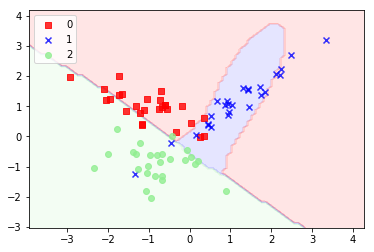

In [137]:
classifier = a1
plot_decision_regions(classifier,train_X_data,train_Y_data,resolution=0.1)

In [153]:
def performCrossValidation(X1,Y1,num_folds,classifier,kernel='rbf',degree=1,sigma=1.0):
    C = 10
    fullXmatrix1 = X1
    fullYvector1 = Y1
    from sklearn.model_selection import KFold
    kf = KFold(n_splits=num_folds)
    kf.get_n_splits(fullXmatrix1)
    consideredSigmaValues = [0.1,0.3,0.4,0.5,0.6,0.7,1.0]
    consideredCValues = [0,50,100]
    consideredKernelValues = ['linear','polynomial','rbf']
    fig, ax = plt.subplots(figsize=(15,10))
    for kernel in consideredKernelValues:
        for C in consideredCValues:
            crossValAvgErrorForEachSigma = []
            crossValVarOfErrorForEachSigma = []
            
            for sigma in consideredSigmaValues:#, 1e-4 ,1e-3, 1e-2, 0.1, 1, 10, 100 ,1000]:
                ValErrorForEachFold = []
                fold = 0
                for train_index, test_index in kf.split(fullXmatrix1):
                    print('fold is '+str(fold))
                    fold += 1
                    #print("TRAIN:", train_index, "TEST:", test_index)
                    X_train, X_test = fullXmatrix1[train_index], fullXmatrix1[test_index]
                    y_train, y_test = fullYvector1[train_index], fullYvector1[test_index]
                    trainXmatrix = X_train
                    ValXmatrix = X_test
                    trainYvector = y_train
                    valYvector = y_test
                    numOfSamples,numOfdimPlusOne = trainXmatrix.shape
                    classifier.fit(X_train, y_train,C,kernel,degree,sigma)
                    #classifier.fit(X_train, y_train,lamda,kernel,degree,sigma)
                    #classifier.fit(X_train, y_train,C,lamda,degree,sigma)
                    predictedLabels = classifier.predict(X_test)
                    numOfCorrectlyPredictedLabels = 0
                    for index in range(0,len(valYvector)):
                        if(valYvector[index] == predictedLabels[index]):
                            numOfCorrectlyPredictedLabels += 1
                    accuracy = numOfCorrectlyPredictedLabels/len(valYvector)
                    error = 1- accuracy
                    ValErrorForEachFold.append(error)
                crossValAvgErrorForEachSigma.append(np.mean(ValErrorForEachFold))
                crossValVarOfErrorForEachSigma.append(np.std(ValErrorForEachFold))
            
            #for i in numOfdimPlusOne:#[:-1]
            #for i in lamdavalues:
            #ax.plot(np.arange(0.8,0.91,0.01),crossValAvgErrorForEachLamda, label= 'Bias Estimate')
            ax.plot(consideredSigmaValues,crossValAvgErrorForEachSigma, label= 'Bias Estimate for Kernel= '+str(kernel)+'C='+str(C))
            ax.plot(consideredSigmaValues,crossValVarOfErrorForEachSigma, label= 'Variance Estimate for Kernel= '+str(kernel)+'C='+str(C))
            if((len(consideredKernelValues)==1) and (len(consideredCValues)==1) and (len(consideredSigmaValues)==1)):
                print('cross validation error estimate is '+str(crossValAvgErrorForEachSigma))
            ax.legend(loc=0) # upper left corner
            ax.set_xlabel('Sigma')
            ax.set_ylabel('values')
            ax.set_title('(using cross validation) Bias & Variance Estimate for different hyperparameter values');
    plt.show()

fold is 0

 Calculating fullXmatrix



     pcost       dcost       gap    pres   dres
 0: -6.4546e+01 -1.1345e-02  7e+02  3e+01  5e-15
 1: -7.7601e-01 -1.0458e-02  8e+00  3e-01  5e-15
 2: -2.5100e-02 -3.2794e-04  2e-01  1e-02  8e-16
 3: -2.6342e-04 -3.7545e-08  3e-03  1e-04  1e-15
 4: -2.6346e-06 -3.7546e-12  3e-05  1e-06  1e-15
 5: -2.6346e-08 -3.7546e-16  3e-07  1e-08  1e-15
 6: -2.6346e-10 -3.7546e-20  3e-09  1e-10  1e-15
Optimal solution found.

 Calculating prediction values



fold is 1

 Calculating fullXmatrix



     pcost       dcost       gap    pres   dres
 0: -6.4872e+01 -1.0767e-02  7e+02  3e+01  5e-15
 1: -8.0319e-01 -1.0227e-02  8e+00  3e-01  5e-15
 2: -5.0188e-02 -9.0526e-04  5e-01  2e-02  8e-16
 3: -5.3723e-04 -1.3128e-07  5e-03  2e-04  1e-15
 4: -5.3737e-06 -1.3129e-11  5e-05  2e-06  1e-15
 5: -5.3737e-08 -1.3129e-15  5e-07  2e-08  1e-15
 6: -5.3737e-10 -1.3129e-19  5e-09  2e-10  1e-15
Optimal solution found.

 Calculating prediction values



fold is 2

 Calculating fullXmatrix



     pcost       dcost       gap    pres   dres
 0: -6.4144e+01 -1.9214e-02  7e+02  3e+01  4e-15
 1: -8.4616e-01 -1.7900e-02  9e+00  4e-01  5e-15
 2: -5.6708e-02 -1.0968e-03  6e-01  2e-02  8e-16
 3: -6.5234e-04 -2.0142e-07  7e-03  3e-04  1e-15
 4: -6.5256e-06 -2.0145e-11  7e-05  3e-06  1e-15
 5: -6.5256e-08 -2.0145e-15  7e-07  3e-08  1e-15
 6: -6.5256e-10 -2.0145e-19  7e-09  3e-10  1e-15
Optimal solution found.

 Calculating prediction values



fold is 0

 Calculating fullXmatrix



     pcost       dcost       gap    pres   dres
 0: -6.4546e+01 -1.1345e-02  7e+02  3e+01  5e-15
 1: -7.7601e-01 -1.0458e-02  8e+00  3e-01  5e-15
 2: -2.5100e-02 -3.2794e-04  2e-01  1e-02  8e-16
 3: -2.6342e-04 -3.7545e-08  3e-03  1e-04  1e-15
 4: -2.6346e-06 -3.7546e-12  3e-05  1e-06  1e-15
 5: -2.6346e-08 -3.7546e-16  3e-07  1e-08  1e-15
 6: -2.6346e-10 -3.7546e-20  3e-09  1e-10  1e-15
Optimal solution found.

 Calculating prediction values



fold is 1

 Calculating fullXmatrix



     pcost       dcost       gap    pres   dres
 0: -6.4872e+01 -1.0767e-02  7e+02  3e+01  5e-15
 1: -8.0319e-01 -1.0227e-02  8e+00  3e-01  5e-15
 2: -5.0188e-02 -9.0526e-04  5e-01  2e-02  8e-16
 3: -5.3723e-04 -1.3128e-07  5e-03  2e-04  1e-15
 4: -5.3737e-06 -1.3129e-11  5e-05  2e-06  1e-15
 5: -5.3737e-08 -1.3129e-15  5e-07  2e-08  1e-15
 6: -5.3737e-10 -1.3129e-19  5e-09  2e-10  1e-15
Optimal solution found.

 Calculating prediction values



fold is 2

 Calculating fullXmatrix



     pcost       dcost       gap    pres   dres
 0: -6.4144e+01 -1.9214e-02  7e+02  3e+01  4e-15
 1: -8.4616e-01 -1.7900e-02  9e+00  4e-01  5e-15
 2: -5.6708e-02 -1.0968e-03  6e-01  2e-02  8e-16
 3: -6.5234e-04 -2.0142e-07  7e-03  3e-04  1e-15
 4: -6.5256e-06 -2.0145e-11  7e-05  3e-06  1e-15
 5: -6.5256e-08 -2.0145e-15  7e-07  3e-08  1e-15
 6: -6.5256e-10 -2.0145e-19  7e-09  3e-10  1e-15
Optimal solution found.

 Calculating prediction values



fold is 0

 Calculating fullXmatrix



     pcost       dcost       gap    pres   dres
 0: -6.4546e+01 -1.1345e-02  7e+02  3e+01  5e-15
 1: -7.7601e-01 -1.0458e-02  8e+00  3e-01  5e-15
 2: -2.5100e-02 -3.2794e-04  2e-01  1e-02  8e-16
 3: -2.6342e-04 -3.7545e-08  3e-03  1e-04  1e-15
 4: -2.6346e-06 -3.7546e-12  3e-05  1e-06  1e-15
 5: -2.6346e-08 -3.7546e-16  3e-07  1e-08  1e-15
 6: -2.6346e-10 -3.7546e-20  3e-09  1e-10  1e-15
Optimal solution found.

 Calculating prediction values



fold is 1

 Calculating fullXmatrix



     pcost       dcost       gap    pres   dres
 0: -6.4872e+01 -1.0767e-02  7e+02  3e+01  5e-15
 1: -8.0319e-01 -1.0227e-02  8e+00  3e-01  5e-15
 2: -5.0188e-02 -9.0526e-04  5e-01  2e-02  8e-16
 3: -5.3723e-04 -1.3128e-07  5e-03  2e-04  1e-15
 4: -5.3737e-06 -1.3129e-11  5e-05  2e-06  1e-15
 5: -5.3737e-08 -1.3129e-15  5e-07  2e-08  1e-15
 6: -5.3737e-10 -1.3129e-19  5e-09  2e-10  1e-15
Optimal solution found.

 Calculating prediction values



fold is 2

 Calculating fullXmatrix



     pcost       dcost       gap    pres   dres
 0: -6.4144e+01 -1.9214e-02  7e+02  3e+01  4e-15
 1: -8.4616e-01 -1.7900e-02  9e+00  4e-01  5e-15
 2: -5.6708e-02 -1.0968e-03  6e-01  2e-02  8e-16
 3: -6.5234e-04 -2.0142e-07  7e-03  3e-04  1e-15
 4: -6.5256e-06 -2.0145e-11  7e-05  3e-06  1e-15
 5: -6.5256e-08 -2.0145e-15  7e-07  3e-08  1e-15
 6: -6.5256e-10 -2.0145e-19  7e-09  3e-10  1e-15
Optimal solution found.

 Calculating prediction values



fold is 0

 Calculating fullXmatrix



     pcost       dcost       gap    pres   dres
 0: -6.4546e+01 -1.1345e-02  7e+02  3e+01  5e-15
 1: -7.7601e-01 -1.0458e-02  8e+00  3e-01  5e-15
 2: -2.5100e-02 -3.2794e-04  2e-01  1e-02  8e-16
 3: -2.6342e-04 -3.7545e-08  3e-03  1e-04  1e-15
 4: -2.6346e-06 -3.7546e-12  3e-05  1e-06  1e-15
 5: -2.6346e-08 -3.7546e-16  3e-07  1e-08  1e-15
 6: -2.6346e-10 -3.7546e-20  3e-09  1e-10  1e-15
Optimal solution found.

 Calculating prediction values



fold is 1

 Calculating fullXmatrix



     pcost       dcost       gap    pres   dres
 0: -6.4872e+01 -1.0767e-02  7e+02  3e+01  5e-15
 1: -8.0319e-01 -1.0227e-02  8e+00  3e-01  5e-15
 2: -5.0188e-02 -9.0526e-04  5e-01  2e-02  8e-16
 3: -5.3723e-04 -1.3128e-07  5e-03  2e-04  1e-15
 4: -5.3737e-06 -1.3129e-11  5e-05  2e-06  1e-15
 5: -5.3737e-08 -1.3129e-15  5e-07  2e-08  1e-15
 6: -5.3737e-10 -1.3129e-19  5e-09  2e-10  1e-15
Optimal solution found.

 Calculating prediction values



fold is 2

 Calculating fullXmatrix



     pcost       dcost       gap    pres   dres
 0: -6.4144e+01 -1.9214e-02  7e+02  3e+01  4e-15
 1: -8.4616e-01 -1.7900e-02  9e+00  4e-01  5e-15
 2: -5.6708e-02 -1.0968e-03  6e-01  2e-02  8e-16
 3: -6.5234e-04 -2.0142e-07  7e-03  3e-04  1e-15
 4: -6.5256e-06 -2.0145e-11  7e-05  3e-06  1e-15
 5: -6.5256e-08 -2.0145e-15  7e-07  3e-08  1e-15
 6: -6.5256e-10 -2.0145e-19  7e-09  3e-10  1e-15
Optimal solution found.

 Calculating prediction values



fold is 0

 Calculating fullXmatrix



     pcost       dcost       gap    pres   dres
 0: -6.4546e+01 -1.1345e-02  7e+02  3e+01  5e-15
 1: -7.7601e-01 -1.0458e-02  8e+00  3e-01  5e-15
 2: -2.5100e-02 -3.2794e-04  2e-01  1e-02  8e-16
 3: -2.6342e-04 -3.7545e-08  3e-03  1e-04  1e-15
 4: -2.6346e-06 -3.7546e-12  3e-05  1e-06  1e-15
 5: -2.6346e-08 -3.7546e-16  3e-07  1e-08  1e-15
 6: -2.6346e-10 -3.7546e-20  3e-09  1e-10  1e-15
Optimal solution found.

 Calculating prediction values



fold is 1

 Calculating fullXmatrix



     pcost       dcost       gap    pres   dres
 0: -6.4872e+01 -1.0767e-02  7e+02  3e+01  5e-15
 1: -8.0319e-01 -1.0227e-02  8e+00  3e-01  5e-15
 2: -5.0188e-02 -9.0526e-04  5e-01  2e-02  8e-16
 3: -5.3723e-04 -1.3128e-07  5e-03  2e-04  1e-15
 4: -5.3737e-06 -1.3129e-11  5e-05  2e-06  1e-15
 5: -5.3737e-08 -1.3129e-15  5e-07  2e-08  1e-15
 6: -5.3737e-10 -1.3129e-19  5e-09  2e-10  1e-15
Optimal solution found.

 Calculating prediction values



fold is 2

 Calculating fullXmatrix



     pcost       dcost       gap    pres   dres
 0: -6.4144e+01 -1.9214e-02  7e+02  3e+01  4e-15
 1: -8.4616e-01 -1.7900e-02  9e+00  4e-01  5e-15
 2: -5.6708e-02 -1.0968e-03  6e-01  2e-02  8e-16
 3: -6.5234e-04 -2.0142e-07  7e-03  3e-04  1e-15
 4: -6.5256e-06 -2.0145e-11  7e-05  3e-06  1e-15
 5: -6.5256e-08 -2.0145e-15  7e-07  3e-08  1e-15
 6: -6.5256e-10 -2.0145e-19  7e-09  3e-10  1e-15
Optimal solution found.

 Calculating prediction values



fold is 0

 Calculating fullXmatrix



     pcost       dcost       gap    pres   dres
 0: -6.4546e+01 -1.1345e-02  7e+02  3e+01  5e-15
 1: -7.7601e-01 -1.0458e-02  8e+00  3e-01  5e-15
 2: -2.5100e-02 -3.2794e-04  2e-01  1e-02  8e-16
 3: -2.6342e-04 -3.7545e-08  3e-03  1e-04  1e-15
 4: -2.6346e-06 -3.7546e-12  3e-05  1e-06  1e-15
 5: -2.6346e-08 -3.7546e-16  3e-07  1e-08  1e-15
 6: -2.6346e-10 -3.7546e-20  3e-09  1e-10  1e-15
Optimal solution found.

 Calculating prediction values



fold is 1

 Calculating fullXmatrix



     pcost       dcost       gap    pres   dres
 0: -6.4872e+01 -1.0767e-02  7e+02  3e+01  5e-15
 1: -8.0319e-01 -1.0227e-02  8e+00  3e-01  5e-15
 2: -5.0188e-02 -9.0526e-04  5e-01  2e-02  8e-16
 3: -5.3723e-04 -1.3128e-07  5e-03  2e-04  1e-15
 4: -5.3737e-06 -1.3129e-11  5e-05  2e-06  1e-15
 5: -5.3737e-08 -1.3129e-15  5e-07  2e-08  1e-15
 6: -5.3737e-10 -1.3129e-19  5e-09  2e-10  1e-15
Optimal solution found.

 Calculating prediction values



fold is 2

 Calculating fullXmatrix



     pcost       dcost       gap    pres   dres
 0: -6.4144e+01 -1.9214e-02  7e+02  3e+01  4e-15
 1: -8.4616e-01 -1.7900e-02  9e+00  4e-01  5e-15
 2: -5.6708e-02 -1.0968e-03  6e-01  2e-02  8e-16
 3: -6.5234e-04 -2.0142e-07  7e-03  3e-04  1e-15
 4: -6.5256e-06 -2.0145e-11  7e-05  3e-06  1e-15
 5: -6.5256e-08 -2.0145e-15  7e-07  3e-08  1e-15
 6: -6.5256e-10 -2.0145e-19  7e-09  3e-10  1e-15
Optimal solution found.

 Calculating prediction values



fold is 0

 Calculating fullXmatrix



     pcost       dcost       gap    pres   dres
 0: -6.4546e+01 -1.1345e-02  7e+02  3e+01  5e-15
 1: -7.7601e-01 -1.0458e-02  8e+00  3e-01  5e-15
 2: -2.5100e-02 -3.2794e-04  2e-01  1e-02  8e-16
 3: -2.6342e-04 -3.7545e-08  3e-03  1e-04  1e-15
 4: -2.6346e-06 -3.7546e-12  3e-05  1e-06  1e-15
 5: -2.6346e-08 -3.7546e-16  3e-07  1e-08  1e-15
 6: -2.6346e-10 -3.7546e-20  3e-09  1e-10  1e-15
Optimal solution found.

 Calculating prediction values



fold is 1

 Calculating fullXmatrix



     pcost       dcost       gap    pres   dres
 0: -6.4872e+01 -1.0767e-02  7e+02  3e+01  5e-15
 1: -8.0319e-01 -1.0227e-02  8e+00  3e-01  5e-15
 2: -5.0188e-02 -9.0526e-04  5e-01  2e-02  8e-16
 3: -5.3723e-04 -1.3128e-07  5e-03  2e-04  1e-15
 4: -5.3737e-06 -1.3129e-11  5e-05  2e-06  1e-15
 5: -5.3737e-08 -1.3129e-15  5e-07  2e-08  1e-15
 6: -5.3737e-10 -1.3129e-19  5e-09  2e-10  1e-15
Optimal solution found.

 Calculating prediction values



fold is 2

 Calculating fullXmatrix



     pcost       dcost       gap    pres   dres
 0: -6.4144e+01 -1.9214e-02  7e+02  3e+01  4e-15
 1: -8.4616e-01 -1.7900e-02  9e+00  4e-01  5e-15
 2: -5.6708e-02 -1.0968e-03  6e-01  2e-02  8e-16
 3: -6.5234e-04 -2.0142e-07  7e-03  3e-04  1e-15
 4: -6.5256e-06 -2.0145e-11  7e-05  3e-06  1e-15
 5: -6.5256e-08 -2.0145e-15  7e-07  3e-08  1e-15
 6: -6.5256e-10 -2.0145e-19  7e-09  3e-10  1e-15
Optimal solution found.

 Calculating prediction values



fold is 0

 Calculating fullXmatrix



     pcost       dcost       gap    pres   dres
 0: -3.2629e+03 -7.3095e+04  7e+04  0e+00  3e-13
 1: -3.5403e+03 -7.1145e+03  4e+03  1e-16  2e-13
 2: -5.3599e+03 -6.4221e+03  1e+03  1e-16  3e-13
 3: -5.6073e+03 -6.0980e+03  5e+02  2e-16  3e-13
 4: -5.7195e+03 -5.9395e+03  2e+02  2e-16  3e-13
 5: -5.7784e+03 -5.8642e+03  9e+01  2e-16  3e-13
 6: -5.8068e+03 -5.8288e+03  2e+01  2e-16  3e-13
 7: -5.8141e+03 -5.8198e+03  6e+00  2e-16  3e-13
 8: -5.8166e+03 -5.8168e+03  2e-01  2e-16  4e-13
 9: -5.8167e+03 -5.8167e+03  2e-03  2e-16  4e-13
Optimal solution found.

 Calculating prediction values



fold is 1

 Calculating fullXmatrix



     pcost       dcost       gap    pres   dres
 0: -3.2810e+03 -1.0932e+05  1e+05  2e-17  3e-13
 1: -3.4854e+03 -7.5157e+03  4e+03  1e-16  2e-13
 2: -5.7152e+03 -6.7749e+03  1e+03  2e-16  4e-13
 3: -5.9591e+03 -6.1094e+03  2e+02  2e-16  4e-13
 4: -5.9982e+03 -6.0043e+03  6e+00  2e-16  4e-13
 5: -6.0003e+03 -6.0004e+03  6e-02  2e-16  3e-13
 6: -6.0003e+03 -6.0003e+03  6e-04  2e-16  3e-13
Optimal solution found.

 Calculating prediction values



fold is 2

 Calculating fullXmatrix



     pcost       dcost       gap    pres   dres
 0: -3.2224e+03 -1.1700e+05  1e+05  2e-17  3e-13
 1: -3.4248e+03 -7.6731e+03  4e+03  1e-16  2e-13
 2: -5.3072e+03 -6.5645e+03  1e+03  2e-16  3e-13
 3: -5.5876e+03 -6.0397e+03  5e+02  2e-16  3e-13
 4: -5.7199e+03 -5.8400e+03  1e+02  2e-16  4e-13
 5: -5.7638e+03 -5.7835e+03  2e+01  2e-16  3e-13
 6: -5.7667e+03 -5.7794e+03  1e+01  2e-16  4e-13
 7: -5.7711e+03 -5.7744e+03  3e+00  2e-16  3e-13
 8: -5.7724e+03 -5.7729e+03  5e-01  2e-16  3e-13
 9: -5.7726e+03 -5.7727e+03  4e-02  2e-16  3e-13
10: -5.7727e+03 -5.7727e+03  4e-04  2e-16  3e-13
Optimal solution found.

 Calculating prediction values



fold is 0

 Calculating fullXmatrix



     pcost       dcost       gap    pres   dres
 0: -3.2629e+03 -7.3095e+04  7e+04  0e+00  3e-13
 1: -3.5403e+03 -7.1145e+03  4e+03  1e-16  2e-13
 2: -5.3599e+03 -6.4221e+03  1e+03  1e-16  3e-13
 3: -5.6073e+03 -6.0980e+03  5e+02  2e-16  3e-13
 4: -5.7195e+03 -5.9395e+03  2e+02  2e-16  3e-13
 5: -5.7784e+03 -5.8642e+03  9e+01  2e-16  3e-13
 6: -5.8068e+03 -5.8288e+03  2e+01  2e-16  3e-13
 7: -5.8141e+03 -5.8198e+03  6e+00  2e-16  3e-13
 8: -5.8166e+03 -5.8168e+03  2e-01  2e-16  4e-13
 9: -5.8167e+03 -5.8167e+03  2e-03  2e-16  4e-13
Optimal solution found.

 Calculating prediction values



fold is 1

 Calculating fullXmatrix



     pcost       dcost       gap    pres   dres
 0: -3.2810e+03 -1.0932e+05  1e+05  2e-17  3e-13
 1: -3.4854e+03 -7.5157e+03  4e+03  1e-16  2e-13
 2: -5.7152e+03 -6.7749e+03  1e+03  2e-16  4e-13
 3: -5.9591e+03 -6.1094e+03  2e+02  2e-16  4e-13
 4: -5.9982e+03 -6.0043e+03  6e+00  2e-16  4e-13
 5: -6.0003e+03 -6.0004e+03  6e-02  2e-16  3e-13
 6: -6.0003e+03 -6.0003e+03  6e-04  2e-16  3e-13
Optimal solution found.

 Calculating prediction values



fold is 2

 Calculating fullXmatrix



     pcost       dcost       gap    pres   dres
 0: -3.2224e+03 -1.1700e+05  1e+05  2e-17  3e-13
 1: -3.4248e+03 -7.6731e+03  4e+03  1e-16  2e-13
 2: -5.3072e+03 -6.5645e+03  1e+03  2e-16  3e-13
 3: -5.5876e+03 -6.0397e+03  5e+02  2e-16  3e-13
 4: -5.7199e+03 -5.8400e+03  1e+02  2e-16  4e-13
 5: -5.7638e+03 -5.7835e+03  2e+01  2e-16  3e-13
 6: -5.7667e+03 -5.7794e+03  1e+01  2e-16  4e-13
 7: -5.7711e+03 -5.7744e+03  3e+00  2e-16  3e-13
 8: -5.7724e+03 -5.7729e+03  5e-01  2e-16  3e-13
 9: -5.7726e+03 -5.7727e+03  4e-02  2e-16  3e-13
10: -5.7727e+03 -5.7727e+03  4e-04  2e-16  3e-13
Optimal solution found.

 Calculating prediction values



fold is 0

 Calculating fullXmatrix



     pcost       dcost       gap    pres   dres
 0: -3.2629e+03 -7.3095e+04  7e+04  0e+00  3e-13
 1: -3.5403e+03 -7.1145e+03  4e+03  1e-16  2e-13
 2: -5.3599e+03 -6.4221e+03  1e+03  1e-16  3e-13
 3: -5.6073e+03 -6.0980e+03  5e+02  2e-16  3e-13
 4: -5.7195e+03 -5.9395e+03  2e+02  2e-16  3e-13
 5: -5.7784e+03 -5.8642e+03  9e+01  2e-16  3e-13
 6: -5.8068e+03 -5.8288e+03  2e+01  2e-16  3e-13
 7: -5.8141e+03 -5.8198e+03  6e+00  2e-16  3e-13
 8: -5.8166e+03 -5.8168e+03  2e-01  2e-16  4e-13
 9: -5.8167e+03 -5.8167e+03  2e-03  2e-16  4e-13
Optimal solution found.

 Calculating prediction values



fold is 1

 Calculating fullXmatrix



     pcost       dcost       gap    pres   dres
 0: -3.2810e+03 -1.0932e+05  1e+05  2e-17  3e-13
 1: -3.4854e+03 -7.5157e+03  4e+03  1e-16  2e-13
 2: -5.7152e+03 -6.7749e+03  1e+03  2e-16  4e-13
 3: -5.9591e+03 -6.1094e+03  2e+02  2e-16  4e-13
 4: -5.9982e+03 -6.0043e+03  6e+00  2e-16  4e-13
 5: -6.0003e+03 -6.0004e+03  6e-02  2e-16  3e-13
 6: -6.0003e+03 -6.0003e+03  6e-04  2e-16  3e-13
Optimal solution found.

 Calculating prediction values



fold is 2

 Calculating fullXmatrix



     pcost       dcost       gap    pres   dres
 0: -3.2224e+03 -1.1700e+05  1e+05  2e-17  3e-13
 1: -3.4248e+03 -7.6731e+03  4e+03  1e-16  2e-13
 2: -5.3072e+03 -6.5645e+03  1e+03  2e-16  3e-13
 3: -5.5876e+03 -6.0397e+03  5e+02  2e-16  3e-13
 4: -5.7199e+03 -5.8400e+03  1e+02  2e-16  4e-13
 5: -5.7638e+03 -5.7835e+03  2e+01  2e-16  3e-13
 6: -5.7667e+03 -5.7794e+03  1e+01  2e-16  4e-13
 7: -5.7711e+03 -5.7744e+03  3e+00  2e-16  3e-13
 8: -5.7724e+03 -5.7729e+03  5e-01  2e-16  3e-13
 9: -5.7726e+03 -5.7727e+03  4e-02  2e-16  3e-13
10: -5.7727e+03 -5.7727e+03  4e-04  2e-16  3e-13
Optimal solution found.

 Calculating prediction values



fold is 0

 Calculating fullXmatrix



     pcost       dcost       gap    pres   dres
 0: -3.2629e+03 -7.3095e+04  7e+04  0e+00  3e-13
 1: -3.5403e+03 -7.1145e+03  4e+03  1e-16  2e-13
 2: -5.3599e+03 -6.4221e+03  1e+03  1e-16  3e-13
 3: -5.6073e+03 -6.0980e+03  5e+02  2e-16  3e-13
 4: -5.7195e+03 -5.9395e+03  2e+02  2e-16  3e-13
 5: -5.7784e+03 -5.8642e+03  9e+01  2e-16  3e-13
 6: -5.8068e+03 -5.8288e+03  2e+01  2e-16  3e-13
 7: -5.8141e+03 -5.8198e+03  6e+00  2e-16  3e-13
 8: -5.8166e+03 -5.8168e+03  2e-01  2e-16  4e-13
 9: -5.8167e+03 -5.8167e+03  2e-03  2e-16  4e-13
Optimal solution found.

 Calculating prediction values



fold is 1

 Calculating fullXmatrix



     pcost       dcost       gap    pres   dres
 0: -3.2810e+03 -1.0932e+05  1e+05  2e-17  3e-13
 1: -3.4854e+03 -7.5157e+03  4e+03  1e-16  2e-13
 2: -5.7152e+03 -6.7749e+03  1e+03  2e-16  4e-13
 3: -5.9591e+03 -6.1094e+03  2e+02  2e-16  4e-13
 4: -5.9982e+03 -6.0043e+03  6e+00  2e-16  4e-13
 5: -6.0003e+03 -6.0004e+03  6e-02  2e-16  3e-13
 6: -6.0003e+03 -6.0003e+03  6e-04  2e-16  3e-13
Optimal solution found.

 Calculating prediction values



fold is 2

 Calculating fullXmatrix



     pcost       dcost       gap    pres   dres
 0: -3.2224e+03 -1.1700e+05  1e+05  2e-17  3e-13
 1: -3.4248e+03 -7.6731e+03  4e+03  1e-16  2e-13
 2: -5.3072e+03 -6.5645e+03  1e+03  2e-16  3e-13
 3: -5.5876e+03 -6.0397e+03  5e+02  2e-16  3e-13
 4: -5.7199e+03 -5.8400e+03  1e+02  2e-16  4e-13
 5: -5.7638e+03 -5.7835e+03  2e+01  2e-16  3e-13
 6: -5.7667e+03 -5.7794e+03  1e+01  2e-16  4e-13
 7: -5.7711e+03 -5.7744e+03  3e+00  2e-16  3e-13
 8: -5.7724e+03 -5.7729e+03  5e-01  2e-16  3e-13
 9: -5.7726e+03 -5.7727e+03  4e-02  2e-16  3e-13
10: -5.7727e+03 -5.7727e+03  4e-04  2e-16  3e-13
Optimal solution found.

 Calculating prediction values



fold is 0

 Calculating fullXmatrix



     pcost       dcost       gap    pres   dres
 0: -3.2629e+03 -7.3095e+04  7e+04  0e+00  3e-13
 1: -3.5403e+03 -7.1145e+03  4e+03  1e-16  2e-13
 2: -5.3599e+03 -6.4221e+03  1e+03  1e-16  3e-13
 3: -5.6073e+03 -6.0980e+03  5e+02  2e-16  3e-13
 4: -5.7195e+03 -5.9395e+03  2e+02  2e-16  3e-13
 5: -5.7784e+03 -5.8642e+03  9e+01  2e-16  3e-13
 6: -5.8068e+03 -5.8288e+03  2e+01  2e-16  3e-13
 7: -5.8141e+03 -5.8198e+03  6e+00  2e-16  3e-13
 8: -5.8166e+03 -5.8168e+03  2e-01  2e-16  4e-13
 9: -5.8167e+03 -5.8167e+03  2e-03  2e-16  4e-13
Optimal solution found.

 Calculating prediction values



fold is 1

 Calculating fullXmatrix



     pcost       dcost       gap    pres   dres
 0: -3.2810e+03 -1.0932e+05  1e+05  2e-17  3e-13
 1: -3.4854e+03 -7.5157e+03  4e+03  1e-16  2e-13
 2: -5.7152e+03 -6.7749e+03  1e+03  2e-16  4e-13
 3: -5.9591e+03 -6.1094e+03  2e+02  2e-16  4e-13
 4: -5.9982e+03 -6.0043e+03  6e+00  2e-16  4e-13
 5: -6.0003e+03 -6.0004e+03  6e-02  2e-16  3e-13
 6: -6.0003e+03 -6.0003e+03  6e-04  2e-16  3e-13
Optimal solution found.

 Calculating prediction values



fold is 2

 Calculating fullXmatrix



     pcost       dcost       gap    pres   dres
 0: -3.2224e+03 -1.1700e+05  1e+05  2e-17  3e-13
 1: -3.4248e+03 -7.6731e+03  4e+03  1e-16  2e-13
 2: -5.3072e+03 -6.5645e+03  1e+03  2e-16  3e-13
 3: -5.5876e+03 -6.0397e+03  5e+02  2e-16  3e-13
 4: -5.7199e+03 -5.8400e+03  1e+02  2e-16  4e-13
 5: -5.7638e+03 -5.7835e+03  2e+01  2e-16  3e-13
 6: -5.7667e+03 -5.7794e+03  1e+01  2e-16  4e-13
 7: -5.7711e+03 -5.7744e+03  3e+00  2e-16  3e-13
 8: -5.7724e+03 -5.7729e+03  5e-01  2e-16  3e-13
 9: -5.7726e+03 -5.7727e+03  4e-02  2e-16  3e-13
10: -5.7727e+03 -5.7727e+03  4e-04  2e-16  3e-13
Optimal solution found.

 Calculating prediction values



fold is 0

 Calculating fullXmatrix



     pcost       dcost       gap    pres   dres
 0: -3.2629e+03 -7.3095e+04  7e+04  0e+00  3e-13
 1: -3.5403e+03 -7.1145e+03  4e+03  1e-16  2e-13
 2: -5.3599e+03 -6.4221e+03  1e+03  1e-16  3e-13
 3: -5.6073e+03 -6.0980e+03  5e+02  2e-16  3e-13
 4: -5.7195e+03 -5.9395e+03  2e+02  2e-16  3e-13
 5: -5.7784e+03 -5.8642e+03  9e+01  2e-16  3e-13
 6: -5.8068e+03 -5.8288e+03  2e+01  2e-16  3e-13
 7: -5.8141e+03 -5.8198e+03  6e+00  2e-16  3e-13
 8: -5.8166e+03 -5.8168e+03  2e-01  2e-16  4e-13
 9: -5.8167e+03 -5.8167e+03  2e-03  2e-16  4e-13
Optimal solution found.

 Calculating prediction values



fold is 1

 Calculating fullXmatrix



     pcost       dcost       gap    pres   dres
 0: -3.2810e+03 -1.0932e+05  1e+05  2e-17  3e-13
 1: -3.4854e+03 -7.5157e+03  4e+03  1e-16  2e-13
 2: -5.7152e+03 -6.7749e+03  1e+03  2e-16  4e-13
 3: -5.9591e+03 -6.1094e+03  2e+02  2e-16  4e-13
 4: -5.9982e+03 -6.0043e+03  6e+00  2e-16  4e-13
 5: -6.0003e+03 -6.0004e+03  6e-02  2e-16  3e-13
 6: -6.0003e+03 -6.0003e+03  6e-04  2e-16  3e-13
Optimal solution found.

 Calculating prediction values



fold is 2

 Calculating fullXmatrix



     pcost       dcost       gap    pres   dres
 0: -3.2224e+03 -1.1700e+05  1e+05  2e-17  3e-13
 1: -3.4248e+03 -7.6731e+03  4e+03  1e-16  2e-13
 2: -5.3072e+03 -6.5645e+03  1e+03  2e-16  3e-13
 3: -5.5876e+03 -6.0397e+03  5e+02  2e-16  3e-13
 4: -5.7199e+03 -5.8400e+03  1e+02  2e-16  4e-13
 5: -5.7638e+03 -5.7835e+03  2e+01  2e-16  3e-13
 6: -5.7667e+03 -5.7794e+03  1e+01  2e-16  4e-13
 7: -5.7711e+03 -5.7744e+03  3e+00  2e-16  3e-13
 8: -5.7724e+03 -5.7729e+03  5e-01  2e-16  3e-13
 9: -5.7726e+03 -5.7727e+03  4e-02  2e-16  3e-13
10: -5.7727e+03 -5.7727e+03  4e-04  2e-16  3e-13
Optimal solution found.

 Calculating prediction values



fold is 0

 Calculating fullXmatrix



     pcost       dcost       gap    pres   dres
 0: -3.2629e+03 -7.3095e+04  7e+04  0e+00  3e-13
 1: -3.5403e+03 -7.1145e+03  4e+03  1e-16  2e-13
 2: -5.3599e+03 -6.4221e+03  1e+03  1e-16  3e-13
 3: -5.6073e+03 -6.0980e+03  5e+02  2e-16  3e-13
 4: -5.7195e+03 -5.9395e+03  2e+02  2e-16  3e-13
 5: -5.7784e+03 -5.8642e+03  9e+01  2e-16  3e-13
 6: -5.8068e+03 -5.8288e+03  2e+01  2e-16  3e-13
 7: -5.8141e+03 -5.8198e+03  6e+00  2e-16  3e-13
 8: -5.8166e+03 -5.8168e+03  2e-01  2e-16  4e-13
 9: -5.8167e+03 -5.8167e+03  2e-03  2e-16  4e-13
Optimal solution found.

 Calculating prediction values



fold is 1

 Calculating fullXmatrix



     pcost       dcost       gap    pres   dres
 0: -3.2810e+03 -1.0932e+05  1e+05  2e-17  3e-13
 1: -3.4854e+03 -7.5157e+03  4e+03  1e-16  2e-13
 2: -5.7152e+03 -6.7749e+03  1e+03  2e-16  4e-13
 3: -5.9591e+03 -6.1094e+03  2e+02  2e-16  4e-13
 4: -5.9982e+03 -6.0043e+03  6e+00  2e-16  4e-13
 5: -6.0003e+03 -6.0004e+03  6e-02  2e-16  3e-13
 6: -6.0003e+03 -6.0003e+03  6e-04  2e-16  3e-13
Optimal solution found.

 Calculating prediction values



fold is 2

 Calculating fullXmatrix



     pcost       dcost       gap    pres   dres
 0: -3.2224e+03 -1.1700e+05  1e+05  2e-17  3e-13
 1: -3.4248e+03 -7.6731e+03  4e+03  1e-16  2e-13
 2: -5.3072e+03 -6.5645e+03  1e+03  2e-16  3e-13
 3: -5.5876e+03 -6.0397e+03  5e+02  2e-16  3e-13
 4: -5.7199e+03 -5.8400e+03  1e+02  2e-16  4e-13
 5: -5.7638e+03 -5.7835e+03  2e+01  2e-16  3e-13
 6: -5.7667e+03 -5.7794e+03  1e+01  2e-16  4e-13
 7: -5.7711e+03 -5.7744e+03  3e+00  2e-16  3e-13
 8: -5.7724e+03 -5.7729e+03  5e-01  2e-16  3e-13
 9: -5.7726e+03 -5.7727e+03  4e-02  2e-16  3e-13
10: -5.7727e+03 -5.7727e+03  4e-04  2e-16  3e-13
Optimal solution found.

 Calculating prediction values



fold is 0

 Calculating fullXmatrix



     pcost       dcost       gap    pres   dres
 0: -6.4046e+03 -2.6363e+05  3e+05  0e+00  5e-13
 1: -6.7929e+03 -1.5406e+04  9e+03  1e-16  4e-13
 2: -1.0762e+04 -1.3000e+04  2e+03  2e-16  6e-13
 3: -1.1231e+04 -1.2247e+04  1e+03  2e-16  6e-13
 4: -1.1442e+04 -1.1904e+04  5e+02  2e-16  6e-13
 5: -1.1558e+04 -1.1735e+04  2e+02  2e-16  7e-13
 6: -1.1614e+04 -1.1657e+04  4e+01  2e-16  6e-13
 7: -1.1627e+04 -1.1640e+04  1e+01  2e-16  7e-13
 8: -1.1633e+04 -1.1633e+04  7e-01  2e-16  7e-13
 9: -1.1633e+04 -1.1633e+04  7e-03  2e-16  6e-13
Optimal solution found.

 Calculating prediction values



fold is 1

 Calculating fullXmatrix



     pcost       dcost       gap    pres   dres
 0: -6.4433e+03 -4.1984e+05  4e+05  1e-17  5e-13
 1: -6.7363e+03 -1.7035e+04  1e+04  1e-16  4e-13
 2: -1.1512e+04 -1.3248e+04  2e+03  2e-16  7e-13
 3: -1.1916e+04 -1.2195e+04  3e+02  2e-16  7e-13
 4: -1.1996e+04 -1.2008e+04  1e+01  2e-16  7e-13
 5: -1.2000e+04 -1.2000e+04  1e-01  2e-16  7e-13
 6: -1.2000e+04 -1.2000e+04  1e-03  2e-16  7e-13
Optimal solution found.

 Calculating prediction values



fold is 2

 Calculating fullXmatrix



     pcost       dcost       gap    pres   dres
 0: -6.2845e+03 -4.5028e+05  4e+05  1e-17  5e-13
 1: -6.6376e+03 -1.7532e+04  1e+04  1e-16  3e-13
 2: -1.0655e+04 -1.2742e+04  2e+03  2e-16  6e-13
 3: -1.1139e+04 -1.2052e+04  9e+02  2e-16  6e-13
 4: -1.1423e+04 -1.1680e+04  3e+02  2e-16  7e-13
 5: -1.1516e+04 -1.1577e+04  6e+01  2e-16  7e-13
 6: -1.1533e+04 -1.1558e+04  2e+01  2e-16  5e-13
 7: -1.1542e+04 -1.1548e+04  6e+00  2e-16  6e-13
 8: -1.1544e+04 -1.1546e+04  1e+00  2e-16  7e-13
 9: -1.1545e+04 -1.1545e+04  9e-02  2e-16  7e-13
10: -1.1545e+04 -1.1545e+04  9e-04  2e-16  7e-13
Optimal solution found.

 Calculating prediction values



fold is 0

 Calculating fullXmatrix



     pcost       dcost       gap    pres   dres
 0: -6.4046e+03 -2.6363e+05  3e+05  0e+00  5e-13
 1: -6.7929e+03 -1.5406e+04  9e+03  1e-16  4e-13
 2: -1.0762e+04 -1.3000e+04  2e+03  2e-16  6e-13
 3: -1.1231e+04 -1.2247e+04  1e+03  2e-16  6e-13
 4: -1.1442e+04 -1.1904e+04  5e+02  2e-16  6e-13
 5: -1.1558e+04 -1.1735e+04  2e+02  2e-16  7e-13
 6: -1.1614e+04 -1.1657e+04  4e+01  2e-16  6e-13
 7: -1.1627e+04 -1.1640e+04  1e+01  2e-16  7e-13
 8: -1.1633e+04 -1.1633e+04  7e-01  2e-16  7e-13
 9: -1.1633e+04 -1.1633e+04  7e-03  2e-16  6e-13
Optimal solution found.

 Calculating prediction values



fold is 1

 Calculating fullXmatrix



     pcost       dcost       gap    pres   dres
 0: -6.4433e+03 -4.1984e+05  4e+05  1e-17  5e-13
 1: -6.7363e+03 -1.7035e+04  1e+04  1e-16  4e-13
 2: -1.1512e+04 -1.3248e+04  2e+03  2e-16  7e-13
 3: -1.1916e+04 -1.2195e+04  3e+02  2e-16  7e-13
 4: -1.1996e+04 -1.2008e+04  1e+01  2e-16  7e-13
 5: -1.2000e+04 -1.2000e+04  1e-01  2e-16  7e-13
 6: -1.2000e+04 -1.2000e+04  1e-03  2e-16  7e-13
Optimal solution found.

 Calculating prediction values



fold is 2

 Calculating fullXmatrix



     pcost       dcost       gap    pres   dres
 0: -6.2845e+03 -4.5028e+05  4e+05  1e-17  5e-13
 1: -6.6376e+03 -1.7532e+04  1e+04  1e-16  3e-13
 2: -1.0655e+04 -1.2742e+04  2e+03  2e-16  6e-13
 3: -1.1139e+04 -1.2052e+04  9e+02  2e-16  6e-13
 4: -1.1423e+04 -1.1680e+04  3e+02  2e-16  7e-13
 5: -1.1516e+04 -1.1577e+04  6e+01  2e-16  7e-13
 6: -1.1533e+04 -1.1558e+04  2e+01  2e-16  5e-13
 7: -1.1542e+04 -1.1548e+04  6e+00  2e-16  6e-13
 8: -1.1544e+04 -1.1546e+04  1e+00  2e-16  7e-13
 9: -1.1545e+04 -1.1545e+04  9e-02  2e-16  7e-13
10: -1.1545e+04 -1.1545e+04  9e-04  2e-16  7e-13
Optimal solution found.

 Calculating prediction values



fold is 0

 Calculating fullXmatrix



     pcost       dcost       gap    pres   dres
 0: -6.4046e+03 -2.6363e+05  3e+05  0e+00  5e-13
 1: -6.7929e+03 -1.5406e+04  9e+03  1e-16  4e-13
 2: -1.0762e+04 -1.3000e+04  2e+03  2e-16  6e-13
 3: -1.1231e+04 -1.2247e+04  1e+03  2e-16  6e-13
 4: -1.1442e+04 -1.1904e+04  5e+02  2e-16  6e-13
 5: -1.1558e+04 -1.1735e+04  2e+02  2e-16  7e-13
 6: -1.1614e+04 -1.1657e+04  4e+01  2e-16  6e-13
 7: -1.1627e+04 -1.1640e+04  1e+01  2e-16  7e-13
 8: -1.1633e+04 -1.1633e+04  7e-01  2e-16  7e-13
 9: -1.1633e+04 -1.1633e+04  7e-03  2e-16  6e-13
Optimal solution found.

 Calculating prediction values



fold is 1

 Calculating fullXmatrix



     pcost       dcost       gap    pres   dres
 0: -6.4433e+03 -4.1984e+05  4e+05  1e-17  5e-13
 1: -6.7363e+03 -1.7035e+04  1e+04  1e-16  4e-13
 2: -1.1512e+04 -1.3248e+04  2e+03  2e-16  7e-13
 3: -1.1916e+04 -1.2195e+04  3e+02  2e-16  7e-13
 4: -1.1996e+04 -1.2008e+04  1e+01  2e-16  7e-13
 5: -1.2000e+04 -1.2000e+04  1e-01  2e-16  7e-13
 6: -1.2000e+04 -1.2000e+04  1e-03  2e-16  7e-13
Optimal solution found.

 Calculating prediction values



fold is 2

 Calculating fullXmatrix



     pcost       dcost       gap    pres   dres
 0: -6.2845e+03 -4.5028e+05  4e+05  1e-17  5e-13
 1: -6.6376e+03 -1.7532e+04  1e+04  1e-16  3e-13
 2: -1.0655e+04 -1.2742e+04  2e+03  2e-16  6e-13
 3: -1.1139e+04 -1.2052e+04  9e+02  2e-16  6e-13
 4: -1.1423e+04 -1.1680e+04  3e+02  2e-16  7e-13
 5: -1.1516e+04 -1.1577e+04  6e+01  2e-16  7e-13
 6: -1.1533e+04 -1.1558e+04  2e+01  2e-16  5e-13
 7: -1.1542e+04 -1.1548e+04  6e+00  2e-16  6e-13
 8: -1.1544e+04 -1.1546e+04  1e+00  2e-16  7e-13
 9: -1.1545e+04 -1.1545e+04  9e-02  2e-16  7e-13
10: -1.1545e+04 -1.1545e+04  9e-04  2e-16  7e-13
Optimal solution found.

 Calculating prediction values



fold is 0

 Calculating fullXmatrix



     pcost       dcost       gap    pres   dres
 0: -6.4046e+03 -2.6363e+05  3e+05  0e+00  5e-13
 1: -6.7929e+03 -1.5406e+04  9e+03  1e-16  4e-13
 2: -1.0762e+04 -1.3000e+04  2e+03  2e-16  6e-13
 3: -1.1231e+04 -1.2247e+04  1e+03  2e-16  6e-13
 4: -1.1442e+04 -1.1904e+04  5e+02  2e-16  6e-13
 5: -1.1558e+04 -1.1735e+04  2e+02  2e-16  7e-13
 6: -1.1614e+04 -1.1657e+04  4e+01  2e-16  6e-13
 7: -1.1627e+04 -1.1640e+04  1e+01  2e-16  7e-13
 8: -1.1633e+04 -1.1633e+04  7e-01  2e-16  7e-13
 9: -1.1633e+04 -1.1633e+04  7e-03  2e-16  6e-13
Optimal solution found.

 Calculating prediction values



fold is 1

 Calculating fullXmatrix



     pcost       dcost       gap    pres   dres
 0: -6.4433e+03 -4.1984e+05  4e+05  1e-17  5e-13
 1: -6.7363e+03 -1.7035e+04  1e+04  1e-16  4e-13
 2: -1.1512e+04 -1.3248e+04  2e+03  2e-16  7e-13
 3: -1.1916e+04 -1.2195e+04  3e+02  2e-16  7e-13
 4: -1.1996e+04 -1.2008e+04  1e+01  2e-16  7e-13
 5: -1.2000e+04 -1.2000e+04  1e-01  2e-16  7e-13
 6: -1.2000e+04 -1.2000e+04  1e-03  2e-16  7e-13
Optimal solution found.

 Calculating prediction values



fold is 2

 Calculating fullXmatrix



     pcost       dcost       gap    pres   dres
 0: -6.2845e+03 -4.5028e+05  4e+05  1e-17  5e-13
 1: -6.6376e+03 -1.7532e+04  1e+04  1e-16  3e-13
 2: -1.0655e+04 -1.2742e+04  2e+03  2e-16  6e-13
 3: -1.1139e+04 -1.2052e+04  9e+02  2e-16  6e-13
 4: -1.1423e+04 -1.1680e+04  3e+02  2e-16  7e-13
 5: -1.1516e+04 -1.1577e+04  6e+01  2e-16  7e-13
 6: -1.1533e+04 -1.1558e+04  2e+01  2e-16  5e-13
 7: -1.1542e+04 -1.1548e+04  6e+00  2e-16  6e-13
 8: -1.1544e+04 -1.1546e+04  1e+00  2e-16  7e-13
 9: -1.1545e+04 -1.1545e+04  9e-02  2e-16  7e-13
10: -1.1545e+04 -1.1545e+04  9e-04  2e-16  7e-13
Optimal solution found.

 Calculating prediction values



fold is 0

 Calculating fullXmatrix



     pcost       dcost       gap    pres   dres
 0: -6.4046e+03 -2.6363e+05  3e+05  0e+00  5e-13
 1: -6.7929e+03 -1.5406e+04  9e+03  1e-16  4e-13
 2: -1.0762e+04 -1.3000e+04  2e+03  2e-16  6e-13
 3: -1.1231e+04 -1.2247e+04  1e+03  2e-16  6e-13
 4: -1.1442e+04 -1.1904e+04  5e+02  2e-16  6e-13
 5: -1.1558e+04 -1.1735e+04  2e+02  2e-16  7e-13
 6: -1.1614e+04 -1.1657e+04  4e+01  2e-16  6e-13
 7: -1.1627e+04 -1.1640e+04  1e+01  2e-16  7e-13
 8: -1.1633e+04 -1.1633e+04  7e-01  2e-16  7e-13
 9: -1.1633e+04 -1.1633e+04  7e-03  2e-16  6e-13
Optimal solution found.

 Calculating prediction values



fold is 1

 Calculating fullXmatrix



     pcost       dcost       gap    pres   dres
 0: -6.4433e+03 -4.1984e+05  4e+05  1e-17  5e-13
 1: -6.7363e+03 -1.7035e+04  1e+04  1e-16  4e-13
 2: -1.1512e+04 -1.3248e+04  2e+03  2e-16  7e-13
 3: -1.1916e+04 -1.2195e+04  3e+02  2e-16  7e-13
 4: -1.1996e+04 -1.2008e+04  1e+01  2e-16  7e-13
 5: -1.2000e+04 -1.2000e+04  1e-01  2e-16  7e-13
 6: -1.2000e+04 -1.2000e+04  1e-03  2e-16  7e-13
Optimal solution found.

 Calculating prediction values



fold is 2

 Calculating fullXmatrix



     pcost       dcost       gap    pres   dres
 0: -6.2845e+03 -4.5028e+05  4e+05  1e-17  5e-13
 1: -6.6376e+03 -1.7532e+04  1e+04  1e-16  3e-13
 2: -1.0655e+04 -1.2742e+04  2e+03  2e-16  6e-13
 3: -1.1139e+04 -1.2052e+04  9e+02  2e-16  6e-13
 4: -1.1423e+04 -1.1680e+04  3e+02  2e-16  7e-13
 5: -1.1516e+04 -1.1577e+04  6e+01  2e-16  7e-13
 6: -1.1533e+04 -1.1558e+04  2e+01  2e-16  5e-13
 7: -1.1542e+04 -1.1548e+04  6e+00  2e-16  6e-13
 8: -1.1544e+04 -1.1546e+04  1e+00  2e-16  7e-13
 9: -1.1545e+04 -1.1545e+04  9e-02  2e-16  7e-13
10: -1.1545e+04 -1.1545e+04  9e-04  2e-16  7e-13
Optimal solution found.

 Calculating prediction values



fold is 0

 Calculating fullXmatrix



     pcost       dcost       gap    pres   dres
 0: -6.4046e+03 -2.6363e+05  3e+05  0e+00  5e-13
 1: -6.7929e+03 -1.5406e+04  9e+03  1e-16  4e-13
 2: -1.0762e+04 -1.3000e+04  2e+03  2e-16  6e-13
 3: -1.1231e+04 -1.2247e+04  1e+03  2e-16  6e-13
 4: -1.1442e+04 -1.1904e+04  5e+02  2e-16  6e-13
 5: -1.1558e+04 -1.1735e+04  2e+02  2e-16  7e-13
 6: -1.1614e+04 -1.1657e+04  4e+01  2e-16  6e-13
 7: -1.1627e+04 -1.1640e+04  1e+01  2e-16  7e-13
 8: -1.1633e+04 -1.1633e+04  7e-01  2e-16  7e-13
 9: -1.1633e+04 -1.1633e+04  7e-03  2e-16  6e-13
Optimal solution found.

 Calculating prediction values



fold is 1

 Calculating fullXmatrix



     pcost       dcost       gap    pres   dres
 0: -6.4433e+03 -4.1984e+05  4e+05  1e-17  5e-13
 1: -6.7363e+03 -1.7035e+04  1e+04  1e-16  4e-13
 2: -1.1512e+04 -1.3248e+04  2e+03  2e-16  7e-13
 3: -1.1916e+04 -1.2195e+04  3e+02  2e-16  7e-13
 4: -1.1996e+04 -1.2008e+04  1e+01  2e-16  7e-13
 5: -1.2000e+04 -1.2000e+04  1e-01  2e-16  7e-13
 6: -1.2000e+04 -1.2000e+04  1e-03  2e-16  7e-13
Optimal solution found.

 Calculating prediction values



fold is 2

 Calculating fullXmatrix



     pcost       dcost       gap    pres   dres
 0: -6.2845e+03 -4.5028e+05  4e+05  1e-17  5e-13
 1: -6.6376e+03 -1.7532e+04  1e+04  1e-16  3e-13
 2: -1.0655e+04 -1.2742e+04  2e+03  2e-16  6e-13
 3: -1.1139e+04 -1.2052e+04  9e+02  2e-16  6e-13
 4: -1.1423e+04 -1.1680e+04  3e+02  2e-16  7e-13
 5: -1.1516e+04 -1.1577e+04  6e+01  2e-16  7e-13
 6: -1.1533e+04 -1.1558e+04  2e+01  2e-16  5e-13
 7: -1.1542e+04 -1.1548e+04  6e+00  2e-16  6e-13
 8: -1.1544e+04 -1.1546e+04  1e+00  2e-16  7e-13
 9: -1.1545e+04 -1.1545e+04  9e-02  2e-16  7e-13
10: -1.1545e+04 -1.1545e+04  9e-04  2e-16  7e-13
Optimal solution found.

 Calculating prediction values



fold is 0

 Calculating fullXmatrix



     pcost       dcost       gap    pres   dres
 0: -6.4046e+03 -2.6363e+05  3e+05  0e+00  5e-13
 1: -6.7929e+03 -1.5406e+04  9e+03  1e-16  4e-13
 2: -1.0762e+04 -1.3000e+04  2e+03  2e-16  6e-13
 3: -1.1231e+04 -1.2247e+04  1e+03  2e-16  6e-13
 4: -1.1442e+04 -1.1904e+04  5e+02  2e-16  6e-13
 5: -1.1558e+04 -1.1735e+04  2e+02  2e-16  7e-13
 6: -1.1614e+04 -1.1657e+04  4e+01  2e-16  6e-13
 7: -1.1627e+04 -1.1640e+04  1e+01  2e-16  7e-13
 8: -1.1633e+04 -1.1633e+04  7e-01  2e-16  7e-13
 9: -1.1633e+04 -1.1633e+04  7e-03  2e-16  6e-13
Optimal solution found.

 Calculating prediction values



fold is 1

 Calculating fullXmatrix



     pcost       dcost       gap    pres   dres
 0: -6.4433e+03 -4.1984e+05  4e+05  1e-17  5e-13
 1: -6.7363e+03 -1.7035e+04  1e+04  1e-16  4e-13
 2: -1.1512e+04 -1.3248e+04  2e+03  2e-16  7e-13
 3: -1.1916e+04 -1.2195e+04  3e+02  2e-16  7e-13
 4: -1.1996e+04 -1.2008e+04  1e+01  2e-16  7e-13
 5: -1.2000e+04 -1.2000e+04  1e-01  2e-16  7e-13
 6: -1.2000e+04 -1.2000e+04  1e-03  2e-16  7e-13
Optimal solution found.

 Calculating prediction values



fold is 2

 Calculating fullXmatrix



     pcost       dcost       gap    pres   dres
 0: -6.2845e+03 -4.5028e+05  4e+05  1e-17  5e-13
 1: -6.6376e+03 -1.7532e+04  1e+04  1e-16  3e-13
 2: -1.0655e+04 -1.2742e+04  2e+03  2e-16  6e-13
 3: -1.1139e+04 -1.2052e+04  9e+02  2e-16  6e-13
 4: -1.1423e+04 -1.1680e+04  3e+02  2e-16  7e-13
 5: -1.1516e+04 -1.1577e+04  6e+01  2e-16  7e-13
 6: -1.1533e+04 -1.1558e+04  2e+01  2e-16  5e-13
 7: -1.1542e+04 -1.1548e+04  6e+00  2e-16  6e-13
 8: -1.1544e+04 -1.1546e+04  1e+00  2e-16  7e-13
 9: -1.1545e+04 -1.1545e+04  9e-02  2e-16  7e-13
10: -1.1545e+04 -1.1545e+04  9e-04  2e-16  7e-13
Optimal solution found.

 Calculating prediction values



fold is 0

 Calculating fullXmatrix



     pcost       dcost       gap    pres   dres
 0: -4.9988e-01 -4.8487e-01  3e+02  2e+01  2e-16
 1: -4.9899e-01 -4.5654e-01  5e+00  3e-01  3e-16
 2: -2.6288e-01 -5.0645e-02  6e-01  4e-02  6e-16
 3: -2.1110e-03 -2.2531e-06  1e-02  7e-04  8e-15
 4: -2.1137e-05 -2.2542e-10  1e-04  7e-06  8e-16
 5: -2.1138e-07 -2.2542e-14  1e-06  7e-08  8e-16
 6: -2.1138e-09 -2.2542e-18  1e-08  7e-10  8e-16
Optimal solution found.

 Calculating prediction values



fold is 1

 Calculating fullXmatrix



     pcost       dcost       gap    pres   dres
 0: -4.9988e-01 -4.8494e-01  3e+02  2e+01  2e-16
 1: -4.9900e-01 -4.5674e-01  5e+00  3e-01  3e-16
 2: -2.5740e-01 -4.8961e-02  6e-01  4e-02  6e-16
 3: -4.3659e-03 -9.9471e-06  2e-02  1e-03  8e-15
 4: -4.3786e-05 -9.9591e-10  2e-04  1e-05  9e-16
 5: -4.3787e-07 -9.9591e-14  2e-06  1e-07  9e-16
 6: -4.3787e-09 -9.9591e-18  2e-08  1e-09  1e-15
Optimal solution found.

 Calculating prediction values



fold is 2

 Calculating fullXmatrix



     pcost       dcost       gap    pres   dres
 0: -4.9988e-01 -4.8478e-01  3e+02  2e+01  2e-16
 1: -4.9896e-01 -4.5632e-01  5e+00  3e-01  3e-16
 2: -2.6649e-01 -5.4183e-02  7e-01  4e-02  6e-16
 3: -5.4439e-03 -1.5112e-05  3e-02  2e-03  5e-15
 4: -5.4676e-05 -1.5159e-09  3e-04  2e-05  8e-16
 5: -5.4677e-07 -1.5159e-13  3e-06  2e-07  9e-16
 6: -5.4677e-09 -1.5159e-17  3e-08  2e-09  8e-16
Optimal solution found.

 Calculating prediction values



fold is 0

 Calculating fullXmatrix



     pcost       dcost       gap    pres   dres
 0: -4.9988e-01 -4.8487e-01  3e+02  2e+01  2e-16
 1: -4.9899e-01 -4.5654e-01  5e+00  3e-01  3e-16
 2: -2.6288e-01 -5.0645e-02  6e-01  4e-02  6e-16
 3: -2.1110e-03 -2.2531e-06  1e-02  7e-04  8e-15
 4: -2.1137e-05 -2.2542e-10  1e-04  7e-06  8e-16
 5: -2.1138e-07 -2.2542e-14  1e-06  7e-08  8e-16
 6: -2.1138e-09 -2.2542e-18  1e-08  7e-10  8e-16
Optimal solution found.

 Calculating prediction values



fold is 1

 Calculating fullXmatrix



     pcost       dcost       gap    pres   dres
 0: -4.9988e-01 -4.8494e-01  3e+02  2e+01  2e-16
 1: -4.9900e-01 -4.5674e-01  5e+00  3e-01  3e-16
 2: -2.5740e-01 -4.8961e-02  6e-01  4e-02  6e-16
 3: -4.3659e-03 -9.9471e-06  2e-02  1e-03  8e-15
 4: -4.3786e-05 -9.9591e-10  2e-04  1e-05  9e-16
 5: -4.3787e-07 -9.9591e-14  2e-06  1e-07  9e-16
 6: -4.3787e-09 -9.9591e-18  2e-08  1e-09  1e-15
Optimal solution found.

 Calculating prediction values



fold is 2

 Calculating fullXmatrix



     pcost       dcost       gap    pres   dres
 0: -4.9988e-01 -4.8478e-01  3e+02  2e+01  2e-16
 1: -4.9896e-01 -4.5632e-01  5e+00  3e-01  3e-16
 2: -2.6649e-01 -5.4183e-02  7e-01  4e-02  6e-16
 3: -5.4439e-03 -1.5112e-05  3e-02  2e-03  5e-15
 4: -5.4676e-05 -1.5159e-09  3e-04  2e-05  8e-16
 5: -5.4677e-07 -1.5159e-13  3e-06  2e-07  9e-16
 6: -5.4677e-09 -1.5159e-17  3e-08  2e-09  8e-16
Optimal solution found.

 Calculating prediction values



fold is 0

 Calculating fullXmatrix



     pcost       dcost       gap    pres   dres
 0: -4.9988e-01 -4.8487e-01  3e+02  2e+01  2e-16
 1: -4.9899e-01 -4.5654e-01  5e+00  3e-01  3e-16
 2: -2.6288e-01 -5.0645e-02  6e-01  4e-02  6e-16
 3: -2.1110e-03 -2.2531e-06  1e-02  7e-04  8e-15
 4: -2.1137e-05 -2.2542e-10  1e-04  7e-06  8e-16
 5: -2.1138e-07 -2.2542e-14  1e-06  7e-08  8e-16
 6: -2.1138e-09 -2.2542e-18  1e-08  7e-10  8e-16
Optimal solution found.

 Calculating prediction values



fold is 1

 Calculating fullXmatrix



     pcost       dcost       gap    pres   dres
 0: -4.9988e-01 -4.8494e-01  3e+02  2e+01  2e-16
 1: -4.9900e-01 -4.5674e-01  5e+00  3e-01  3e-16
 2: -2.5740e-01 -4.8961e-02  6e-01  4e-02  6e-16
 3: -4.3659e-03 -9.9471e-06  2e-02  1e-03  8e-15
 4: -4.3786e-05 -9.9591e-10  2e-04  1e-05  9e-16
 5: -4.3787e-07 -9.9591e-14  2e-06  1e-07  9e-16
 6: -4.3787e-09 -9.9591e-18  2e-08  1e-09  1e-15
Optimal solution found.

 Calculating prediction values



fold is 2

 Calculating fullXmatrix



     pcost       dcost       gap    pres   dres
 0: -4.9988e-01 -4.8478e-01  3e+02  2e+01  2e-16
 1: -4.9896e-01 -4.5632e-01  5e+00  3e-01  3e-16
 2: -2.6649e-01 -5.4183e-02  7e-01  4e-02  6e-16
 3: -5.4439e-03 -1.5112e-05  3e-02  2e-03  5e-15
 4: -5.4676e-05 -1.5159e-09  3e-04  2e-05  8e-16
 5: -5.4677e-07 -1.5159e-13  3e-06  2e-07  9e-16
 6: -5.4677e-09 -1.5159e-17  3e-08  2e-09  8e-16
Optimal solution found.

 Calculating prediction values



fold is 0

 Calculating fullXmatrix



     pcost       dcost       gap    pres   dres
 0: -4.9988e-01 -4.8487e-01  3e+02  2e+01  2e-16
 1: -4.9899e-01 -4.5654e-01  5e+00  3e-01  3e-16
 2: -2.6288e-01 -5.0645e-02  6e-01  4e-02  6e-16
 3: -2.1110e-03 -2.2531e-06  1e-02  7e-04  8e-15
 4: -2.1137e-05 -2.2542e-10  1e-04  7e-06  8e-16
 5: -2.1138e-07 -2.2542e-14  1e-06  7e-08  8e-16
 6: -2.1138e-09 -2.2542e-18  1e-08  7e-10  8e-16
Optimal solution found.

 Calculating prediction values



fold is 1

 Calculating fullXmatrix



     pcost       dcost       gap    pres   dres
 0: -4.9988e-01 -4.8494e-01  3e+02  2e+01  2e-16
 1: -4.9900e-01 -4.5674e-01  5e+00  3e-01  3e-16
 2: -2.5740e-01 -4.8961e-02  6e-01  4e-02  6e-16
 3: -4.3659e-03 -9.9471e-06  2e-02  1e-03  8e-15
 4: -4.3786e-05 -9.9591e-10  2e-04  1e-05  9e-16
 5: -4.3787e-07 -9.9591e-14  2e-06  1e-07  9e-16
 6: -4.3787e-09 -9.9591e-18  2e-08  1e-09  1e-15
Optimal solution found.

 Calculating prediction values



fold is 2

 Calculating fullXmatrix



     pcost       dcost       gap    pres   dres
 0: -4.9988e-01 -4.8478e-01  3e+02  2e+01  2e-16
 1: -4.9896e-01 -4.5632e-01  5e+00  3e-01  3e-16
 2: -2.6649e-01 -5.4183e-02  7e-01  4e-02  6e-16
 3: -5.4439e-03 -1.5112e-05  3e-02  2e-03  5e-15
 4: -5.4676e-05 -1.5159e-09  3e-04  2e-05  8e-16
 5: -5.4677e-07 -1.5159e-13  3e-06  2e-07  9e-16
 6: -5.4677e-09 -1.5159e-17  3e-08  2e-09  8e-16
Optimal solution found.

 Calculating prediction values



fold is 0

 Calculating fullXmatrix



     pcost       dcost       gap    pres   dres
 0: -4.9988e-01 -4.8487e-01  3e+02  2e+01  2e-16
 1: -4.9899e-01 -4.5654e-01  5e+00  3e-01  3e-16
 2: -2.6288e-01 -5.0645e-02  6e-01  4e-02  6e-16
 3: -2.1110e-03 -2.2531e-06  1e-02  7e-04  8e-15
 4: -2.1137e-05 -2.2542e-10  1e-04  7e-06  8e-16
 5: -2.1138e-07 -2.2542e-14  1e-06  7e-08  8e-16
 6: -2.1138e-09 -2.2542e-18  1e-08  7e-10  8e-16
Optimal solution found.

 Calculating prediction values



fold is 1

 Calculating fullXmatrix



     pcost       dcost       gap    pres   dres
 0: -4.9988e-01 -4.8494e-01  3e+02  2e+01  2e-16
 1: -4.9900e-01 -4.5674e-01  5e+00  3e-01  3e-16
 2: -2.5740e-01 -4.8961e-02  6e-01  4e-02  6e-16
 3: -4.3659e-03 -9.9471e-06  2e-02  1e-03  8e-15
 4: -4.3786e-05 -9.9591e-10  2e-04  1e-05  9e-16
 5: -4.3787e-07 -9.9591e-14  2e-06  1e-07  9e-16
 6: -4.3787e-09 -9.9591e-18  2e-08  1e-09  1e-15
Optimal solution found.

 Calculating prediction values



fold is 2

 Calculating fullXmatrix



     pcost       dcost       gap    pres   dres
 0: -4.9988e-01 -4.8478e-01  3e+02  2e+01  2e-16
 1: -4.9896e-01 -4.5632e-01  5e+00  3e-01  3e-16
 2: -2.6649e-01 -5.4183e-02  7e-01  4e-02  6e-16
 3: -5.4439e-03 -1.5112e-05  3e-02  2e-03  5e-15
 4: -5.4676e-05 -1.5159e-09  3e-04  2e-05  8e-16
 5: -5.4677e-07 -1.5159e-13  3e-06  2e-07  9e-16
 6: -5.4677e-09 -1.5159e-17  3e-08  2e-09  8e-16
Optimal solution found.

 Calculating prediction values



fold is 0

 Calculating fullXmatrix



     pcost       dcost       gap    pres   dres
 0: -4.9988e-01 -4.8487e-01  3e+02  2e+01  2e-16
 1: -4.9899e-01 -4.5654e-01  5e+00  3e-01  3e-16
 2: -2.6288e-01 -5.0645e-02  6e-01  4e-02  6e-16
 3: -2.1110e-03 -2.2531e-06  1e-02  7e-04  8e-15
 4: -2.1137e-05 -2.2542e-10  1e-04  7e-06  8e-16
 5: -2.1138e-07 -2.2542e-14  1e-06  7e-08  8e-16
 6: -2.1138e-09 -2.2542e-18  1e-08  7e-10  8e-16
Optimal solution found.

 Calculating prediction values



fold is 1

 Calculating fullXmatrix



     pcost       dcost       gap    pres   dres
 0: -4.9988e-01 -4.8494e-01  3e+02  2e+01  2e-16
 1: -4.9900e-01 -4.5674e-01  5e+00  3e-01  3e-16
 2: -2.5740e-01 -4.8961e-02  6e-01  4e-02  6e-16
 3: -4.3659e-03 -9.9471e-06  2e-02  1e-03  8e-15
 4: -4.3786e-05 -9.9591e-10  2e-04  1e-05  9e-16
 5: -4.3787e-07 -9.9591e-14  2e-06  1e-07  9e-16
 6: -4.3787e-09 -9.9591e-18  2e-08  1e-09  1e-15
Optimal solution found.

 Calculating prediction values



fold is 2

 Calculating fullXmatrix



     pcost       dcost       gap    pres   dres
 0: -4.9988e-01 -4.8478e-01  3e+02  2e+01  2e-16
 1: -4.9896e-01 -4.5632e-01  5e+00  3e-01  3e-16
 2: -2.6649e-01 -5.4183e-02  7e-01  4e-02  6e-16
 3: -5.4439e-03 -1.5112e-05  3e-02  2e-03  5e-15
 4: -5.4676e-05 -1.5159e-09  3e-04  2e-05  8e-16
 5: -5.4677e-07 -1.5159e-13  3e-06  2e-07  9e-16
 6: -5.4677e-09 -1.5159e-17  3e-08  2e-09  8e-16
Optimal solution found.

 Calculating prediction values



fold is 0

 Calculating fullXmatrix



     pcost       dcost       gap    pres   dres
 0: -4.9988e-01 -4.8487e-01  3e+02  2e+01  2e-16
 1: -4.9899e-01 -4.5654e-01  5e+00  3e-01  3e-16
 2: -2.6288e-01 -5.0645e-02  6e-01  4e-02  6e-16
 3: -2.1110e-03 -2.2531e-06  1e-02  7e-04  8e-15
 4: -2.1137e-05 -2.2542e-10  1e-04  7e-06  8e-16
 5: -2.1138e-07 -2.2542e-14  1e-06  7e-08  8e-16
 6: -2.1138e-09 -2.2542e-18  1e-08  7e-10  8e-16
Optimal solution found.

 Calculating prediction values



fold is 1

 Calculating fullXmatrix



     pcost       dcost       gap    pres   dres
 0: -4.9988e-01 -4.8494e-01  3e+02  2e+01  2e-16
 1: -4.9900e-01 -4.5674e-01  5e+00  3e-01  3e-16
 2: -2.5740e-01 -4.8961e-02  6e-01  4e-02  6e-16
 3: -4.3659e-03 -9.9471e-06  2e-02  1e-03  8e-15
 4: -4.3786e-05 -9.9591e-10  2e-04  1e-05  9e-16
 5: -4.3787e-07 -9.9591e-14  2e-06  1e-07  9e-16
 6: -4.3787e-09 -9.9591e-18  2e-08  1e-09  1e-15
Optimal solution found.

 Calculating prediction values



fold is 2

 Calculating fullXmatrix



     pcost       dcost       gap    pres   dres
 0: -4.9988e-01 -4.8478e-01  3e+02  2e+01  2e-16
 1: -4.9896e-01 -4.5632e-01  5e+00  3e-01  3e-16
 2: -2.6649e-01 -5.4183e-02  7e-01  4e-02  6e-16
 3: -5.4439e-03 -1.5112e-05  3e-02  2e-03  5e-15
 4: -5.4676e-05 -1.5159e-09  3e-04  2e-05  8e-16
 5: -5.4677e-07 -1.5159e-13  3e-06  2e-07  9e-16
 6: -5.4677e-09 -1.5159e-17  3e-08  2e-09  8e-16
Optimal solution found.

 Calculating prediction values



fold is 0

 Calculating fullXmatrix



     pcost       dcost       gap    pres   dres
 0:  1.2109e+03 -8.5121e+03  1e+04  5e-17  1e-14
 1:  1.7461e+02 -2.6971e+02  4e+02  2e-16  2e-14
 2:  2.2413e+01 -3.2175e+01  5e+01  2e-16  8e-15
 3:  2.0943e+00 -5.7501e+00  8e+00  2e-16  3e-15
 4: -3.0937e-01 -1.3561e+00  1e+00  2e-16  1e-15
 5: -4.9657e-01 -5.8994e-01  9e-02  2e-16  3e-16
 6: -5.0000e-01 -5.0141e-01  1e-03  2e-16  2e-16
 7: -5.0000e-01 -5.0001e-01  1e-05  2e-16  2e-16
 8: -5.0000e-01 -5.0000e-01  1e-07  2e-16  2e-16
Optimal solution found.

 Calculating prediction values



fold is 1

 Calculating fullXmatrix



     pcost       dcost       gap    pres   dres
 0:  1.2111e+03 -9.5185e+03  1e+04  4e-17  1e-14
 1:  1.7505e+02 -2.8013e+02  5e+02  2e-16  2e-14
 2:  2.2459e+01 -3.2144e+01  5e+01  2e-16  9e-15
 3:  2.1004e+00 -5.7608e+00  8e+00  2e-16  3e-15
 4: -3.0878e-01 -1.3577e+00  1e+00  2e-16  1e-15
 5: -4.9655e-01 -5.9020e-01  9e-02  2e-16  3e-16
 6: -5.0000e-01 -5.0141e-01  1e-03  2e-16  2e-16
 7: -5.0000e-01 -5.0001e-01  1e-05  2e-16  2e-16
 8: -5.0000e-01 -5.0000e-01  1e-07  2e-16  2e-16
Optimal solution found.

 Calculating prediction values



fold is 2

 Calculating fullXmatrix



     pcost       dcost       gap    pres   dres
 0:  1.2107e+03 -9.6528e+03  1e+04  4e-17  1e-14
 1:  1.7513e+02 -2.8237e+02  5e+02  2e-16  2e-14
 2:  2.2468e+01 -3.2138e+01  5e+01  2e-16  8e-15
 3:  2.1015e+00 -5.7629e+00  8e+00  2e-16  3e-15
 4: -3.0867e-01 -1.3580e+00  1e+00  2e-16  9e-16
 5: -4.9654e-01 -5.9025e-01  9e-02  2e-16  3e-16
 6: -5.0000e-01 -5.0142e-01  1e-03  2e-16  2e-16
 7: -5.0000e-01 -5.0001e-01  1e-05  2e-16  2e-16
 8: -5.0000e-01 -5.0000e-01  1e-07  2e-16  2e-16
Optimal solution found.

 Calculating prediction values



fold is 0

 Calculating fullXmatrix



     pcost       dcost       gap    pres   dres
 0:  1.2109e+03 -8.5121e+03  1e+04  5e-17  1e-14
 1:  1.7461e+02 -2.6971e+02  4e+02  2e-16  2e-14
 2:  2.2413e+01 -3.2175e+01  5e+01  2e-16  8e-15
 3:  2.0943e+00 -5.7501e+00  8e+00  2e-16  3e-15
 4: -3.0937e-01 -1.3561e+00  1e+00  2e-16  1e-15
 5: -4.9657e-01 -5.8994e-01  9e-02  2e-16  3e-16
 6: -5.0000e-01 -5.0141e-01  1e-03  2e-16  2e-16
 7: -5.0000e-01 -5.0001e-01  1e-05  2e-16  2e-16
 8: -5.0000e-01 -5.0000e-01  1e-07  2e-16  2e-16
Optimal solution found.

 Calculating prediction values



fold is 1

 Calculating fullXmatrix



     pcost       dcost       gap    pres   dres
 0:  1.2111e+03 -9.5185e+03  1e+04  4e-17  1e-14
 1:  1.7505e+02 -2.8013e+02  5e+02  2e-16  2e-14
 2:  2.2459e+01 -3.2144e+01  5e+01  2e-16  9e-15
 3:  2.1004e+00 -5.7608e+00  8e+00  2e-16  3e-15
 4: -3.0878e-01 -1.3577e+00  1e+00  2e-16  1e-15
 5: -4.9655e-01 -5.9020e-01  9e-02  2e-16  3e-16
 6: -5.0000e-01 -5.0141e-01  1e-03  2e-16  2e-16
 7: -5.0000e-01 -5.0001e-01  1e-05  2e-16  2e-16
 8: -5.0000e-01 -5.0000e-01  1e-07  2e-16  2e-16
Optimal solution found.

 Calculating prediction values



fold is 2

 Calculating fullXmatrix



     pcost       dcost       gap    pres   dres
 0:  1.2107e+03 -9.6528e+03  1e+04  4e-17  1e-14
 1:  1.7513e+02 -2.8237e+02  5e+02  2e-16  2e-14
 2:  2.2468e+01 -3.2138e+01  5e+01  2e-16  8e-15
 3:  2.1015e+00 -5.7629e+00  8e+00  2e-16  3e-15
 4: -3.0867e-01 -1.3580e+00  1e+00  2e-16  9e-16
 5: -4.9654e-01 -5.9025e-01  9e-02  2e-16  3e-16
 6: -5.0000e-01 -5.0142e-01  1e-03  2e-16  2e-16
 7: -5.0000e-01 -5.0001e-01  1e-05  2e-16  2e-16
 8: -5.0000e-01 -5.0000e-01  1e-07  2e-16  2e-16
Optimal solution found.

 Calculating prediction values



fold is 0

 Calculating fullXmatrix



     pcost       dcost       gap    pres   dres
 0:  1.2109e+03 -8.5121e+03  1e+04  5e-17  1e-14
 1:  1.7461e+02 -2.6971e+02  4e+02  2e-16  2e-14
 2:  2.2413e+01 -3.2175e+01  5e+01  2e-16  8e-15
 3:  2.0943e+00 -5.7501e+00  8e+00  2e-16  3e-15
 4: -3.0937e-01 -1.3561e+00  1e+00  2e-16  1e-15
 5: -4.9657e-01 -5.8994e-01  9e-02  2e-16  3e-16
 6: -5.0000e-01 -5.0141e-01  1e-03  2e-16  2e-16
 7: -5.0000e-01 -5.0001e-01  1e-05  2e-16  2e-16
 8: -5.0000e-01 -5.0000e-01  1e-07  2e-16  2e-16
Optimal solution found.

 Calculating prediction values



fold is 1

 Calculating fullXmatrix



     pcost       dcost       gap    pres   dres
 0:  1.2111e+03 -9.5185e+03  1e+04  4e-17  1e-14
 1:  1.7505e+02 -2.8013e+02  5e+02  2e-16  2e-14
 2:  2.2459e+01 -3.2144e+01  5e+01  2e-16  9e-15
 3:  2.1004e+00 -5.7608e+00  8e+00  2e-16  3e-15
 4: -3.0878e-01 -1.3577e+00  1e+00  2e-16  1e-15
 5: -4.9655e-01 -5.9020e-01  9e-02  2e-16  3e-16
 6: -5.0000e-01 -5.0141e-01  1e-03  2e-16  2e-16
 7: -5.0000e-01 -5.0001e-01  1e-05  2e-16  2e-16
 8: -5.0000e-01 -5.0000e-01  1e-07  2e-16  2e-16
Optimal solution found.

 Calculating prediction values



fold is 2

 Calculating fullXmatrix



     pcost       dcost       gap    pres   dres
 0:  1.2107e+03 -9.6528e+03  1e+04  4e-17  1e-14
 1:  1.7513e+02 -2.8237e+02  5e+02  2e-16  2e-14
 2:  2.2468e+01 -3.2138e+01  5e+01  2e-16  8e-15
 3:  2.1015e+00 -5.7629e+00  8e+00  2e-16  3e-15
 4: -3.0867e-01 -1.3580e+00  1e+00  2e-16  9e-16
 5: -4.9654e-01 -5.9025e-01  9e-02  2e-16  3e-16
 6: -5.0000e-01 -5.0142e-01  1e-03  2e-16  2e-16
 7: -5.0000e-01 -5.0001e-01  1e-05  2e-16  2e-16
 8: -5.0000e-01 -5.0000e-01  1e-07  2e-16  2e-16
Optimal solution found.

 Calculating prediction values



fold is 0

 Calculating fullXmatrix



     pcost       dcost       gap    pres   dres
 0:  1.2109e+03 -8.5121e+03  1e+04  5e-17  1e-14
 1:  1.7461e+02 -2.6971e+02  4e+02  2e-16  2e-14
 2:  2.2413e+01 -3.2175e+01  5e+01  2e-16  8e-15
 3:  2.0943e+00 -5.7501e+00  8e+00  2e-16  3e-15
 4: -3.0937e-01 -1.3561e+00  1e+00  2e-16  1e-15
 5: -4.9657e-01 -5.8994e-01  9e-02  2e-16  3e-16
 6: -5.0000e-01 -5.0141e-01  1e-03  2e-16  2e-16
 7: -5.0000e-01 -5.0001e-01  1e-05  2e-16  2e-16
 8: -5.0000e-01 -5.0000e-01  1e-07  2e-16  2e-16
Optimal solution found.

 Calculating prediction values



fold is 1

 Calculating fullXmatrix



     pcost       dcost       gap    pres   dres
 0:  1.2111e+03 -9.5185e+03  1e+04  4e-17  1e-14
 1:  1.7505e+02 -2.8013e+02  5e+02  2e-16  2e-14
 2:  2.2459e+01 -3.2144e+01  5e+01  2e-16  9e-15
 3:  2.1004e+00 -5.7608e+00  8e+00  2e-16  3e-15
 4: -3.0878e-01 -1.3577e+00  1e+00  2e-16  1e-15
 5: -4.9655e-01 -5.9020e-01  9e-02  2e-16  3e-16
 6: -5.0000e-01 -5.0141e-01  1e-03  2e-16  2e-16
 7: -5.0000e-01 -5.0001e-01  1e-05  2e-16  2e-16
 8: -5.0000e-01 -5.0000e-01  1e-07  2e-16  2e-16
Optimal solution found.

 Calculating prediction values



fold is 2

 Calculating fullXmatrix



     pcost       dcost       gap    pres   dres
 0:  1.2107e+03 -9.6528e+03  1e+04  4e-17  1e-14
 1:  1.7513e+02 -2.8237e+02  5e+02  2e-16  2e-14
 2:  2.2468e+01 -3.2138e+01  5e+01  2e-16  8e-15
 3:  2.1015e+00 -5.7629e+00  8e+00  2e-16  3e-15
 4: -3.0867e-01 -1.3580e+00  1e+00  2e-16  9e-16
 5: -4.9654e-01 -5.9025e-01  9e-02  2e-16  3e-16
 6: -5.0000e-01 -5.0142e-01  1e-03  2e-16  2e-16
 7: -5.0000e-01 -5.0001e-01  1e-05  2e-16  2e-16
 8: -5.0000e-01 -5.0000e-01  1e-07  2e-16  2e-16
Optimal solution found.

 Calculating prediction values



fold is 0

 Calculating fullXmatrix



     pcost       dcost       gap    pres   dres
 0:  1.2109e+03 -8.5121e+03  1e+04  5e-17  1e-14
 1:  1.7461e+02 -2.6971e+02  4e+02  2e-16  2e-14
 2:  2.2413e+01 -3.2175e+01  5e+01  2e-16  8e-15
 3:  2.0943e+00 -5.7501e+00  8e+00  2e-16  3e-15
 4: -3.0937e-01 -1.3561e+00  1e+00  2e-16  1e-15
 5: -4.9657e-01 -5.8994e-01  9e-02  2e-16  3e-16
 6: -5.0000e-01 -5.0141e-01  1e-03  2e-16  2e-16
 7: -5.0000e-01 -5.0001e-01  1e-05  2e-16  2e-16
 8: -5.0000e-01 -5.0000e-01  1e-07  2e-16  2e-16
Optimal solution found.

 Calculating prediction values



fold is 1

 Calculating fullXmatrix



     pcost       dcost       gap    pres   dres
 0:  1.2111e+03 -9.5185e+03  1e+04  4e-17  1e-14
 1:  1.7505e+02 -2.8013e+02  5e+02  2e-16  2e-14
 2:  2.2459e+01 -3.2144e+01  5e+01  2e-16  9e-15
 3:  2.1004e+00 -5.7608e+00  8e+00  2e-16  3e-15
 4: -3.0878e-01 -1.3577e+00  1e+00  2e-16  1e-15
 5: -4.9655e-01 -5.9020e-01  9e-02  2e-16  3e-16
 6: -5.0000e-01 -5.0141e-01  1e-03  2e-16  2e-16
 7: -5.0000e-01 -5.0001e-01  1e-05  2e-16  2e-16
 8: -5.0000e-01 -5.0000e-01  1e-07  2e-16  2e-16
Optimal solution found.

 Calculating prediction values



fold is 2

 Calculating fullXmatrix



     pcost       dcost       gap    pres   dres
 0:  1.2107e+03 -9.6528e+03  1e+04  4e-17  1e-14
 1:  1.7513e+02 -2.8237e+02  5e+02  2e-16  2e-14
 2:  2.2468e+01 -3.2138e+01  5e+01  2e-16  8e-15
 3:  2.1015e+00 -5.7629e+00  8e+00  2e-16  3e-15
 4: -3.0867e-01 -1.3580e+00  1e+00  2e-16  9e-16
 5: -4.9654e-01 -5.9025e-01  9e-02  2e-16  3e-16
 6: -5.0000e-01 -5.0142e-01  1e-03  2e-16  2e-16
 7: -5.0000e-01 -5.0001e-01  1e-05  2e-16  2e-16
 8: -5.0000e-01 -5.0000e-01  1e-07  2e-16  2e-16
Optimal solution found.

 Calculating prediction values



fold is 0

 Calculating fullXmatrix



     pcost       dcost       gap    pres   dres
 0:  1.2109e+03 -8.5121e+03  1e+04  5e-17  1e-14
 1:  1.7461e+02 -2.6971e+02  4e+02  2e-16  2e-14
 2:  2.2413e+01 -3.2175e+01  5e+01  2e-16  8e-15
 3:  2.0943e+00 -5.7501e+00  8e+00  2e-16  3e-15
 4: -3.0937e-01 -1.3561e+00  1e+00  2e-16  1e-15
 5: -4.9657e-01 -5.8994e-01  9e-02  2e-16  3e-16
 6: -5.0000e-01 -5.0141e-01  1e-03  2e-16  2e-16
 7: -5.0000e-01 -5.0001e-01  1e-05  2e-16  2e-16
 8: -5.0000e-01 -5.0000e-01  1e-07  2e-16  2e-16
Optimal solution found.

 Calculating prediction values



fold is 1

 Calculating fullXmatrix



     pcost       dcost       gap    pres   dres
 0:  1.2111e+03 -9.5185e+03  1e+04  4e-17  1e-14
 1:  1.7505e+02 -2.8013e+02  5e+02  2e-16  2e-14
 2:  2.2459e+01 -3.2144e+01  5e+01  2e-16  9e-15
 3:  2.1004e+00 -5.7608e+00  8e+00  2e-16  3e-15
 4: -3.0878e-01 -1.3577e+00  1e+00  2e-16  1e-15
 5: -4.9655e-01 -5.9020e-01  9e-02  2e-16  3e-16
 6: -5.0000e-01 -5.0141e-01  1e-03  2e-16  2e-16
 7: -5.0000e-01 -5.0001e-01  1e-05  2e-16  2e-16
 8: -5.0000e-01 -5.0000e-01  1e-07  2e-16  2e-16
Optimal solution found.

 Calculating prediction values



fold is 2

 Calculating fullXmatrix



     pcost       dcost       gap    pres   dres
 0:  1.2107e+03 -9.6528e+03  1e+04  4e-17  1e-14
 1:  1.7513e+02 -2.8237e+02  5e+02  2e-16  2e-14
 2:  2.2468e+01 -3.2138e+01  5e+01  2e-16  8e-15
 3:  2.1015e+00 -5.7629e+00  8e+00  2e-16  3e-15
 4: -3.0867e-01 -1.3580e+00  1e+00  2e-16  9e-16
 5: -4.9654e-01 -5.9025e-01  9e-02  2e-16  3e-16
 6: -5.0000e-01 -5.0142e-01  1e-03  2e-16  2e-16
 7: -5.0000e-01 -5.0001e-01  1e-05  2e-16  2e-16
 8: -5.0000e-01 -5.0000e-01  1e-07  2e-16  2e-16
Optimal solution found.

 Calculating prediction values



fold is 0

 Calculating fullXmatrix



     pcost       dcost       gap    pres   dres
 0:  1.2109e+03 -8.5121e+03  1e+04  5e-17  1e-14
 1:  1.7461e+02 -2.6971e+02  4e+02  2e-16  2e-14
 2:  2.2413e+01 -3.2175e+01  5e+01  2e-16  8e-15
 3:  2.0943e+00 -5.7501e+00  8e+00  2e-16  3e-15
 4: -3.0937e-01 -1.3561e+00  1e+00  2e-16  1e-15
 5: -4.9657e-01 -5.8994e-01  9e-02  2e-16  3e-16
 6: -5.0000e-01 -5.0141e-01  1e-03  2e-16  2e-16
 7: -5.0000e-01 -5.0001e-01  1e-05  2e-16  2e-16
 8: -5.0000e-01 -5.0000e-01  1e-07  2e-16  2e-16
Optimal solution found.

 Calculating prediction values



fold is 1

 Calculating fullXmatrix



     pcost       dcost       gap    pres   dres
 0:  1.2111e+03 -9.5185e+03  1e+04  4e-17  1e-14
 1:  1.7505e+02 -2.8013e+02  5e+02  2e-16  2e-14
 2:  2.2459e+01 -3.2144e+01  5e+01  2e-16  9e-15
 3:  2.1004e+00 -5.7608e+00  8e+00  2e-16  3e-15
 4: -3.0878e-01 -1.3577e+00  1e+00  2e-16  1e-15
 5: -4.9655e-01 -5.9020e-01  9e-02  2e-16  3e-16
 6: -5.0000e-01 -5.0141e-01  1e-03  2e-16  2e-16
 7: -5.0000e-01 -5.0001e-01  1e-05  2e-16  2e-16
 8: -5.0000e-01 -5.0000e-01  1e-07  2e-16  2e-16
Optimal solution found.

 Calculating prediction values



fold is 2

 Calculating fullXmatrix



     pcost       dcost       gap    pres   dres
 0:  1.2107e+03 -9.6528e+03  1e+04  4e-17  1e-14
 1:  1.7513e+02 -2.8237e+02  5e+02  2e-16  2e-14
 2:  2.2468e+01 -3.2138e+01  5e+01  2e-16  8e-15
 3:  2.1015e+00 -5.7629e+00  8e+00  2e-16  3e-15
 4: -3.0867e-01 -1.3580e+00  1e+00  2e-16  9e-16
 5: -4.9654e-01 -5.9025e-01  9e-02  2e-16  3e-16
 6: -5.0000e-01 -5.0142e-01  1e-03  2e-16  2e-16
 7: -5.0000e-01 -5.0001e-01  1e-05  2e-16  2e-16
 8: -5.0000e-01 -5.0000e-01  1e-07  2e-16  2e-16
Optimal solution found.

 Calculating prediction values



fold is 0

 Calculating fullXmatrix



     pcost       dcost       gap    pres   dres
 0:  4.8467e+03 -2.0724e+04  3e+04  4e-17  2e-14
 1:  7.0478e+02 -9.0934e+02  2e+03  2e-16  4e-14
 2:  9.6101e+01 -1.2020e+02  2e+02  2e-16  2e-14
 3:  1.1823e+01 -1.9274e+01  3e+01  2e-16  6e-15
 4:  7.8359e-01 -3.5907e+00  4e+00  2e-16  2e-15
 5: -4.2680e-01 -9.8066e-01  6e-01  2e-16  6e-16
 6: -4.9946e-01 -5.3444e-01  3e-02  2e-16  2e-16
 7: -5.0000e-01 -5.0039e-01  4e-04  2e-16  2e-16
 8: -5.0000e-01 -5.0000e-01  4e-06  2e-16  2e-16
 9: -5.0000e-01 -5.0000e-01  4e-08  2e-16  2e-16
Optimal solution found.

 Calculating prediction values



fold is 1

 Calculating fullXmatrix



     pcost       dcost       gap    pres   dres
 0:  4.8474e+03 -2.4514e+04  3e+04  4e-17  2e-14
 1:  7.0659e+02 -9.4840e+02  2e+03  2e-16  4e-14
 2:  9.6287e+01 -1.2000e+02  2e+02  2e-16  2e-14
 3:  1.1849e+01 -1.9313e+01  3e+01  2e-16  7e-15
 4:  7.8671e-01 -3.5961e+00  4e+00  2e-16  2e-15
 5: -4.2655e-01 -9.8162e-01  6e-01  2e-16  7e-16
 6: -4.9946e-01 -5.3457e-01  4e-02  2e-16  2e-16
 7: -5.0000e-01 -5.0039e-01  4e-04  2e-16  2e-16
 8: -5.0000e-01 -5.0000e-01  4e-06  2e-16  2e-16
 9: -5.0000e-01 -5.0000e-01  4e-08  2e-16  2e-16
Optimal solution found.

 Calculating prediction values



fold is 2

 Calculating fullXmatrix



     pcost       dcost       gap    pres   dres
 0:  4.8458e+03 -2.5047e+04  3e+04  4e-17  2e-14
 1:  7.0693e+02 -9.5624e+02  2e+03  2e-16  4e-14
 2:  9.6324e+01 -1.1997e+02  2e+02  2e-16  2e-14
 3:  1.1855e+01 -1.9321e+01  3e+01  2e-16  6e-15
 4:  7.8736e-01 -3.5972e+00  4e+00  2e-16  2e-15
 5: -4.2649e-01 -9.8182e-01  6e-01  2e-16  6e-16
 6: -4.9946e-01 -5.3459e-01  4e-02  2e-16  2e-16
 7: -5.0000e-01 -5.0039e-01  4e-04  2e-16  2e-16
 8: -5.0000e-01 -5.0000e-01  4e-06  2e-16  2e-16
 9: -5.0000e-01 -5.0000e-01  4e-08  2e-16  2e-16
Optimal solution found.

 Calculating prediction values



fold is 0

 Calculating fullXmatrix



     pcost       dcost       gap    pres   dres
 0:  4.8467e+03 -2.0724e+04  3e+04  4e-17  2e-14
 1:  7.0478e+02 -9.0934e+02  2e+03  2e-16  4e-14
 2:  9.6101e+01 -1.2020e+02  2e+02  2e-16  2e-14
 3:  1.1823e+01 -1.9274e+01  3e+01  2e-16  6e-15
 4:  7.8359e-01 -3.5907e+00  4e+00  2e-16  2e-15
 5: -4.2680e-01 -9.8066e-01  6e-01  2e-16  6e-16
 6: -4.9946e-01 -5.3444e-01  3e-02  2e-16  2e-16
 7: -5.0000e-01 -5.0039e-01  4e-04  2e-16  2e-16
 8: -5.0000e-01 -5.0000e-01  4e-06  2e-16  2e-16
 9: -5.0000e-01 -5.0000e-01  4e-08  2e-16  2e-16
Optimal solution found.

 Calculating prediction values



fold is 1

 Calculating fullXmatrix



     pcost       dcost       gap    pres   dres
 0:  4.8474e+03 -2.4514e+04  3e+04  4e-17  2e-14
 1:  7.0659e+02 -9.4840e+02  2e+03  2e-16  4e-14
 2:  9.6287e+01 -1.2000e+02  2e+02  2e-16  2e-14
 3:  1.1849e+01 -1.9313e+01  3e+01  2e-16  7e-15
 4:  7.8671e-01 -3.5961e+00  4e+00  2e-16  2e-15
 5: -4.2655e-01 -9.8162e-01  6e-01  2e-16  7e-16
 6: -4.9946e-01 -5.3457e-01  4e-02  2e-16  2e-16
 7: -5.0000e-01 -5.0039e-01  4e-04  2e-16  2e-16
 8: -5.0000e-01 -5.0000e-01  4e-06  2e-16  2e-16
 9: -5.0000e-01 -5.0000e-01  4e-08  2e-16  2e-16
Optimal solution found.

 Calculating prediction values



fold is 2

 Calculating fullXmatrix



     pcost       dcost       gap    pres   dres
 0:  4.8458e+03 -2.5047e+04  3e+04  4e-17  2e-14
 1:  7.0693e+02 -9.5624e+02  2e+03  2e-16  4e-14
 2:  9.6324e+01 -1.1997e+02  2e+02  2e-16  2e-14
 3:  1.1855e+01 -1.9321e+01  3e+01  2e-16  6e-15
 4:  7.8736e-01 -3.5972e+00  4e+00  2e-16  2e-15
 5: -4.2649e-01 -9.8182e-01  6e-01  2e-16  6e-16
 6: -4.9946e-01 -5.3459e-01  4e-02  2e-16  2e-16
 7: -5.0000e-01 -5.0039e-01  4e-04  2e-16  2e-16
 8: -5.0000e-01 -5.0000e-01  4e-06  2e-16  2e-16
 9: -5.0000e-01 -5.0000e-01  4e-08  2e-16  2e-16
Optimal solution found.

 Calculating prediction values



fold is 0

 Calculating fullXmatrix



     pcost       dcost       gap    pres   dres
 0:  4.8467e+03 -2.0724e+04  3e+04  4e-17  2e-14
 1:  7.0478e+02 -9.0934e+02  2e+03  2e-16  4e-14
 2:  9.6101e+01 -1.2020e+02  2e+02  2e-16  2e-14
 3:  1.1823e+01 -1.9274e+01  3e+01  2e-16  6e-15
 4:  7.8359e-01 -3.5907e+00  4e+00  2e-16  2e-15
 5: -4.2680e-01 -9.8066e-01  6e-01  2e-16  6e-16
 6: -4.9946e-01 -5.3444e-01  3e-02  2e-16  2e-16
 7: -5.0000e-01 -5.0039e-01  4e-04  2e-16  2e-16
 8: -5.0000e-01 -5.0000e-01  4e-06  2e-16  2e-16
 9: -5.0000e-01 -5.0000e-01  4e-08  2e-16  2e-16
Optimal solution found.

 Calculating prediction values



fold is 1

 Calculating fullXmatrix



     pcost       dcost       gap    pres   dres
 0:  4.8474e+03 -2.4514e+04  3e+04  4e-17  2e-14
 1:  7.0659e+02 -9.4840e+02  2e+03  2e-16  4e-14
 2:  9.6287e+01 -1.2000e+02  2e+02  2e-16  2e-14
 3:  1.1849e+01 -1.9313e+01  3e+01  2e-16  7e-15
 4:  7.8671e-01 -3.5961e+00  4e+00  2e-16  2e-15
 5: -4.2655e-01 -9.8162e-01  6e-01  2e-16  7e-16
 6: -4.9946e-01 -5.3457e-01  4e-02  2e-16  2e-16
 7: -5.0000e-01 -5.0039e-01  4e-04  2e-16  2e-16
 8: -5.0000e-01 -5.0000e-01  4e-06  2e-16  2e-16
 9: -5.0000e-01 -5.0000e-01  4e-08  2e-16  2e-16
Optimal solution found.

 Calculating prediction values



fold is 2

 Calculating fullXmatrix



     pcost       dcost       gap    pres   dres
 0:  4.8458e+03 -2.5047e+04  3e+04  4e-17  2e-14
 1:  7.0693e+02 -9.5624e+02  2e+03  2e-16  4e-14
 2:  9.6324e+01 -1.1997e+02  2e+02  2e-16  2e-14
 3:  1.1855e+01 -1.9321e+01  3e+01  2e-16  6e-15
 4:  7.8736e-01 -3.5972e+00  4e+00  2e-16  2e-15
 5: -4.2649e-01 -9.8182e-01  6e-01  2e-16  6e-16
 6: -4.9946e-01 -5.3459e-01  4e-02  2e-16  2e-16
 7: -5.0000e-01 -5.0039e-01  4e-04  2e-16  2e-16
 8: -5.0000e-01 -5.0000e-01  4e-06  2e-16  2e-16
 9: -5.0000e-01 -5.0000e-01  4e-08  2e-16  2e-16
Optimal solution found.

 Calculating prediction values



fold is 0

 Calculating fullXmatrix



     pcost       dcost       gap    pres   dres
 0:  4.8467e+03 -2.0724e+04  3e+04  4e-17  2e-14
 1:  7.0478e+02 -9.0934e+02  2e+03  2e-16  4e-14
 2:  9.6101e+01 -1.2020e+02  2e+02  2e-16  2e-14
 3:  1.1823e+01 -1.9274e+01  3e+01  2e-16  6e-15
 4:  7.8359e-01 -3.5907e+00  4e+00  2e-16  2e-15
 5: -4.2680e-01 -9.8066e-01  6e-01  2e-16  6e-16
 6: -4.9946e-01 -5.3444e-01  3e-02  2e-16  2e-16
 7: -5.0000e-01 -5.0039e-01  4e-04  2e-16  2e-16
 8: -5.0000e-01 -5.0000e-01  4e-06  2e-16  2e-16
 9: -5.0000e-01 -5.0000e-01  4e-08  2e-16  2e-16
Optimal solution found.

 Calculating prediction values



fold is 1

 Calculating fullXmatrix



     pcost       dcost       gap    pres   dres
 0:  4.8474e+03 -2.4514e+04  3e+04  4e-17  2e-14
 1:  7.0659e+02 -9.4840e+02  2e+03  2e-16  4e-14
 2:  9.6287e+01 -1.2000e+02  2e+02  2e-16  2e-14
 3:  1.1849e+01 -1.9313e+01  3e+01  2e-16  7e-15
 4:  7.8671e-01 -3.5961e+00  4e+00  2e-16  2e-15
 5: -4.2655e-01 -9.8162e-01  6e-01  2e-16  7e-16
 6: -4.9946e-01 -5.3457e-01  4e-02  2e-16  2e-16
 7: -5.0000e-01 -5.0039e-01  4e-04  2e-16  2e-16
 8: -5.0000e-01 -5.0000e-01  4e-06  2e-16  2e-16
 9: -5.0000e-01 -5.0000e-01  4e-08  2e-16  2e-16
Optimal solution found.

 Calculating prediction values



fold is 2

 Calculating fullXmatrix



     pcost       dcost       gap    pres   dres
 0:  4.8458e+03 -2.5047e+04  3e+04  4e-17  2e-14
 1:  7.0693e+02 -9.5624e+02  2e+03  2e-16  4e-14
 2:  9.6324e+01 -1.1997e+02  2e+02  2e-16  2e-14
 3:  1.1855e+01 -1.9321e+01  3e+01  2e-16  6e-15
 4:  7.8736e-01 -3.5972e+00  4e+00  2e-16  2e-15
 5: -4.2649e-01 -9.8182e-01  6e-01  2e-16  6e-16
 6: -4.9946e-01 -5.3459e-01  4e-02  2e-16  2e-16
 7: -5.0000e-01 -5.0039e-01  4e-04  2e-16  2e-16
 8: -5.0000e-01 -5.0000e-01  4e-06  2e-16  2e-16
 9: -5.0000e-01 -5.0000e-01  4e-08  2e-16  2e-16
Optimal solution found.

 Calculating prediction values



fold is 0

 Calculating fullXmatrix



     pcost       dcost       gap    pres   dres
 0:  4.8467e+03 -2.0724e+04  3e+04  4e-17  2e-14
 1:  7.0478e+02 -9.0934e+02  2e+03  2e-16  4e-14
 2:  9.6101e+01 -1.2020e+02  2e+02  2e-16  2e-14
 3:  1.1823e+01 -1.9274e+01  3e+01  2e-16  6e-15
 4:  7.8359e-01 -3.5907e+00  4e+00  2e-16  2e-15
 5: -4.2680e-01 -9.8066e-01  6e-01  2e-16  6e-16
 6: -4.9946e-01 -5.3444e-01  3e-02  2e-16  2e-16
 7: -5.0000e-01 -5.0039e-01  4e-04  2e-16  2e-16
 8: -5.0000e-01 -5.0000e-01  4e-06  2e-16  2e-16
 9: -5.0000e-01 -5.0000e-01  4e-08  2e-16  2e-16
Optimal solution found.

 Calculating prediction values



fold is 1

 Calculating fullXmatrix



     pcost       dcost       gap    pres   dres
 0:  4.8474e+03 -2.4514e+04  3e+04  4e-17  2e-14
 1:  7.0659e+02 -9.4840e+02  2e+03  2e-16  4e-14
 2:  9.6287e+01 -1.2000e+02  2e+02  2e-16  2e-14
 3:  1.1849e+01 -1.9313e+01  3e+01  2e-16  7e-15
 4:  7.8671e-01 -3.5961e+00  4e+00  2e-16  2e-15
 5: -4.2655e-01 -9.8162e-01  6e-01  2e-16  7e-16
 6: -4.9946e-01 -5.3457e-01  4e-02  2e-16  2e-16
 7: -5.0000e-01 -5.0039e-01  4e-04  2e-16  2e-16
 8: -5.0000e-01 -5.0000e-01  4e-06  2e-16  2e-16
 9: -5.0000e-01 -5.0000e-01  4e-08  2e-16  2e-16
Optimal solution found.

 Calculating prediction values



fold is 2

 Calculating fullXmatrix



     pcost       dcost       gap    pres   dres
 0:  4.8458e+03 -2.5047e+04  3e+04  4e-17  2e-14
 1:  7.0693e+02 -9.5624e+02  2e+03  2e-16  4e-14
 2:  9.6324e+01 -1.1997e+02  2e+02  2e-16  2e-14
 3:  1.1855e+01 -1.9321e+01  3e+01  2e-16  6e-15
 4:  7.8736e-01 -3.5972e+00  4e+00  2e-16  2e-15
 5: -4.2649e-01 -9.8182e-01  6e-01  2e-16  6e-16
 6: -4.9946e-01 -5.3459e-01  4e-02  2e-16  2e-16
 7: -5.0000e-01 -5.0039e-01  4e-04  2e-16  2e-16
 8: -5.0000e-01 -5.0000e-01  4e-06  2e-16  2e-16
 9: -5.0000e-01 -5.0000e-01  4e-08  2e-16  2e-16
Optimal solution found.

 Calculating prediction values



fold is 0

 Calculating fullXmatrix



     pcost       dcost       gap    pres   dres
 0:  4.8467e+03 -2.0724e+04  3e+04  4e-17  2e-14
 1:  7.0478e+02 -9.0934e+02  2e+03  2e-16  4e-14
 2:  9.6101e+01 -1.2020e+02  2e+02  2e-16  2e-14
 3:  1.1823e+01 -1.9274e+01  3e+01  2e-16  6e-15
 4:  7.8359e-01 -3.5907e+00  4e+00  2e-16  2e-15
 5: -4.2680e-01 -9.8066e-01  6e-01  2e-16  6e-16
 6: -4.9946e-01 -5.3444e-01  3e-02  2e-16  2e-16
 7: -5.0000e-01 -5.0039e-01  4e-04  2e-16  2e-16
 8: -5.0000e-01 -5.0000e-01  4e-06  2e-16  2e-16
 9: -5.0000e-01 -5.0000e-01  4e-08  2e-16  2e-16
Optimal solution found.

 Calculating prediction values



fold is 1

 Calculating fullXmatrix



     pcost       dcost       gap    pres   dres
 0:  4.8474e+03 -2.4514e+04  3e+04  4e-17  2e-14
 1:  7.0659e+02 -9.4840e+02  2e+03  2e-16  4e-14
 2:  9.6287e+01 -1.2000e+02  2e+02  2e-16  2e-14
 3:  1.1849e+01 -1.9313e+01  3e+01  2e-16  7e-15
 4:  7.8671e-01 -3.5961e+00  4e+00  2e-16  2e-15
 5: -4.2655e-01 -9.8162e-01  6e-01  2e-16  7e-16
 6: -4.9946e-01 -5.3457e-01  4e-02  2e-16  2e-16
 7: -5.0000e-01 -5.0039e-01  4e-04  2e-16  2e-16
 8: -5.0000e-01 -5.0000e-01  4e-06  2e-16  2e-16
 9: -5.0000e-01 -5.0000e-01  4e-08  2e-16  2e-16
Optimal solution found.

 Calculating prediction values



fold is 2

 Calculating fullXmatrix



     pcost       dcost       gap    pres   dres
 0:  4.8458e+03 -2.5047e+04  3e+04  4e-17  2e-14
 1:  7.0693e+02 -9.5624e+02  2e+03  2e-16  4e-14
 2:  9.6324e+01 -1.1997e+02  2e+02  2e-16  2e-14
 3:  1.1855e+01 -1.9321e+01  3e+01  2e-16  6e-15
 4:  7.8736e-01 -3.5972e+00  4e+00  2e-16  2e-15
 5: -4.2649e-01 -9.8182e-01  6e-01  2e-16  6e-16
 6: -4.9946e-01 -5.3459e-01  4e-02  2e-16  2e-16
 7: -5.0000e-01 -5.0039e-01  4e-04  2e-16  2e-16
 8: -5.0000e-01 -5.0000e-01  4e-06  2e-16  2e-16
 9: -5.0000e-01 -5.0000e-01  4e-08  2e-16  2e-16
Optimal solution found.

 Calculating prediction values



fold is 0

 Calculating fullXmatrix



     pcost       dcost       gap    pres   dres
 0:  4.8467e+03 -2.0724e+04  3e+04  4e-17  2e-14
 1:  7.0478e+02 -9.0934e+02  2e+03  2e-16  4e-14
 2:  9.6101e+01 -1.2020e+02  2e+02  2e-16  2e-14
 3:  1.1823e+01 -1.9274e+01  3e+01  2e-16  6e-15
 4:  7.8359e-01 -3.5907e+00  4e+00  2e-16  2e-15
 5: -4.2680e-01 -9.8066e-01  6e-01  2e-16  6e-16
 6: -4.9946e-01 -5.3444e-01  3e-02  2e-16  2e-16
 7: -5.0000e-01 -5.0039e-01  4e-04  2e-16  2e-16
 8: -5.0000e-01 -5.0000e-01  4e-06  2e-16  2e-16
 9: -5.0000e-01 -5.0000e-01  4e-08  2e-16  2e-16
Optimal solution found.

 Calculating prediction values



fold is 1

 Calculating fullXmatrix



     pcost       dcost       gap    pres   dres
 0:  4.8474e+03 -2.4514e+04  3e+04  4e-17  2e-14
 1:  7.0659e+02 -9.4840e+02  2e+03  2e-16  4e-14
 2:  9.6287e+01 -1.2000e+02  2e+02  2e-16  2e-14
 3:  1.1849e+01 -1.9313e+01  3e+01  2e-16  7e-15
 4:  7.8671e-01 -3.5961e+00  4e+00  2e-16  2e-15
 5: -4.2655e-01 -9.8162e-01  6e-01  2e-16  7e-16
 6: -4.9946e-01 -5.3457e-01  4e-02  2e-16  2e-16
 7: -5.0000e-01 -5.0039e-01  4e-04  2e-16  2e-16
 8: -5.0000e-01 -5.0000e-01  4e-06  2e-16  2e-16
 9: -5.0000e-01 -5.0000e-01  4e-08  2e-16  2e-16
Optimal solution found.

 Calculating prediction values



fold is 2

 Calculating fullXmatrix



     pcost       dcost       gap    pres   dres
 0:  4.8458e+03 -2.5047e+04  3e+04  4e-17  2e-14
 1:  7.0693e+02 -9.5624e+02  2e+03  2e-16  4e-14
 2:  9.6324e+01 -1.1997e+02  2e+02  2e-16  2e-14
 3:  1.1855e+01 -1.9321e+01  3e+01  2e-16  6e-15
 4:  7.8736e-01 -3.5972e+00  4e+00  2e-16  2e-15
 5: -4.2649e-01 -9.8182e-01  6e-01  2e-16  6e-16
 6: -4.9946e-01 -5.3459e-01  4e-02  2e-16  2e-16
 7: -5.0000e-01 -5.0039e-01  4e-04  2e-16  2e-16
 8: -5.0000e-01 -5.0000e-01  4e-06  2e-16  2e-16
 9: -5.0000e-01 -5.0000e-01  4e-08  2e-16  2e-16
Optimal solution found.

 Calculating prediction values



fold is 0

 Calculating fullXmatrix




 Calculating Kernalized Product




 Calculating Kernalized Product




 Calculating Kernalized Product



     pcost       dcost       gap    pres   dres
 0: -1.8278e+01 -7.8945e+00  4e+02  2e+01  2e-16
 1: -8.9012e+00 -1.1709e+00  2e+01  1e+00  3e-16
 2: -8.5801e-02 -8.5041e-05  3e-01  2e-02  2e-15
 3: -8.5885e-04 -8.5040e-09  3e-03  2e-04  8e-16
 4: -8.5886e-06 -8.5040e-13  3e-05  2e-06  8e-16
 5: -8.5886e-08 -8.5040e-17  3e-07  2e-08  7e-16
 6: -8.5886e-10 -8.5038e-21  3e-09  2e-10  7e-16
Optimal solution found.

 Calculating prediction values



fold is 1

 Calculating fullXmatrix




 Calculating Kernalized Product




 Calculating Kernalized Product




 Calculating Kernalized Product



     pcost       dcost       gap    pres   dres
 0: -1.8530e+01 -8.0053e+00  4e+02  2e+01  2e-16
 1: -9.0296e+00 -1.1936e+00  2e+01  1e+00  3e-16
 2: -8.8319e-02 -8.8851e-05  3e-01  2e-02  2e-15
 3: -8.8410e-04 -8.8858e-09  3e-03  2e-04  7e-16
 4: -8.8411e-06 -8.8858e-13  3e-05  2e-06  7e-16
 5: -8.8411e-08 -8.8858e-17  3e-07  2e-08  6e-16
 6: -8.8411e-10 -8.8856e-21  3e-09  2e-10  6e-16
Optimal solution found.

 Calculating prediction values



fold is 2

 Calculating fullXmatrix




 Calculating Kernalized Product




 Calculating Kernalized Product




 Calculating Kernalized Product



     pcost       dcost       gap    pres   dres
 0: -1.8590e+01 -8.0183e+00  4e+02  2e+01  2e-16
 1: -9.0363e+00 -1.1848e+00  2e+01  1e+00  4e-16
 2: -8.7166e-02 -8.6244e-05  3e-01  2e-02  2e-15
 3: -8.7250e-04 -8.6243e-09  3e-03  2e-04  7e-16
 4: -8.7251e-06 -8.6243e-13  3e-05  2e-06  7e-16
 5: -8.7251e-08 -8.6243e-17  3e-07  2e-08  7e-16
 6: -8.7251e-10 -8.6250e-21  3e-09  2e-10  7e-16
Optimal solution found.

 Calculating prediction values



fold is 0

 Calculating fullXmatrix




 Calculating Kernalized Product




 Calculating Kernalized Product




 Calculating Kernalized Product



     pcost       dcost       gap    pres   dres
 0: -1.2728e+01 -6.6316e+00  4e+02  2e+01  4e-16
 1: -7.8316e+00 -1.7964e+00  2e+01  1e+00  4e-16
 2: -5.2569e-02 -6.4178e-05  7e-01  3e-02  3e-15
 3: -5.2662e-04 -6.4249e-09  7e-03  3e-04  5e-16
 4: -5.2663e-06 -6.4249e-13  7e-05  3e-06  7e-16
 5: -5.2663e-08 -6.4249e-17  7e-07  3e-08  6e-16
 6: -5.2663e-10 -6.4239e-21  7e-09  3e-10  6e-16
Optimal solution found.

 Calculating prediction values



fold is 1

 Calculating fullXmatrix




 Calculating Kernalized Product




 Calculating Kernalized Product




 Calculating Kernalized Product



     pcost       dcost       gap    pres   dres
 0: -1.3017e+01 -6.7948e+00  4e+02  2e+01  3e-16
 1: -8.0396e+00 -1.8145e+00  2e+01  1e+00  4e-16
 2: -7.7230e-02 -1.1304e-04  7e-01  3e-02  4e-15
 3: -7.7433e-04 -1.1330e-08  7e-03  3e-04  7e-16
 4: -7.7434e-06 -1.1330e-12  7e-05  3e-06  6e-16
 5: -7.7434e-08 -1.1330e-16  7e-07  3e-08  6e-16
 6: -7.7434e-10 -1.1331e-20  7e-09  3e-10  7e-16
Optimal solution found.

 Calculating prediction values



fold is 2

 Calculating fullXmatrix




 Calculating Kernalized Product




 Calculating Kernalized Product




 Calculating Kernalized Product



     pcost       dcost       gap    pres   dres
 0: -1.3273e+01 -6.8674e+00  4e+02  2e+01  4e-16
 1: -8.1178e+00 -1.7984e+00  2e+01  1e+00  4e-16
 2: -5.7326e-02 -6.9153e-05  7e-01  3e-02  4e-15
 3: -5.7423e-04 -6.9219e-09  7e-03  3e-04  6e-16
 4: -5.7424e-06 -6.9219e-13  7e-05  3e-06  6e-16
 5: -5.7424e-08 -6.9219e-17  7e-07  3e-08  6e-16
 6: -5.7424e-10 -6.9227e-21  7e-09  3e-10  6e-16
Optimal solution found.

 Calculating prediction values



fold is 0

 Calculating fullXmatrix




 Calculating Kernalized Product




 Calculating Kernalized Product




 Calculating Kernalized Product



     pcost       dcost       gap    pres   dres
 0: -9.0934e+00 -5.3618e+00  4e+02  2e+01  3e-16
 1: -6.3652e+00 -2.0256e+00  2e+01  1e+00  4e-16
 2: -4.6388e-01 -7.5409e-03  2e+00  9e-02  3e-15
 3: -4.7384e-03 -7.5669e-07  2e-02  1e-03  2e-15
 4: -4.7391e-05 -7.5669e-11  2e-04  1e-05  2e-15
 5: -4.7391e-07 -7.5669e-15  2e-06  1e-07  2e-15
 6: -4.7391e-09 -7.5669e-19  2e-08  1e-09  2e-15
Optimal solution found.

 Calculating prediction values



fold is 1

 Calculating fullXmatrix




 Calculating Kernalized Product




 Calculating Kernalized Product




 Calculating Kernalized Product



     pcost       dcost       gap    pres   dres
 0: -9.1660e+00 -5.4893e+00  4e+02  2e+01  3e-16
 1: -6.5465e+00 -2.1006e+00  2e+01  1e+00  4e-16
 2: -2.8596e-01 -2.9189e-03  1e+00  7e-02  3e-15
 3: -2.8980e-03 -2.9272e-07  1e-02  7e-04  2e-15
 4: -2.8983e-05 -2.9272e-11  1e-04  7e-06  2e-15
 5: -2.8983e-07 -2.9272e-15  1e-06  7e-08  2e-15
 6: -2.8983e-09 -2.9272e-19  1e-08  7e-10  2e-15
Optimal solution found.

 Calculating prediction values



fold is 2

 Calculating fullXmatrix




 Calculating Kernalized Product




 Calculating Kernalized Product




 Calculating Kernalized Product



     pcost       dcost       gap    pres   dres
 0: -9.3735e+00 -5.5462e+00  4e+02  2e+01  3e-16
 1: -6.6090e+00 -2.0771e+00  2e+01  1e+00  4e-16
 2: -3.8338e-01 -4.6868e-03  2e+00  8e-02  3e-15
 3: -3.8985e-03 -4.7173e-07  2e-02  8e-04  2e-15
 4: -3.8989e-05 -4.7173e-11  2e-04  8e-06  2e-15
 5: -3.8989e-07 -4.7173e-15  2e-06  8e-08  2e-15
 6: -3.8989e-09 -4.7173e-19  2e-08  8e-10  2e-15
Optimal solution found.

 Calculating prediction values



fold is 0

 Calculating fullXmatrix




 Calculating Kernalized Product




 Calculating Kernalized Product




 Calculating Kernalized Product



     pcost       dcost       gap    pres   dres
 0: -6.2550e+00 -4.1073e+00  4e+02  2e+01  3e-16
 1: -4.8334e+00 -1.9906e+00  2e+01  1e+00  4e-16
 2: -8.2582e-01 -4.3617e-02  3e+00  2e-01  2e-15
 3: -8.5545e-03 -3.9970e-06  3e-02  2e-03  3e-15
 4: -8.5584e-05 -3.9970e-10  3e-04  2e-05  2e-15
 5: -8.5585e-07 -3.9970e-14  3e-06  2e-07  2e-15
 6: -8.5585e-09 -3.9970e-18  3e-08  2e-09  2e-15
Optimal solution found.

 Calculating prediction values



fold is 1

 Calculating fullXmatrix




 Calculating Kernalized Product




 Calculating Kernalized Product




 Calculating Kernalized Product



     pcost       dcost       gap    pres   dres
 0: -6.2379e+00 -4.1860e+00  4e+02  2e+01  3e-16
 1: -4.9366e+00 -2.0872e+00  3e+01  1e+00  4e-16
 2: -7.2687e-01 -3.2521e-02  3e+00  1e-01  2e-15
 3: -7.5377e-03 -3.0843e-06  3e-02  1e-03  3e-15
 4: -7.5408e-05 -3.0843e-10  3e-04  1e-05  2e-15
 5: -7.5408e-07 -3.0843e-14  3e-06  1e-07  2e-15
 6: -7.5408e-09 -3.0843e-18  3e-08  1e-09  2e-15
Optimal solution found.

 Calculating prediction values



fold is 2

 Calculating fullXmatrix




 Calculating Kernalized Product




 Calculating Kernalized Product




 Calculating Kernalized Product



     pcost       dcost       gap    pres   dres
 0: -6.3523e+00 -4.2196e+00  4e+02  2e+01  3e-16
 1: -4.9811e+00 -2.0527e+00  3e+01  1e+00  4e-16
 2: -8.0982e-01 -3.8348e-02  3e+00  2e-01  3e-15
 3: -8.3843e-03 -3.6111e-06  3e-02  2e-03  3e-15
 4: -8.3879e-05 -3.6111e-10  3e-04  2e-05  2e-15
 5: -8.3879e-07 -3.6111e-14  3e-06  2e-07  2e-15
 6: -8.3879e-09 -3.6111e-18  3e-08  2e-09  2e-15
Optimal solution found.

 Calculating prediction values



fold is 0

 Calculating fullXmatrix




 Calculating Kernalized Product




 Calculating Kernalized Product




 Calculating Kernalized Product



     pcost       dcost       gap    pres   dres
 0: -4.2301e+00 -3.0393e+00  4e+02  2e+01  3e-16
 1: -3.5119e+00 -1.7740e+00  2e+01  1e+00  4e-16
 2: -8.7902e-01 -8.4653e-02  3e+00  2e-01  2e-15
 3: -8.5599e-03 -5.9164e-06  4e-02  2e-03  4e-15
 4: -8.5661e-05 -5.9168e-10  4e-04  2e-05  1e-15
 5: -8.5661e-07 -5.9168e-14  4e-06  2e-07  1e-15
 6: -8.5661e-09 -5.9168e-18  4e-08  2e-09  1e-15
Optimal solution found.

 Calculating prediction values



fold is 1

 Calculating fullXmatrix




 Calculating Kernalized Product




 Calculating Kernalized Product




 Calculating Kernalized Product



     pcost       dcost       gap    pres   dres
 0: -4.1926e+00 -3.0745e+00  4e+02  2e+01  3e-16
 1: -3.5457e+00 -1.8538e+00  2e+01  1e+00  3e-16
 2: -8.7307e-01 -7.7607e-02  3e+00  2e-01  1e-15
 3: -8.7007e-03 -5.9162e-06  4e-02  2e-03  3e-15
 4: -8.7067e-05 -5.9163e-10  4e-04  2e-05  1e-15
 5: -8.7067e-07 -5.9163e-14  4e-06  2e-07  1e-15
 6: -8.7067e-09 -5.9163e-18  4e-08  2e-09  1e-15
Optimal solution found.

 Calculating prediction values



fold is 2

 Calculating fullXmatrix




 Calculating Kernalized Product




 Calculating Kernalized Product




 Calculating Kernalized Product



     pcost       dcost       gap    pres   dres
 0: -4.2484e+00 -3.0908e+00  4e+02  2e+01  3e-16
 1: -3.5762e+00 -1.8256e+00  3e+01  1e+00  4e-16
 2: -8.8858e-01 -8.3291e-02  3e+00  2e-01  1e-15
 3: -8.6129e-03 -5.8949e-06  4e-02  2e-03  3e-15
 4: -8.6189e-05 -5.8951e-10  4e-04  2e-05  1e-15
 5: -8.6189e-07 -5.8951e-14  4e-06  2e-07  1e-15
 6: -8.6189e-09 -5.8951e-18  4e-08  2e-09  1e-15
Optimal solution found.

 Calculating prediction values



fold is 0

 Calculating fullXmatrix




 Calculating Kernalized Product




 Calculating Kernalized Product




 Calculating Kernalized Product



     pcost       dcost       gap    pres   dres
 0: -2.9200e+00 -2.2433e+00  3e+02  2e+01  3e-16
 1: -2.5367e+00 -1.4919e+00  2e+01  1e+00  4e-16
 2: -8.2582e-01 -1.1539e-01  3e+00  2e-01  9e-16
 3: -7.0741e-03 -5.5458e-06  4e-02  2e-03  4e-15
 4: -7.0808e-05 -5.5479e-10  4e-04  2e-05  7e-16
 5: -7.0809e-07 -5.5479e-14  4e-06  2e-07  9e-16
 6: -7.0809e-09 -5.5479e-18  4e-08  2e-09  7e-16
Optimal solution found.

 Calculating prediction values



fold is 1

 Calculating fullXmatrix




 Calculating Kernalized Product




 Calculating Kernalized Product




 Calculating Kernalized Product



     pcost       dcost       gap    pres   dres
 0: -2.8914e+00 -2.2544e+00  3e+02  2e+01  3e-16
 1: -2.5369e+00 -1.5431e+00  2e+01  1e+00  4e-16
 2: -8.6385e-01 -1.1638e-01  3e+00  2e-01  7e-16
 3: -7.6289e-03 -6.2384e-06  4e-02  2e-03  4e-15
 4: -7.6360e-05 -6.2401e-10  4e-04  2e-05  8e-16
 5: -7.6361e-07 -6.2401e-14  4e-06  2e-07  9e-16
 6: -7.6361e-09 -6.2401e-18  4e-08  2e-09  8e-16
Optimal solution found.

 Calculating prediction values



fold is 2

 Calculating fullXmatrix




 Calculating Kernalized Product




 Calculating Kernalized Product




 Calculating Kernalized Product



     pcost       dcost       gap    pres   dres
 0: -2.9223e+00 -2.2614e+00  4e+02  2e+01  3e-16
 1: -2.5545e+00 -1.5223e+00  2e+01  1e+00  4e-16
 2: -8.5972e-01 -1.2334e-01  3e+00  2e-01  9e-16
 3: -7.3085e-03 -5.9062e-06  5e-02  2e-03  4e-15
 4: -7.3155e-05 -5.9082e-10  5e-04  2e-05  8e-16
 5: -7.3156e-07 -5.9082e-14  5e-06  2e-07  9e-16
 6: -7.3156e-09 -5.9082e-18  5e-08  2e-09  7e-16
Optimal solution found.

 Calculating prediction values



fold is 0

 Calculating fullXmatrix




 Calculating Kernalized Product




 Calculating Kernalized Product




 Calculating Kernalized Product



     pcost       dcost       gap    pres   dres
 0: -1.2980e+00 -1.1016e+00  3e+02  2e+01  2e-16
 1: -1.1857e+00 -8.8830e-01  2e+01  9e-01  3e-16
 2: -5.8844e-01 -1.3364e-01  2e+00  1e-01  7e-16
 3: -3.1319e-03 -2.2143e-06  4e-02  2e-03  5e-15
 4: -3.1360e-05 -2.2171e-10  4e-04  2e-05  5e-16
 5: -3.1360e-07 -2.2171e-14  4e-06  2e-07  5e-16
 6: -3.1360e-09 -2.2171e-18  4e-08  2e-09  5e-16
Optimal solution found.

 Calculating prediction values



fold is 1

 Calculating fullXmatrix




 Calculating Kernalized Product




 Calculating Kernalized Product




 Calculating Kernalized Product



     pcost       dcost       gap    pres   dres
 0: -1.2990e+00 -1.1022e+00  3e+02  2e+01  2e-16
 1: -1.1805e+00 -8.9818e-01  2e+01  9e-01  4e-16
 2: -6.3845e-01 -1.5277e-01  2e+00  1e-01  7e-16
 3: -3.1443e-03 -2.1684e-06  5e-02  2e-03  5e-15
 4: -3.1487e-05 -2.1716e-10  5e-04  2e-05  4e-16
 5: -3.1487e-07 -2.1716e-14  5e-06  2e-07  5e-16
 6: -3.1487e-09 -2.1716e-18  5e-08  2e-09  5e-16
Optimal solution found.

 Calculating prediction values



fold is 2

 Calculating fullXmatrix




 Calculating Kernalized Product




 Calculating Kernalized Product




 Calculating Kernalized Product



     pcost       dcost       gap    pres   dres
 0: -1.3111e+00 -1.1020e+00  3e+02  2e+01  2e-16
 1: -1.1829e+00 -8.8869e-01  2e+01  1e+00  4e-16
 2: -6.3884e-01 -1.6096e-01  2e+00  1e-01  6e-16
 3: -3.0591e-03 -2.0303e-06  5e-02  2e-03  5e-15
 4: -3.0638e-05 -2.0338e-10  5e-04  2e-05  5e-16
 5: -3.0638e-07 -2.0338e-14  5e-06  2e-07  6e-16
 6: -3.0638e-09 -2.0338e-18  5e-08  2e-09  5e-16
Optimal solution found.

 Calculating prediction values



fold is 0

 Calculating fullXmatrix




 Calculating Kernalized Product




 Calculating Kernalized Product




 Calculating Kernalized Product



     pcost       dcost       gap    pres   dres
 0:  1.9199e+04 -3.3383e+04  5e+04  4e-17  9e-15
 1:  2.7693e+03 -3.5725e+03  6e+03  2e-16  1e-14
 2:  3.2782e+02 -6.0373e+02  9e+02  2e-16  3e-15
 3:  1.2282e+01 -1.1636e+02  1e+02  2e-16  1e-15
 4: -2.0148e+01 -3.5528e+01  2e+01  2e-16  4e-16
 5: -2.1691e+01 -2.2376e+01  7e-01  2e-16  2e-16
 6: -2.1696e+01 -2.1703e+01  7e-03  2e-16  1e-16
 7: -2.1696e+01 -2.1696e+01  7e-05  2e-16  1e-16
 8: -2.1696e+01 -2.1696e+01  7e-07  2e-16  1e-16
Optimal solution found.

 Calculating prediction values



fold is 1

 Calculating fullXmatrix




 Calculating Kernalized Product




 Calculating Kernalized Product




 Calculating Kernalized Product



     pcost       dcost       gap    pres   dres
 0:  1.9468e+04 -4.1601e+04  6e+04  5e-17  9e-15
 1:  3.0032e+03 -3.7855e+03  7e+03  1e-16  1e-14
 2:  3.5850e+02 -6.5098e+02  1e+03  2e-16  3e-15
 3:  1.5484e+01 -1.2380e+02  1e+02  2e-16  1e-15
 4: -2.0219e+01 -3.7061e+01  2e+01  2e-16  4e-16
 5: -2.1993e+01 -2.2795e+01  8e-01  2e-16  2e-16
 6: -2.1999e+01 -2.2008e+01  8e-03  2e-16  1e-16
 7: -2.1999e+01 -2.2000e+01  8e-05  2e-16  1e-16
 8: -2.1999e+01 -2.1999e+01  8e-07  2e-16  1e-16
Optimal solution found.

 Calculating prediction values



fold is 2

 Calculating fullXmatrix




 Calculating Kernalized Product




 Calculating Kernalized Product




 Calculating Kernalized Product



     pcost       dcost       gap    pres   dres
 0:  1.9499e+04 -3.4000e+04  5e+04  4e-17  8e-15
 1:  2.8138e+03 -3.6274e+03  6e+03  2e-16  9e-15
 2:  3.3302e+02 -6.1365e+02  9e+02  2e-16  3e-15
 3:  1.2433e+01 -1.1828e+02  1e+02  2e-16  1e-15
 4: -2.0507e+01 -3.6131e+01  2e+01  2e-16  4e-16
 5: -2.2072e+01 -2.2767e+01  7e-01  2e-16  2e-16
 6: -2.2077e+01 -2.2085e+01  7e-03  2e-16  1e-16
 7: -2.2077e+01 -2.2077e+01  7e-05  2e-16  1e-16
 8: -2.2077e+01 -2.2077e+01  7e-07  2e-16  1e-16
Optimal solution found.

 Calculating prediction values



fold is 0

 Calculating fullXmatrix




 Calculating Kernalized Product




 Calculating Kernalized Product




 Calculating Kernalized Product



     pcost       dcost       gap    pres   dres
 0:  1.6261e+04 -5.7302e+04  7e+04  4e-17  2e-14
 1:  2.8995e+03 -4.0214e+03  7e+03  2e-16  2e-14
 2:  3.6255e+02 -5.9020e+02  1e+03  2e-16  9e-15
 3:  2.5570e+01 -1.0850e+02  1e+02  2e-16  3e-15
 4: -1.1916e+01 -2.8985e+01  2e+01  2e-16  1e-15
 5: -1.4281e+01 -1.5424e+01  1e+00  2e-16  3e-16
 6: -1.4308e+01 -1.4361e+01  5e-02  2e-16  3e-16
 7: -1.4308e+01 -1.4310e+01  1e-03  2e-16  3e-16
 8: -1.4308e+01 -1.4309e+01  3e-05  2e-16  3e-16
 9: -1.4308e+01 -1.4308e+01  3e-07  2e-16  2e-16
Optimal solution found.

 Calculating prediction values



fold is 1

 Calculating fullXmatrix




 Calculating Kernalized Product




 Calculating Kernalized Product




 Calculating Kernalized Product



     pcost       dcost       gap    pres   dres
 0:  1.6663e+04 -5.5226e+04  7e+04  4e-17  2e-14
 1:  2.9257e+03 -4.0230e+03  7e+03  2e-16  2e-14
 2:  3.6534e+02 -5.9691e+02  1e+03  2e-16  8e-15
 3:  2.5520e+01 -1.0975e+02  1e+02  1e-16  3e-15
 4: -1.2208e+01 -2.9411e+01  2e+01  2e-16  9e-16
 5: -1.4569e+01 -1.5710e+01  1e+00  2e-16  4e-16
 6: -1.4595e+01 -1.4651e+01  6e-02  2e-16  3e-16
 7: -1.4596e+01 -1.4598e+01  3e-03  2e-16  2e-16
 8: -1.4596e+01 -1.4596e+01  9e-05  2e-16  3e-16
 9: -1.4596e+01 -1.4596e+01  2e-06  2e-16  3e-16
Optimal solution found.

 Calculating prediction values



fold is 2

 Calculating fullXmatrix




 Calculating Kernalized Product




 Calculating Kernalized Product




 Calculating Kernalized Product



     pcost       dcost       gap    pres   dres
 0:  1.6835e+04 -5.5304e+04  7e+04  4e-17  2e-14
 1:  2.9518e+03 -4.0372e+03  7e+03  2e-16  2e-14
 2:  3.6809e+02 -6.0355e+02  1e+03  2e-16  9e-15
 3:  2.5427e+01 -1.1105e+02  1e+02  2e-16  2e-15
 4: -1.2542e+01 -2.9873e+01  2e+01  2e-16  1e-15
 5: -1.4903e+01 -1.6042e+01  1e+00  2e-16  4e-16
 6: -1.4927e+01 -1.4974e+01  5e-02  2e-16  2e-16
 7: -1.4927e+01 -1.4928e+01  1e-03  2e-16  3e-16
 8: -1.4927e+01 -1.4927e+01  1e-05  2e-16  3e-16
Optimal solution found.

 Calculating prediction values



fold is 0

 Calculating fullXmatrix




 Calculating Kernalized Product




 Calculating Kernalized Product




 Calculating Kernalized Product



     pcost       dcost       gap    pres   dres
 0:  1.3209e+04 -5.0479e+04  6e+04  4e-17  2e-14
 1:  2.3391e+03 -3.4409e+03  6e+03  2e-16  2e-14
 2:  2.9637e+02 -4.6425e+02  8e+02  2e-16  8e-15
 3:  2.3263e+01 -8.4603e+01  1e+02  2e-16  3e-15
 4: -7.7747e+00 -2.1713e+01  1e+01  2e-16  1e-15
 5: -9.8920e+00 -1.0924e+01  1e+00  2e-16  3e-16
 6: -9.9297e+00 -1.0018e+01  9e-02  2e-16  2e-16
 7: -9.9316e+00 -9.9393e+00  8e-03  2e-16  2e-16
 8: -9.9317e+00 -9.9323e+00  6e-04  2e-16  2e-16
 9: -9.9318e+00 -9.9318e+00  2e-05  2e-16  2e-16
10: -9.9318e+00 -9.9318e+00  5e-07  2e-16  2e-16
Optimal solution found.

 Calculating prediction values



fold is 1

 Calculating fullXmatrix




 Calculating Kernalized Product




 Calculating Kernalized Product




 Calculating Kernalized Product



     pcost       dcost       gap    pres   dres
 0:  1.3530e+04 -4.6132e+04  6e+04  4e-17  1e-14
 1:  2.3373e+03 -3.3602e+03  6e+03  2e-16  2e-14
 2:  2.9591e+02 -4.6511e+02  8e+02  2e-16  8e-15
 3:  2.3166e+01 -8.4545e+01  1e+02  2e-16  3e-15
 4: -7.8067e+00 -2.1724e+01  1e+01  2e-16  9e-16
 5: -9.9113e+00 -1.0939e+01  1e+00  2e-16  3e-16
 6: -9.9457e+00 -1.0051e+01  1e-01  2e-16  2e-16
 7: -9.9477e+00 -9.9576e+00  1e-02  2e-16  2e-16
 8: -9.9480e+00 -9.9485e+00  5e-04  2e-16  2e-16
 9: -9.9480e+00 -9.9480e+00  2e-05  2e-16  2e-16
10: -9.9480e+00 -9.9480e+00  4e-07  2e-16  2e-16
Optimal solution found.

 Calculating prediction values



fold is 2

 Calculating fullXmatrix




 Calculating Kernalized Product




 Calculating Kernalized Product




 Calculating Kernalized Product



     pcost       dcost       gap    pres   dres
 0:  1.3665e+04 -4.9265e+04  6e+04  4e-17  1e-14
 1:  2.3937e+03 -3.4901e+03  6e+03  2e-16  2e-14
 2:  3.0318e+02 -4.7603e+02  8e+02  2e-16  9e-15
 3:  2.3725e+01 -8.6677e+01  1e+02  2e-16  2e-15
 4: -8.0096e+00 -2.2271e+01  1e+01  2e-16  1e-15
 5: -1.0166e+01 -1.1218e+01  1e+00  2e-16  3e-16
 6: -1.0201e+01 -1.0290e+01  9e-02  2e-16  2e-16
 7: -1.0202e+01 -1.0207e+01  4e-03  2e-16  2e-16
 8: -1.0202e+01 -1.0202e+01  1e-04  2e-16  2e-16
 9: -1.0202e+01 -1.0202e+01  6e-06  2e-16  2e-16
Optimal solution found.

 Calculating prediction values



fold is 0

 Calculating fullXmatrix




 Calculating Kernalized Product




 Calculating Kernalized Product




 Calculating Kernalized Product



     pcost       dcost       gap    pres   dres
 0:  1.0155e+04 -4.0125e+04  5e+04  4e-17  1e-14
 1:  1.7513e+03 -2.6728e+03  4e+03  2e-16  2e-14
 2:  2.2343e+02 -3.4129e+02  6e+02  2e-16  8e-15
 3:  1.8646e+01 -6.1801e+01  8e+01  2e-16  3e-15
 4: -4.9467e+00 -1.5442e+01  1e+01  2e-16  1e-15
 5: -6.6372e+00 -7.4629e+00  8e-01  2e-16  3e-16
 6: -6.6764e+00 -6.7696e+00  9e-02  1e-16  2e-16
 7: -6.6804e+00 -6.6920e+00  1e-02  2e-16  2e-16
 8: -6.6811e+00 -6.6825e+00  1e-03  2e-16  2e-16
 9: -6.6812e+00 -6.6813e+00  1e-04  2e-16  2e-16
10: -6.6812e+00 -6.6812e+00  5e-06  2e-16  2e-16
Optimal solution found.

 Calculating prediction values



fold is 1

 Calculating fullXmatrix




 Calculating Kernalized Product




 Calculating Kernalized Product




 Calculating Kernalized Product



     pcost       dcost       gap    pres   dres
 0:  1.0356e+04 -3.7965e+04  5e+04  4e-17  1e-14
 1:  1.7549e+03 -2.6207e+03  4e+03  2e-16  2e-14
 2:  2.2392e+02 -3.4208e+02  6e+02  2e-16  8e-15
 3:  1.8773e+01 -6.1748e+01  8e+01  2e-16  3e-15
 4: -4.8821e+00 -1.5398e+01  1e+01  2e-16  1e-15
 5: -6.5809e+00 -7.4122e+00  8e-01  2e-16  3e-16
 6: -6.6187e+00 -6.7089e+00  9e-02  2e-16  2e-16
 7: -6.6224e+00 -6.6324e+00  1e-02  2e-16  2e-16
 8: -6.6230e+00 -6.6239e+00  9e-04  2e-16  2e-16
 9: -6.6231e+00 -6.6231e+00  7e-05  1e-16  2e-16
10: -6.6231e+00 -6.6231e+00  3e-06  2e-16  2e-16
Optimal solution found.

 Calculating prediction values



fold is 2

 Calculating fullXmatrix




 Calculating Kernalized Product




 Calculating Kernalized Product




 Calculating Kernalized Product



     pcost       dcost       gap    pres   dres
 0:  1.0436e+04 -4.0622e+04  5e+04  4e-17  2e-14
 1:  1.8007e+03 -2.8010e+03  5e+03  2e-16  2e-14
 2:  2.3020e+02 -3.5048e+02  6e+02  2e-16  9e-15
 3:  1.9388e+01 -6.3414e+01  8e+01  2e-16  3e-15
 4: -4.9510e+00 -1.5767e+01  1e+01  2e-16  1e-15
 5: -6.7052e+00 -7.5633e+00  9e-01  2e-16  3e-16
 6: -6.7444e+00 -6.8281e+00  8e-02  2e-16  2e-16
 7: -6.7475e+00 -6.7555e+00  8e-03  2e-16  2e-16
 8: -6.7479e+00 -6.7485e+00  6e-04  2e-16  2e-16
 9: -6.7479e+00 -6.7480e+00  9e-05  2e-16  2e-16
10: -6.7480e+00 -6.7480e+00  6e-06  2e-16  2e-16
Optimal solution found.

 Calculating prediction values



fold is 0

 Calculating fullXmatrix




 Calculating Kernalized Product




 Calculating Kernalized Product




 Calculating Kernalized Product



     pcost       dcost       gap    pres   dres
 0:  7.5344e+03 -3.1281e+04  4e+04  4e-17  1e-14
 1:  1.2624e+03 -1.9757e+03  3e+03  2e-16  2e-14
 2:  1.6162e+02 -2.4238e+02  4e+02  2e-16  1e-14
 3:  1.4027e+01 -4.3705e+01  6e+01  2e-16  3e-15
 4: -3.1336e+00 -1.0716e+01  8e+00  2e-16  1e-15
 5: -4.4045e+00 -5.0256e+00  6e-01  2e-16  3e-16
 6: -4.4403e+00 -4.5063e+00  7e-02  2e-16  2e-16
 7: -4.4459e+00 -4.4547e+00  9e-03  2e-16  2e-16
 8: -4.4469e+00 -4.4476e+00  6e-04  2e-16  2e-16
 9: -4.4471e+00 -4.4472e+00  6e-05  2e-16  2e-16
10: -4.4471e+00 -4.4471e+00  1e-05  2e-16  2e-16
11: -4.4471e+00 -4.4471e+00  5e-07  2e-16  2e-16
Optimal solution found.

 Calculating prediction values



fold is 1

 Calculating fullXmatrix




 Calculating Kernalized Product




 Calculating Kernalized Product




 Calculating Kernalized Product



     pcost       dcost       gap    pres   dres
 0:  7.6262e+03 -3.1056e+04  4e+04  4e-17  2e-14
 1:  1.2640e+03 -1.9541e+03  3e+03  2e-16  2e-14
 2:  1.6187e+02 -2.4231e+02  4e+02  2e-16  8e-15
 3:  1.4128e+01 -4.3605e+01  6e+01  2e-16  3e-15
 4: -3.0720e+00 -1.0663e+01  8e+00  2e-16  1e-15
 5: -4.3510e+00 -4.9772e+00  6e-01  2e-16  3e-16
 6: -4.3855e+00 -4.4574e+00  7e-02  2e-16  2e-16
 7: -4.3905e+00 -4.4005e+00  1e-02  2e-16  2e-16
 8: -4.3916e+00 -4.3924e+00  8e-04  2e-16  2e-16
 9: -4.3918e+00 -4.3918e+00  7e-05  2e-16  2e-16
10: -4.3918e+00 -4.3918e+00  3e-06  2e-16  2e-16
Optimal solution found.

 Calculating prediction values



fold is 2

 Calculating fullXmatrix




 Calculating Kernalized Product




 Calculating Kernalized Product




 Calculating Kernalized Product



     pcost       dcost       gap    pres   dres
 0:  7.6649e+03 -3.1808e+04  4e+04  4e-17  1e-14
 1:  1.2937e+03 -2.1114e+03  3e+03  2e-16  2e-14
 2:  1.6609e+02 -2.4793e+02  4e+02  2e-16  9e-15
 3:  1.4585e+01 -4.4683e+01  6e+01  2e-16  3e-15
 4: -3.0863e+00 -1.0882e+01  8e+00  1e-16  1e-15
 5: -4.4063e+00 -5.0523e+00  6e-01  2e-16  3e-16
 6: -4.4436e+00 -4.5155e+00  7e-02  1e-16  2e-16
 7: -4.4482e+00 -4.4584e+00  1e-02  2e-16  2e-16
 8: -4.4492e+00 -4.4506e+00  1e-03  2e-16  2e-16
 9: -4.4494e+00 -4.4496e+00  2e-04  2e-16  2e-16
10: -4.4494e+00 -4.4494e+00  1e-05  2e-16  2e-16
11: -4.4494e+00 -4.4494e+00  5e-07  2e-16  2e-16
Optimal solution found.

 Calculating prediction values



fold is 0

 Calculating fullXmatrix




 Calculating Kernalized Product




 Calculating Kernalized Product




 Calculating Kernalized Product



     pcost       dcost       gap    pres   dres
 0:  5.5716e+03 -2.5437e+04  3e+04  4e-17  1e-14
 1:  9.1189e+02 -1.4707e+03  2e+03  2e-16  2e-14
 2:  1.1693e+02 -1.7291e+02  3e+02  2e-16  8e-15
 3:  1.0400e+01 -3.1143e+01  4e+01  2e-16  3e-15
 4: -2.0606e+00 -7.5405e+00  5e+00  2e-16  1e-15
 5: -3.0036e+00 -3.4641e+00  5e-01  2e-16  3e-16
 6: -3.0342e+00 -3.0855e+00  5e-02  2e-16  2e-16
 7: -3.0408e+00 -3.0487e+00  8e-03  2e-16  2e-16
 8: -3.0422e+00 -3.0431e+00  9e-04  2e-16  2e-16
 9: -3.0425e+00 -3.0426e+00  6e-05  2e-16  2e-16
10: -3.0425e+00 -3.0425e+00  3e-06  2e-16  2e-16
Optimal solution found.

 Calculating prediction values



fold is 1

 Calculating fullXmatrix




 Calculating Kernalized Product




 Calculating Kernalized Product




 Calculating Kernalized Product



     pcost       dcost       gap    pres   dres
 0:  5.6012e+03 -2.5707e+04  4e+04  3e-02  1e-14
 1:  1.3676e+03 -2.0172e+03  3e+03  9e-04  2e-14
 2:  1.8692e+02 -2.6006e+02  4e+02  2e-16  9e-15
 3:  1.9477e+01 -4.4533e+01  6e+01  2e-16  4e-15
 4: -1.0753e+00 -9.7656e+00  9e+00  2e-16  1e-15
 5: -2.9124e+00 -3.7947e+00  9e-01  2e-16  4e-16
 6: -2.9916e+00 -3.1255e+00  1e-01  2e-16  2e-16
 7: -3.0052e+00 -3.0276e+00  2e-02  2e-16  2e-16
 8: -3.0088e+00 -3.0128e+00  4e-03  2e-16  2e-16
 9: -3.0098e+00 -3.0103e+00  5e-04  2e-16  2e-16
10: -3.0100e+00 -3.0100e+00  3e-05  2e-16  2e-16
11: -3.0100e+00 -3.0100e+00  8e-07  2e-16  2e-16
Optimal solution found.

 Calculating prediction values



fold is 2

 Calculating fullXmatrix




 Calculating Kernalized Product




 Calculating Kernalized Product




 Calculating Kernalized Product



     pcost       dcost       gap    pres   dres
 0:  5.6174e+03 -2.6131e+04  4e+04  3e-02  1e-14
 1:  1.4088e+03 -2.1844e+03  4e+03  1e-03  1e-14
 2:  1.9451e+02 -2.6964e+02  5e+02  2e-16  1e-14
 3:  2.0435e+01 -4.6131e+01  7e+01  2e-16  5e-15
 4: -9.9970e-01 -1.0045e+01  9e+00  2e-16  1e-15
 5: -2.9329e+00 -3.8598e+00  9e-01  2e-16  4e-16
 6: -3.0215e+00 -3.1646e+00  1e-01  2e-16  2e-16
 7: -3.0381e+00 -3.0655e+00  3e-02  2e-16  2e-16
 8: -3.0422e+00 -3.0481e+00  6e-03  2e-16  2e-16
 9: -3.0434e+00 -3.0440e+00  6e-04  2e-16  2e-16
10: -3.0436e+00 -3.0436e+00  6e-05  2e-16  2e-16
11: -3.0436e+00 -3.0436e+00  7e-06  2e-16  2e-16
12: -3.0436e+00 -3.0436e+00  3e-07  2e-16  2e-16
Optimal solution found.

 Calculating prediction values



fold is 0

 Calculating fullXmatrix




 Calculating Kernalized Product




 Calculating Kernalized Product




 Calculating Kernalized Product



     pcost       dcost       gap    pres   dres
 0:  2.7428e+03 -1.6901e+04  3e+04  3e-02  1e-14
 1:  9.1636e+02 -1.2988e+03  2e+03  8e-04  1e-14
 2:  1.3052e+02 -1.7177e+02  3e+02  2e-16  1e-14
 3:  1.4946e+01 -2.8463e+01  4e+01  2e-16  5e-15
 4:  2.5772e-01 -5.7493e+00  6e+00  2e-16  2e-15
 5: -1.2179e+00 -1.9015e+00  7e-01  2e-16  5e-16
 6: -1.3119e+00 -1.4421e+00  1e-01  2e-16  2e-16
 7: -1.3319e+00 -1.3629e+00  3e-02  2e-16  2e-16
 8: -1.3397e+00 -1.3469e+00  7e-03  2e-16  2e-16
 9: -1.3423e+00 -1.3435e+00  1e-03  2e-16  2e-16
10: -1.3426e+00 -1.3428e+00  2e-04  2e-16  2e-16
11: -1.3427e+00 -1.3427e+00  5e-06  2e-16  2e-16
12: -1.3427e+00 -1.3427e+00  1e-07  2e-16  2e-16
Optimal solution found.

 Calculating prediction values



fold is 1

 Calculating fullXmatrix




 Calculating Kernalized Product




 Calculating Kernalized Product




 Calculating Kernalized Product



     pcost       dcost       gap    pres   dres
 0:  2.7444e+03 -1.6999e+04  3e+04  3e-02  1e-14
 1:  9.2633e+02 -1.3330e+03  2e+03  9e-04  1e-14
 2:  1.3239e+02 -1.7407e+02  3e+02  2e-16  1e-14
 3:  1.5183e+01 -2.8842e+01  4e+01  2e-16  5e-15
 4:  2.7876e-01 -5.8151e+00  6e+00  2e-16  2e-15
 5: -1.2203e+00 -1.9155e+00  7e-01  2e-16  6e-16
 6: -1.3176e+00 -1.4489e+00  1e-01  2e-16  2e-16
 7: -1.3367e+00 -1.3691e+00  3e-02  2e-16  2e-16
 8: -1.3437e+00 -1.3509e+00  7e-03  2e-16  2e-16
 9: -1.3461e+00 -1.3474e+00  1e-03  2e-16  2e-16
10: -1.3465e+00 -1.3467e+00  1e-04  2e-16  2e-16
11: -1.3466e+00 -1.3466e+00  4e-06  2e-16  2e-16
12: -1.3466e+00 -1.3466e+00  7e-08  2e-16  2e-16
Optimal solution found.

 Calculating prediction values



fold is 2

 Calculating fullXmatrix




 Calculating Kernalized Product




 Calculating Kernalized Product




 Calculating Kernalized Product



     pcost       dcost       gap    pres   dres
 0:  2.7432e+03 -1.7705e+04  3e+04  4e-02  9e-15
 1:  9.6668e+02 -1.4552e+03  3e+03  1e-03  1e-14
 2:  1.4052e+02 -1.8367e+02  3e+02  2e-16  1e-14
 3:  1.6260e+01 -3.0379e+01  5e+01  2e-16  5e-15
 4:  3.9328e-01 -6.0688e+00  6e+00  2e-16  2e-15
 5: -1.2237e+00 -1.9698e+00  7e-01  2e-16  6e-16
 6: -1.3283e+00 -1.4581e+00  1e-01  2e-16  2e-16
 7: -1.3519e+00 -1.3870e+00  4e-02  2e-16  2e-16
 8: -1.3599e+00 -1.3699e+00  1e-02  2e-16  2e-16
 9: -1.3631e+00 -1.3649e+00  2e-03  2e-16  2e-16
10: -1.3637e+00 -1.3638e+00  2e-04  2e-16  2e-16
11: -1.3637e+00 -1.3637e+00  9e-06  2e-16  2e-16
12: -1.3637e+00 -1.3637e+00  2e-07  2e-16  2e-16
Optimal solution found.

 Calculating prediction values



fold is 0

 Calculating fullXmatrix




 Calculating Kernalized Product




 Calculating Kernalized Product




 Calculating Kernalized Product



     pcost       dcost       gap    pres   dres
 0:  7.7888e+04 -1.1849e+05  2e+05  4e-17  2e-14
 1:  1.1417e+04 -1.3964e+04  3e+04  2e-16  2e-14
 2:  1.5176e+03 -2.1442e+03  4e+03  2e-16  6e-15
 3:  1.6110e+02 -3.5646e+02  5e+02  2e-16  2e-15
 4: -6.2946e+00 -7.7026e+01  7e+01  2e-16  8e-16
 5: -2.1254e+01 -2.8632e+01  7e+00  2e-16  3e-16
 6: -2.1695e+01 -2.1845e+01  2e-01  2e-16  2e-16
 7: -2.1696e+01 -2.1697e+01  1e-03  2e-16  1e-16
 8: -2.1696e+01 -2.1696e+01  1e-05  2e-16  1e-16
Optimal solution found.

 Calculating prediction values



fold is 1

 Calculating fullXmatrix




 Calculating Kernalized Product




 Calculating Kernalized Product




 Calculating Kernalized Product



     pcost       dcost       gap    pres   dres
 0:  7.8982e+04 -1.5083e+05  2e+05  5e-17  2e-14
 1:  1.2124e+04 -1.3962e+04  3e+04  2e-16  2e-14
 2:  1.6129e+03 -2.2902e+03  4e+03  2e-16  6e-15
 3:  1.7300e+02 -3.7521e+02  5e+02  2e-16  2e-15
 4: -5.3599e+00 -8.0488e+01  8e+01  2e-16  8e-16
 5: -2.1502e+01 -2.9443e+01  8e+00  2e-16  3e-16
 6: -2.1999e+01 -2.2173e+01  2e-01  2e-16  2e-16
 7: -2.1999e+01 -2.2001e+01  2e-03  2e-16  1e-16
 8: -2.1999e+01 -2.1999e+01  2e-05  2e-16  1e-16
Optimal solution found.

 Calculating prediction values



fold is 2

 Calculating fullXmatrix




 Calculating Kernalized Product




 Calculating Kernalized Product




 Calculating Kernalized Product



     pcost       dcost       gap    pres   dres
 0:  7.9108e+04 -1.2072e+05  2e+05  4e-17  2e-14
 1:  1.1601e+04 -1.4178e+04  3e+04  2e-16  2e-14
 2:  1.5419e+03 -2.1793e+03  4e+03  2e-16  6e-15
 3:  1.6363e+02 -3.6227e+02  5e+02  2e-16  3e-15
 4: -6.4381e+00 -7.8306e+01  7e+01  2e-16  8e-16
 5: -2.1630e+01 -2.9123e+01  7e+00  2e-16  3e-16
 6: -2.2077e+01 -2.2229e+01  2e-01  2e-16  2e-16
 7: -2.2077e+01 -2.2079e+01  2e-03  2e-16  2e-16
 8: -2.2077e+01 -2.2077e+01  2e-05  2e-16  1e-16
Optimal solution found.

 Calculating prediction values



fold is 0

 Calculating fullXmatrix




 Calculating Kernalized Product




 Calculating Kernalized Product




 Calculating Kernalized Product



     pcost       dcost       gap    pres   dres
 0:  6.5694e+04 -2.1335e+05  3e+05  4e-17  3e-14
 1:  1.1798e+04 -1.5148e+04  3e+04  2e-16  4e-14
 2:  1.6010e+03 -2.1429e+03  4e+03  2e-16  2e-14
 3:  1.8531e+02 -3.4761e+02  5e+02  2e-16  6e-15
 4:  4.5992e+00 -6.9371e+01  7e+01  2e-16  2e-15
 5: -1.3494e+01 -2.2124e+01  9e+00  2e-16  7e-16
 6: -1.4302e+01 -1.4685e+01  4e-01  2e-16  3e-16
 7: -1.4308e+01 -1.4328e+01  2e-02  2e-16  3e-16
 8: -1.4308e+01 -1.4309e+01  4e-04  2e-16  3e-16
 9: -1.4308e+01 -1.4308e+01  6e-06  2e-16  3e-16
Optimal solution found.

 Calculating prediction values



fold is 1

 Calculating fullXmatrix




 Calculating Kernalized Product




 Calculating Kernalized Product




 Calculating Kernalized Product



     pcost       dcost       gap    pres   dres
 0:  6.7312e+04 -2.0492e+05  3e+05  4e-17  3e-14
 1:  1.1903e+04 -1.5146e+04  3e+04  2e-16  4e-14
 2:  1.6142e+03 -2.1657e+03  4e+03  2e-16  2e-14
 3:  1.8648e+02 -3.5110e+02  5e+02  2e-16  5e-15
 4:  4.3895e+00 -7.0211e+01  7e+01  2e-16  2e-15
 5: -1.3789e+01 -2.2473e+01  9e+00  2e-16  7e-16
 6: -1.4590e+01 -1.4930e+01  3e-01  2e-16  3e-16
 7: -1.4595e+01 -1.4621e+01  3e-02  2e-16  2e-16
 8: -1.4596e+01 -1.4597e+01  9e-04  2e-16  2e-16
 9: -1.4596e+01 -1.4596e+01  3e-05  2e-16  2e-16
10: -1.4596e+01 -1.4596e+01  8e-07  2e-16  3e-16
Optimal solution found.

 Calculating prediction values



fold is 2

 Calculating fullXmatrix




 Calculating Kernalized Product




 Calculating Kernalized Product




 Calculating Kernalized Product



     pcost       dcost       gap    pres   dres
 0:  6.8020e+04 -2.0522e+05  3e+05  4e-17  3e-14
 1:  1.2011e+04 -1.5199e+04  3e+04  2e-16  4e-14
 2:  1.6279e+03 -2.1884e+03  4e+03  2e-16  2e-14
 3:  1.8767e+02 -3.5478e+02  5e+02  2e-16  5e-15
 4:  4.1442e+00 -7.1108e+01  8e+01  2e-16  2e-15
 5: -1.4126e+01 -2.2862e+01  9e+00  2e-16  7e-16
 6: -1.4923e+01 -1.5261e+01  3e-01  2e-16  3e-16
 7: -1.4927e+01 -1.4939e+01  1e-02  2e-16  3e-16
 8: -1.4927e+01 -1.4928e+01  2e-04  2e-16  3e-16
 9: -1.4927e+01 -1.4927e+01  2e-06  2e-16  3e-16
Optimal solution found.

 Calculating prediction values



fold is 0

 Calculating fullXmatrix




 Calculating Kernalized Product




 Calculating Kernalized Product




 Calculating Kernalized Product



     pcost       dcost       gap    pres   dres
 0:  5.3236e+04 -1.8645e+05  2e+05  4e-17  3e-14
 1:  9.4949e+03 -1.2924e+04  2e+04  2e-16  4e-14
 2:  1.2950e+03 -1.6961e+03  3e+03  2e-16  2e-14
 3:  1.5316e+02 -2.7500e+02  4e+02  2e-16  6e-15
 4:  6.0448e+00 -5.3587e+01  6e+01  2e-16  2e-15
 5: -9.1531e+00 -1.6304e+01  7e+00  2e-16  7e-16
 6: -9.9184e+00 -1.0306e+01  4e-01  2e-16  3e-16
 7: -9.9308e+00 -9.9656e+00  3e-02  2e-16  2e-16
 8: -9.9317e+00 -9.9349e+00  3e-03  2e-16  2e-16
 9: -9.9318e+00 -9.9319e+00  2e-04  2e-16  2e-16
10: -9.9318e+00 -9.9318e+00  6e-06  2e-16  2e-16
Optimal solution found.

 Calculating prediction values



fold is 1

 Calculating fullXmatrix




 Calculating Kernalized Product




 Calculating Kernalized Product




 Calculating Kernalized Product



     pcost       dcost       gap    pres   dres
 0:  5.4516e+04 -1.6903e+05  2e+05  4e-17  3e-14
 1:  9.4851e+03 -1.2613e+04  2e+04  2e-16  4e-14
 2:  1.2929e+03 -1.6988e+03  3e+03  2e-16  2e-14
 3:  1.5281e+02 -2.7462e+02  4e+02  2e-16  6e-15
 4:  5.9714e+00 -5.3566e+01  6e+01  2e-16  2e-15
 5: -9.1802e+00 -1.6316e+01  7e+00  2e-16  7e-16
 6: -9.9366e+00 -1.0311e+01  4e-01  2e-16  3e-16
 7: -9.9470e+00 -9.9807e+00  3e-02  2e-16  2e-16
 8: -9.9479e+00 -9.9501e+00  2e-03  2e-16  2e-16
 9: -9.9480e+00 -9.9481e+00  9e-05  2e-16  2e-16
10: -9.9480e+00 -9.9480e+00  3e-06  2e-16  2e-16
Optimal solution found.

 Calculating prediction values



fold is 2

 Calculating fullXmatrix




 Calculating Kernalized Product




 Calculating Kernalized Product




 Calculating Kernalized Product



     pcost       dcost       gap    pres   dres
 0:  5.5070e+04 -1.8143e+05  2e+05  4e-17  4e-14
 1:  9.7156e+03 -1.3106e+04  2e+04  2e-16  4e-14
 2:  1.3249e+03 -1.7387e+03  3e+03  2e-16  2e-14
 3:  1.5659e+02 -2.8157e+02  4e+02  2e-16  6e-15
 4:  6.1099e+00 -5.4911e+01  6e+01  2e-16  2e-15
 5: -9.4163e+00 -1.6728e+01  7e+00  2e-16  7e-16
 6: -1.0192e+01 -1.0564e+01  4e-01  2e-16  3e-16
 7: -1.0202e+01 -1.0226e+01  2e-02  2e-16  2e-16
 8: -1.0202e+01 -1.0204e+01  1e-03  2e-16  2e-16
 9: -1.0202e+01 -1.0202e+01  5e-05  2e-16  2e-16
10: -1.0202e+01 -1.0202e+01  3e-06  2e-16  2e-16
Optimal solution found.

 Calculating prediction values



fold is 0

 Calculating fullXmatrix




 Calculating Kernalized Product




 Calculating Kernalized Product




 Calculating Kernalized Product



     pcost       dcost       gap    pres   dres
 0:  4.0852e+04 -1.4557e+05  2e+05  4e-17  3e-14
 1:  7.0971e+03 -9.9757e+03  2e+04  2e-16  5e-14
 2:  9.6977e+02 -1.2524e+03  2e+03  2e-16  2e-14
 3:  1.1625e+02 -2.0280e+02  3e+02  2e-16  6e-15
 4:  5.6279e+00 -3.8912e+01  4e+01  2e-16  2e-15
 5: -6.0298e+00 -1.1464e+01  5e+00  2e-16  7e-16
 6: -6.6628e+00 -6.9716e+00  3e-01  2e-16  3e-16
 7: -6.6788e+00 -6.7168e+00  4e-02  2e-16  2e-16
 8: -6.6808e+00 -6.6852e+00  4e-03  2e-16  2e-16
 9: -6.6812e+00 -6.6816e+00  4e-04  2e-16  2e-16
10: -6.6812e+00 -6.6813e+00  3e-05  2e-16  2e-16
11: -6.6812e+00 -6.6812e+00  1e-06  2e-16  2e-16
Optimal solution found.

 Calculating prediction values



fold is 1

 Calculating fullXmatrix




 Calculating Kernalized Product




 Calculating Kernalized Product




 Calculating Kernalized Product



     pcost       dcost       gap    pres   dres
 0:  4.1648e+04 -1.3681e+05  2e+05  4e-17  3e-14
 1:  7.1096e+03 -9.7806e+03  2e+04  2e-16  4e-14
 2:  9.7123e+02 -1.2557e+03  2e+03  2e-16  2e-14
 3:  1.1653e+02 -2.0275e+02  3e+02  2e-16  5e-15
 4:  5.7223e+00 -3.8871e+01  4e+01  2e-16  2e-15
 5: -5.9708e+00 -1.1419e+01  5e+00  2e-16  7e-16
 6: -6.6045e+00 -6.9802e+00  4e-01  2e-16  3e-16
 7: -6.6205e+00 -6.6688e+00  5e-02  2e-16  2e-16
 8: -6.6226e+00 -6.6280e+00  5e-03  2e-16  2e-16
 9: -6.6230e+00 -6.6234e+00  4e-04  2e-16  2e-16
10: -6.6231e+00 -6.6231e+00  3e-05  2e-16  2e-16
11: -6.6231e+00 -6.6231e+00  1e-06  2e-16  2e-16
Optimal solution found.

 Calculating prediction values



fold is 2

 Calculating fullXmatrix




 Calculating Kernalized Product




 Calculating Kernalized Product




 Calculating Kernalized Product



     pcost       dcost       gap    pres   dres
 0:  4.1976e+04 -1.4733e+05  2e+05  4e-17  3e-14
 1:  7.2947e+03 -1.0447e+04  2e+04  2e-16  4e-14
 2:  9.9796e+02 -1.2868e+03  2e+03  2e-16  2e-14
 3:  1.1989e+02 -2.0839e+02  3e+02  2e-16  5e-15
 4:  5.9654e+00 -3.9870e+01  5e+01  2e-16  2e-15
 5: -6.0737e+00 -1.1680e+01  6e+00  2e-16  7e-16
 6: -6.7300e+00 -7.1189e+00  4e-01  2e-16  2e-16
 7: -6.7459e+00 -6.7910e+00  5e-02  2e-16  2e-16
 8: -6.7477e+00 -6.7518e+00  4e-03  2e-16  2e-16
 9: -6.7479e+00 -6.7482e+00  2e-04  2e-16  2e-16
10: -6.7480e+00 -6.7480e+00  2e-05  2e-16  2e-16
11: -6.7480e+00 -6.7480e+00  1e-06  2e-16  2e-16
Optimal solution found.

 Calculating prediction values



fold is 0

 Calculating fullXmatrix




 Calculating Kernalized Product




 Calculating Kernalized Product




 Calculating Kernalized Product



     pcost       dcost       gap    pres   dres
 0:  3.0270e+04 -1.1065e+05  1e+05  4e-17  3e-14
 1:  5.1099e+03 -7.3070e+03  1e+04  2e-16  4e-14
 2:  6.9842e+02 -8.9262e+02  2e+03  2e-16  2e-14
 3:  8.4477e+01 -1.4439e+02  2e+02  2e-16  6e-15
 4:  4.5951e+00 -2.7416e+01  3e+01  2e-16  2e-15
 5: -3.9388e+00 -7.8898e+00  4e+00  2e-16  7e-16
 6: -4.4263e+00 -4.6552e+00  2e-01  2e-16  3e-16
 7: -4.4431e+00 -4.4765e+00  3e-02  2e-16  2e-16
 8: -4.4465e+00 -4.4501e+00  4e-03  2e-16  2e-16
 9: -4.4470e+00 -4.4474e+00  4e-04  2e-16  2e-16
10: -4.4471e+00 -4.4471e+00  4e-05  2e-16  2e-16
11: -4.4471e+00 -4.4471e+00  5e-06  2e-16  2e-16
12: -4.4471e+00 -4.4471e+00  2e-07  2e-16  2e-16
Optimal solution found.

 Calculating prediction values



fold is 1

 Calculating fullXmatrix




 Calculating Kernalized Product




 Calculating Kernalized Product




 Calculating Kernalized Product



     pcost       dcost       gap    pres   dres
 0:  3.0629e+04 -1.0956e+05  1e+05  4e-17  3e-14
 1:  5.1151e+03 -7.2326e+03  1e+04  2e-16  4e-14
 2:  6.9897e+02 -8.9271e+02  2e+03  2e-16  2e-14
 3:  8.4649e+01 -1.4420e+02  2e+02  2e-16  6e-15
 4:  4.6777e+00 -2.7343e+01  3e+01  2e-16  2e-15
 5: -3.8820e+00 -7.8413e+00  4e+00  2e-16  6e-16
 6: -4.3714e+00 -4.6462e+00  3e-01  2e-16  2e-16
 7: -4.3880e+00 -4.4235e+00  4e-02  2e-16  2e-16
 8: -4.3910e+00 -4.3961e+00  5e-03  2e-16  2e-16
 9: -4.3917e+00 -4.3922e+00  6e-04  2e-16  2e-16
10: -4.3918e+00 -4.3918e+00  6e-05  2e-16  2e-16
11: -4.3918e+00 -4.3918e+00  2e-06  2e-16  2e-16
Optimal solution found.

 Calculating prediction values



fold is 2

 Calculating fullXmatrix




 Calculating Kernalized Product




 Calculating Kernalized Product




 Calculating Kernalized Product



     pcost       dcost       gap    pres   dres
 0:  3.0788e+04 -1.1254e+05  1e+05  4e-17  3e-14
 1:  5.2345e+03 -7.7902e+03  1e+04  2e-16  4e-14
 2:  7.1663e+02 -9.1386e+02  2e+03  2e-16  2e-14
 3:  8.6938e+01 -1.4791e+02  2e+02  2e-16  6e-15
 4:  4.8800e+00 -2.7969e+01  3e+01  2e-16  3e-15
 5: -3.9209e+00 -7.9893e+00  4e+00  2e-16  7e-16
 6: -4.4275e+00 -4.7241e+00  3e-01  2e-16  2e-16
 7: -4.4460e+00 -4.4788e+00  3e-02  2e-16  2e-16
 8: -4.4488e+00 -4.4528e+00  4e-03  2e-16  2e-16
 9: -4.4493e+00 -4.4497e+00  4e-04  2e-16  2e-16
10: -4.4494e+00 -4.4495e+00  3e-05  1e-16  2e-16
11: -4.4494e+00 -4.4494e+00  2e-06  1e-16  2e-16
Optimal solution found.

 Calculating prediction values



fold is 0

 Calculating fullXmatrix




 Calculating Kernalized Product




 Calculating Kernalized Product




 Calculating Kernalized Product



     pcost       dcost       gap    pres   dres
 0:  2.2363e+04 -8.7584e+04  1e+05  4e-17  3e-14
 1:  3.6888e+03 -5.3805e+03  9e+03  2e-16  4e-14
 2:  5.0395e+02 -6.3855e+02  1e+03  2e-16  2e-14
 3:  6.1308e+01 -1.0336e+02  2e+02  2e-16  6e-15
 4:  3.5697e+00 -1.9491e+01  2e+01  2e-16  2e-15
 5: -2.6534e+00 -5.5213e+00  3e+00  2e-16  7e-16
 6: -3.0206e+00 -3.2067e+00  2e-01  2e-16  2e-16
 7: -3.0373e+00 -3.0644e+00  3e-02  2e-16  2e-16
 8: -3.0414e+00 -3.0461e+00  5e-03  2e-16  2e-16
 9: -3.0423e+00 -3.0429e+00  5e-04  2e-16  2e-16
10: -3.0425e+00 -3.0425e+00  3e-05  2e-16  2e-16
11: -3.0425e+00 -3.0425e+00  1e-06  2e-16  2e-16
Optimal solution found.

 Calculating prediction values



fold is 1

 Calculating fullXmatrix




 Calculating Kernalized Product




 Calculating Kernalized Product




 Calculating Kernalized Product



     pcost       dcost       gap    pres   dres
 0:  2.2477e+04 -8.8456e+04  1e+05  1e-02  2e-14
 1:  4.6312e+03 -6.4879e+03  1e+04  4e-04  3e-14
 2:  6.4871e+02 -8.0964e+02  1e+03  2e-16  2e-14
 3:  8.1048e+01 -1.2875e+02  2e+02  2e-16  8e-15
 4:  6.0339e+00 -2.3487e+01  3e+01  2e-16  3e-15
 5: -2.3999e+00 -6.1884e+00  4e+00  2e-16  9e-16
 6: -2.9771e+00 -3.2561e+00  3e-01  2e-16  3e-16
 7: -3.0015e+00 -3.0510e+00  5e-02  2e-16  2e-16
 8: -3.0079e+00 -3.0161e+00  8e-03  2e-16  2e-16
 9: -3.0096e+00 -3.0106e+00  1e-03  2e-16  2e-16
10: -3.0099e+00 -3.0100e+00  8e-05  2e-16  2e-16
11: -3.0100e+00 -3.0100e+00  4e-06  2e-16  2e-16
12: -3.0100e+00 -3.0100e+00  6e-08  2e-16  2e-16
Optimal solution found.

 Calculating prediction values



fold is 2

 Calculating fullXmatrix




 Calculating Kernalized Product




 Calculating Kernalized Product




 Calculating Kernalized Product



     pcost       dcost       gap    pres   dres
 0:  2.2545e+04 -9.0135e+04  1e+05  2e-02  2e-14
 1:  4.7981e+03 -7.0529e+03  1e+04  5e-04  4e-14
 2:  6.7653e+02 -8.4284e+02  2e+03  2e-16  2e-14
 3:  8.4808e+01 -1.3404e+02  2e+02  2e-16  7e-15
 4:  6.4624e+00 -2.4330e+01  3e+01  2e-16  3e-15
 5: -2.3887e+00 -6.3539e+00  4e+00  2e-16  9e-16
 6: -3.0045e+00 -3.2928e+00  3e-01  2e-16  3e-16
 7: -3.0344e+00 -3.0853e+00  5e-02  2e-16  2e-16
 8: -3.0414e+00 -3.0514e+00  1e-02  2e-16  2e-16
 9: -3.0432e+00 -3.0449e+00  2e-03  2e-16  2e-16
10: -3.0436e+00 -3.0437e+00  2e-04  2e-16  2e-16
11: -3.0436e+00 -3.0436e+00  3e-05  2e-16  2e-16
12: -3.0436e+00 -3.0436e+00  2e-06  2e-16  2e-16
Optimal solution found.

 Calculating prediction values



fold is 0

 Calculating fullXmatrix




 Calculating Kernalized Product




 Calculating Kernalized Product




 Calculating Kernalized Product



     pcost       dcost       gap    pres   dres
 0:  1.0995e+04 -5.3888e+04  8e+04  2e-02  2e-14
 1:  2.9445e+03 -3.9724e+03  7e+03  4e-04  3e-14
 2:  4.2274e+02 -5.1342e+02  9e+02  2e-16  2e-14
 3:  5.4450e+01 -8.0285e+01  1e+02  2e-16  9e-15
 4:  5.0278e+00 -1.4043e+01  2e+01  2e-16  3e-15
 5: -8.1569e-01 -3.3496e+00  3e+00  2e-16  1e-15
 6: -1.2917e+00 -1.5413e+00  2e-01  2e-16  3e-16
 7: -1.3274e+00 -1.3782e+00  5e-02  2e-16  2e-16
 8: -1.3381e+00 -1.3499e+00  1e-02  2e-16  2e-16
 9: -1.3418e+00 -1.3439e+00  2e-03  2e-16  2e-16
10: -1.3426e+00 -1.3428e+00  2e-04  2e-16  2e-16
11: -1.3427e+00 -1.3427e+00  7e-06  2e-16  2e-16
12: -1.3427e+00 -1.3427e+00  2e-07  2e-16  2e-16
Optimal solution found.

 Calculating prediction values



fold is 1

 Calculating fullXmatrix




 Calculating Kernalized Product




 Calculating Kernalized Product




 Calculating Kernalized Product



     pcost       dcost       gap    pres   dres
 0:  1.1001e+04 -5.4082e+04  8e+04  2e-02  2e-14
 1:  2.9675e+03 -4.0608e+03  7e+03  5e-04  3e-14
 2:  4.2687e+02 -5.1830e+02  9e+02  2e-16  2e-14
 3:  5.5009e+01 -8.1070e+01  1e+02  2e-16  1e-14
 4:  5.0912e+00 -1.4168e+01  2e+01  2e-16  3e-15
 5: -8.1407e-01 -3.3744e+00  3e+00  2e-16  1e-15
 6: -1.2961e+00 -1.5441e+00  2e-01  2e-16  3e-16
 7: -1.3326e+00 -1.3860e+00  5e-02  2e-16  2e-16
 8: -1.3421e+00 -1.3555e+00  1e-02  2e-16  2e-16
 9: -1.3454e+00 -1.3485e+00  3e-03  2e-16  2e-16
10: -1.3464e+00 -1.3469e+00  5e-04  2e-16  2e-16
11: -1.3466e+00 -1.3466e+00  3e-05  2e-16  2e-16
12: -1.3466e+00 -1.3466e+00  8e-07  2e-16  2e-16
Optimal solution found.

 Calculating prediction values



fold is 2

 Calculating fullXmatrix




 Calculating Kernalized Product




 Calculating Kernalized Product




 Calculating Kernalized Product



     pcost       dcost       gap    pres   dres
 0:  1.0998e+04 -5.6876e+04  9e+04  2e-02  2e-14
 1:  3.1537e+03 -4.4953e+03  8e+03  6e-04  3e-14
 2:  4.5946e+02 -5.5568e+02  1e+03  2e-16  2e-14
 3:  5.9494e+01 -8.6820e+01  1e+02  2e-16  9e-15
 4:  5.6533e+00 -1.5059e+01  2e+01  2e-16  4e-15
 5: -7.6759e-01 -3.5333e+00  3e+00  2e-16  1e-15
 6: -1.3055e+00 -1.5722e+00  3e-01  2e-16  3e-16
 7: -1.3440e+00 -1.4084e+00  6e-02  2e-16  2e-16
 8: -1.3578e+00 -1.3727e+00  1e-02  2e-16  2e-16
 9: -1.3626e+00 -1.3662e+00  4e-03  2e-16  2e-16
10: -1.3636e+00 -1.3641e+00  5e-04  2e-16  2e-16
11: -1.3637e+00 -1.3638e+00  3e-05  2e-16  2e-16
12: -1.3637e+00 -1.3637e+00  2e-06  2e-16  2e-16
13: -1.3637e+00 -1.3637e+00  3e-08  2e-16  2e-16
Optimal solution found.

 Calculating prediction values


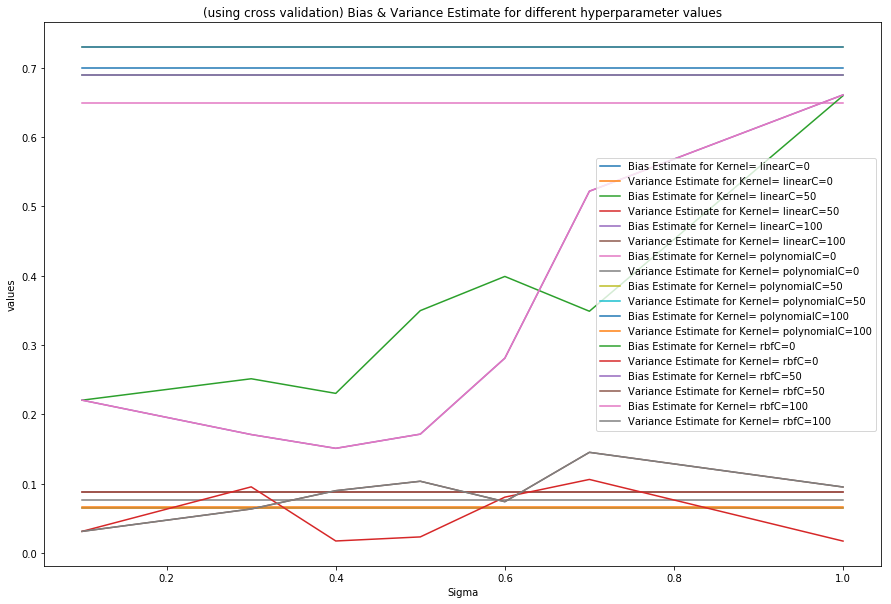

In [107]:
num_folds = 3
performCrossValidation(X1,Y1,num_folds,classifier,kernel='rbf',degree=1,sigma=0.5)

In [ ]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots()
#for i in numOfdimPlusOne:#[:-1]
#for i in lamdavalues:
#ax.plot(np.arange(0.8,0.91,0.01),crossValAvgErrorForEachLamda, label= 'Bias Estimate')
ax.plot(np.log([1e-4 ,1e-3, 1e-2, 0.1, 1, 10, 100,1000 ])/np.log(10),crossValAvgErrorForEachLamda, label= 'Variance Estimate')
ax.legend(loc=0) # upper left corner
ax.set_xlabel('log lamda')
ax.set_ylabel('values')
ax.set_title('(using 5 fold cross validation) Bias Estimate for different lamda values ');

In [133]:
from sklearn import svm
clf = svm.SVC(gamma=2, decision_function_shape='ovo',kernel='poly',degree = 2,C=100)
clf.fit(train_X_data, train_Y_data) 
predictedLabelVector = []
GivenData = train_X_data
GivenDataLabels = train_Y_data
for i in tqdm(range(0,len(GivenData))):
    predictedLabelVector.append(clf.predict(GivenData[i,:].reshape(1,train_X_data.shape[1])))
conMatrix = pd.crosstab(np.array(predictedLabelVector).ravel(),GivenDataLabels.reshape(-1,1).ravel())
conMatrix

col_0,0,1,2
row_0,,,
0,25,1,4
1,0,24,9
2,2,1,13


In [68]:
lin_clf = svm.LinearSVC()
lin_clf.kernel='poly'
lin_clf.gamma=1
lin_clf.degree=4
lin_clf.max_iter=10**5
lin_clf.fit(train_X_data, train_Y_data) 
predictedLabelVector = []
GivenData = train_X_data
GivenDataLabels = train_Y_data
for i in tqdm(range(0,len(GivenData))):
    predictedLabelVector.append(lin_clf.predict(GivenData[i,:].reshape(1,train_X_data.shape[1])))
conMatrix = pd.crosstab(np.array(predictedLabelVector).ravel(),GivenDataLabels.reshape(-1,1).ravel())
conMatrix

col_0,0,1,2
row_0,,,
0,19,1,0
1,3,20,4
2,2,3,22


In [148]:
from sklearn.datasets import load_iris
iris=load_iris()
type(iris['data'])
ran = np.random.rand(len(iris['data'])) < 0.8
train_X_data = iris['data'][ran]
train_Y_data = iris['target'][ran]
val_X_data = iris['data'][~ran]
val_Y_data = iris['target'][~ran]

In [149]:
kernel = 'rbf'
degree = 4
sigma = 0.4
C = 10

In [150]:
a1 = SMCSVM()
#a1.fit()
start_time = time.time()
a1.fit(train_X_data,train_Y_data,C,kernel,degree,sigma)
print('\n Time taken for training in seconds: ', time.time()-start_time )
predictedLabels = a1.predict(train_X_data)
conMatrix = pd.crosstab(np.array(predictedLabels).ravel(),train_Y_data.reshape(-1,1).ravel())
conMatrix


 Calculating fullXmatrix




 Calculating Kernalized Product




 Calculating Kernalized Product




 Calculating Kernalized Product



     pcost       dcost       gap    pres   dres
 0:  4.4243e+02 -5.3223e+03  1e+04  2e-01  4e-15
 1:  2.5076e+02 -5.2645e+02  9e+02  6e-03  3e-15
 2:  2.7543e+01 -7.5235e+01  1e+02  2e-16  3e-15
 3: -4.2894e+00 -1.8065e+01  1e+01  2e-16  1e-15
 4: -7.0702e+00 -8.5449e+00  1e+00  2e-16  4e-16
 5: -7.3895e+00 -7.7865e+00  4e-01  2e-16  2e-16
 6: -7.5313e+00 -7.6206e+00  9e-02  1e-16  2e-16
 7: -7.5636e+00 -7.5703e+00  7e-03  2e-16  2e-16
 8: -7.5664e+00 -7.5669e+00  5e-04  2e-16  2e-16
 9: -7.5666e+00 -7.5666e+00  2e-05  2e-16  2e-16
10: -7.5666e+00 -7.5666e+00  4e-07  2e-16  2e-16
Optimal solution found.

 Time taken for training in seconds:  1.8789141178131104

 Calculating prediction values


col_0,0,1,2
row_0,,,
0,41,0,0
1,0,39,0
2,0,0,43


fold is 0

 Calculating fullXmatrix



     pcost       dcost       gap    pres   dres
 0: -2.1068e+01 -2.6413e-01  1e+03  3e+01  5e-15
 1: -6.5738e-01 -2.4108e-01  2e+01  6e-01  4e-15
 2: -1.7368e-01 -3.9404e-02  2e+00  6e-02  1e-15
 3: -5.8928e-03 -4.5751e-05  1e-01  3e-03  2e-15
 4: -6.0516e-05 -4.7789e-09  1e-03  3e-05  1e-15
 5: -6.0521e-07 -4.7790e-13  1e-05  3e-07  1e-15
 6: -6.0521e-09 -4.7790e-17  1e-07  3e-09  1e-15
Optimal solution found.

 Calculating prediction values



fold is 1

 Calculating fullXmatrix



     pcost       dcost       gap    pres   dres
 0: -2.2048e+01 -2.0953e-01  8e+02  3e+01  4e-15
 1: -5.9585e-01 -1.9708e-01  1e+01  5e-01  4e-15
 2: -1.7940e-01 -4.2599e-02  2e+00  7e-02  8e-16
 3: -9.6116e-03 -1.2989e-04  9e-02  3e-03  2e-15
 4: -9.7977e-05 -1.3100e-08  9e-04  3e-05  2e-15
 5: -9.7990e-07 -1.3100e-12  9e-06  3e-07  1e-15
 6: -9.7990e-09 -1.3100e-16  9e-08  3e-09  2e-15
Optimal solution found.

 Calculating prediction values



fold is 2

 Calculating fullXmatrix



     pcost       dcost       gap    pres   dres
 0: -2.6971e+01 -1.8895e-01  1e+03  3e+01  6e-15
 1: -6.6842e-01 -1.7583e-01  2e+01  5e-01  5e-15
 2: -1.7277e-01 -3.9026e-02  2e+00  7e-02  9e-16
 3: -7.1657e-03 -6.8854e-05  1e-01  3e-03  1e-15
 4: -7.4368e-05 -7.3300e-09  1e-03  4e-05  1e-15
 5: -7.4375e-07 -7.3301e-13  1e-05  4e-07  1e-15
 6: -7.4375e-09 -7.3301e-17  1e-07  4e-09  1e-15
 7: -7.4375e-11 -7.3303e-21  1e-09  4e-11  1e-15
Optimal solution found.

 Calculating prediction values



fold is 0

 Calculating fullXmatrix



     pcost       dcost       gap    pres   dres
 0: -2.1068e+01 -2.6413e-01  1e+03  3e+01  5e-15
 1: -6.5738e-01 -2.4108e-01  2e+01  6e-01  4e-15
 2: -1.7368e-01 -3.9404e-02  2e+00  6e-02  1e-15
 3: -5.8928e-03 -4.5751e-05  1e-01  3e-03  2e-15
 4: -6.0516e-05 -4.7789e-09  1e-03  3e-05  1e-15
 5: -6.0521e-07 -4.7790e-13  1e-05  3e-07  1e-15
 6: -6.0521e-09 -4.7790e-17  1e-07  3e-09  1e-15
Optimal solution found.

 Calculating prediction values



fold is 1

 Calculating fullXmatrix



     pcost       dcost       gap    pres   dres
 0: -2.2048e+01 -2.0953e-01  8e+02  3e+01  4e-15
 1: -5.9585e-01 -1.9708e-01  1e+01  5e-01  4e-15
 2: -1.7940e-01 -4.2599e-02  2e+00  7e-02  8e-16
 3: -9.6116e-03 -1.2989e-04  9e-02  3e-03  2e-15
 4: -9.7977e-05 -1.3100e-08  9e-04  3e-05  2e-15
 5: -9.7990e-07 -1.3100e-12  9e-06  3e-07  1e-15
 6: -9.7990e-09 -1.3100e-16  9e-08  3e-09  2e-15
Optimal solution found.

 Calculating prediction values



fold is 2

 Calculating fullXmatrix



     pcost       dcost       gap    pres   dres
 0: -2.6971e+01 -1.8895e-01  1e+03  3e+01  6e-15
 1: -6.6842e-01 -1.7583e-01  2e+01  5e-01  5e-15
 2: -1.7277e-01 -3.9026e-02  2e+00  7e-02  9e-16
 3: -7.1657e-03 -6.8854e-05  1e-01  3e-03  1e-15
 4: -7.4368e-05 -7.3300e-09  1e-03  4e-05  1e-15
 5: -7.4375e-07 -7.3301e-13  1e-05  4e-07  1e-15
 6: -7.4375e-09 -7.3301e-17  1e-07  4e-09  1e-15
 7: -7.4375e-11 -7.3303e-21  1e-09  4e-11  1e-15
Optimal solution found.

 Calculating prediction values



fold is 0

 Calculating fullXmatrix



     pcost       dcost       gap    pres   dres
 0: -2.1068e+01 -2.6413e-01  1e+03  3e+01  5e-15
 1: -6.5738e-01 -2.4108e-01  2e+01  6e-01  4e-15
 2: -1.7368e-01 -3.9404e-02  2e+00  6e-02  1e-15
 3: -5.8928e-03 -4.5751e-05  1e-01  3e-03  2e-15
 4: -6.0516e-05 -4.7789e-09  1e-03  3e-05  1e-15
 5: -6.0521e-07 -4.7790e-13  1e-05  3e-07  1e-15
 6: -6.0521e-09 -4.7790e-17  1e-07  3e-09  1e-15
Optimal solution found.

 Calculating prediction values



fold is 1

 Calculating fullXmatrix



     pcost       dcost       gap    pres   dres
 0: -2.2048e+01 -2.0953e-01  8e+02  3e+01  4e-15
 1: -5.9585e-01 -1.9708e-01  1e+01  5e-01  4e-15
 2: -1.7940e-01 -4.2599e-02  2e+00  7e-02  8e-16
 3: -9.6116e-03 -1.2989e-04  9e-02  3e-03  2e-15
 4: -9.7977e-05 -1.3100e-08  9e-04  3e-05  2e-15
 5: -9.7990e-07 -1.3100e-12  9e-06  3e-07  1e-15
 6: -9.7990e-09 -1.3100e-16  9e-08  3e-09  2e-15
Optimal solution found.

 Calculating prediction values



fold is 2

 Calculating fullXmatrix



     pcost       dcost       gap    pres   dres
 0: -2.6971e+01 -1.8895e-01  1e+03  3e+01  6e-15
 1: -6.6842e-01 -1.7583e-01  2e+01  5e-01  5e-15
 2: -1.7277e-01 -3.9026e-02  2e+00  7e-02  9e-16
 3: -7.1657e-03 -6.8854e-05  1e-01  3e-03  1e-15
 4: -7.4368e-05 -7.3300e-09  1e-03  4e-05  1e-15
 5: -7.4375e-07 -7.3301e-13  1e-05  4e-07  1e-15
 6: -7.4375e-09 -7.3301e-17  1e-07  4e-09  1e-15
 7: -7.4375e-11 -7.3303e-21  1e-09  4e-11  1e-15
Optimal solution found.

 Calculating prediction values



fold is 0

 Calculating fullXmatrix



     pcost       dcost       gap    pres   dres
 0: -2.1068e+01 -2.6413e-01  1e+03  3e+01  5e-15
 1: -6.5738e-01 -2.4108e-01  2e+01  6e-01  4e-15
 2: -1.7368e-01 -3.9404e-02  2e+00  6e-02  1e-15
 3: -5.8928e-03 -4.5751e-05  1e-01  3e-03  2e-15
 4: -6.0516e-05 -4.7789e-09  1e-03  3e-05  1e-15
 5: -6.0521e-07 -4.7790e-13  1e-05  3e-07  1e-15
 6: -6.0521e-09 -4.7790e-17  1e-07  3e-09  1e-15
Optimal solution found.

 Calculating prediction values



fold is 1

 Calculating fullXmatrix



     pcost       dcost       gap    pres   dres
 0: -2.2048e+01 -2.0953e-01  8e+02  3e+01  4e-15
 1: -5.9585e-01 -1.9708e-01  1e+01  5e-01  4e-15
 2: -1.7940e-01 -4.2599e-02  2e+00  7e-02  8e-16
 3: -9.6116e-03 -1.2989e-04  9e-02  3e-03  2e-15
 4: -9.7977e-05 -1.3100e-08  9e-04  3e-05  2e-15
 5: -9.7990e-07 -1.3100e-12  9e-06  3e-07  1e-15
 6: -9.7990e-09 -1.3100e-16  9e-08  3e-09  2e-15
Optimal solution found.

 Calculating prediction values



fold is 2

 Calculating fullXmatrix



     pcost       dcost       gap    pres   dres
 0: -2.6971e+01 -1.8895e-01  1e+03  3e+01  6e-15
 1: -6.6842e-01 -1.7583e-01  2e+01  5e-01  5e-15
 2: -1.7277e-01 -3.9026e-02  2e+00  7e-02  9e-16
 3: -7.1657e-03 -6.8854e-05  1e-01  3e-03  1e-15
 4: -7.4368e-05 -7.3300e-09  1e-03  4e-05  1e-15
 5: -7.4375e-07 -7.3301e-13  1e-05  4e-07  1e-15
 6: -7.4375e-09 -7.3301e-17  1e-07  4e-09  1e-15
 7: -7.4375e-11 -7.3303e-21  1e-09  4e-11  1e-15
Optimal solution found.

 Calculating prediction values



fold is 0

 Calculating fullXmatrix



     pcost       dcost       gap    pres   dres
 0: -2.1068e+01 -2.6413e-01  1e+03  3e+01  5e-15
 1: -6.5738e-01 -2.4108e-01  2e+01  6e-01  4e-15
 2: -1.7368e-01 -3.9404e-02  2e+00  6e-02  1e-15
 3: -5.8928e-03 -4.5751e-05  1e-01  3e-03  2e-15
 4: -6.0516e-05 -4.7789e-09  1e-03  3e-05  1e-15
 5: -6.0521e-07 -4.7790e-13  1e-05  3e-07  1e-15
 6: -6.0521e-09 -4.7790e-17  1e-07  3e-09  1e-15
Optimal solution found.

 Calculating prediction values



fold is 1

 Calculating fullXmatrix



     pcost       dcost       gap    pres   dres
 0: -2.2048e+01 -2.0953e-01  8e+02  3e+01  4e-15
 1: -5.9585e-01 -1.9708e-01  1e+01  5e-01  4e-15
 2: -1.7940e-01 -4.2599e-02  2e+00  7e-02  8e-16
 3: -9.6116e-03 -1.2989e-04  9e-02  3e-03  2e-15
 4: -9.7977e-05 -1.3100e-08  9e-04  3e-05  2e-15
 5: -9.7990e-07 -1.3100e-12  9e-06  3e-07  1e-15
 6: -9.7990e-09 -1.3100e-16  9e-08  3e-09  2e-15
Optimal solution found.

 Calculating prediction values



fold is 2

 Calculating fullXmatrix



     pcost       dcost       gap    pres   dres
 0: -2.6971e+01 -1.8895e-01  1e+03  3e+01  6e-15
 1: -6.6842e-01 -1.7583e-01  2e+01  5e-01  5e-15
 2: -1.7277e-01 -3.9026e-02  2e+00  7e-02  9e-16
 3: -7.1657e-03 -6.8854e-05  1e-01  3e-03  1e-15
 4: -7.4368e-05 -7.3300e-09  1e-03  4e-05  1e-15
 5: -7.4375e-07 -7.3301e-13  1e-05  4e-07  1e-15
 6: -7.4375e-09 -7.3301e-17  1e-07  4e-09  1e-15
 7: -7.4375e-11 -7.3303e-21  1e-09  4e-11  1e-15
Optimal solution found.

 Calculating prediction values



fold is 0

 Calculating fullXmatrix



     pcost       dcost       gap    pres   dres
 0: -2.1068e+01 -2.6413e-01  1e+03  3e+01  5e-15
 1: -6.5738e-01 -2.4108e-01  2e+01  6e-01  4e-15
 2: -1.7368e-01 -3.9404e-02  2e+00  6e-02  1e-15
 3: -5.8928e-03 -4.5751e-05  1e-01  3e-03  2e-15
 4: -6.0516e-05 -4.7789e-09  1e-03  3e-05  1e-15
 5: -6.0521e-07 -4.7790e-13  1e-05  3e-07  1e-15
 6: -6.0521e-09 -4.7790e-17  1e-07  3e-09  1e-15
Optimal solution found.

 Calculating prediction values



fold is 1

 Calculating fullXmatrix



     pcost       dcost       gap    pres   dres
 0: -2.2048e+01 -2.0953e-01  8e+02  3e+01  4e-15
 1: -5.9585e-01 -1.9708e-01  1e+01  5e-01  4e-15
 2: -1.7940e-01 -4.2599e-02  2e+00  7e-02  8e-16
 3: -9.6116e-03 -1.2989e-04  9e-02  3e-03  2e-15
 4: -9.7977e-05 -1.3100e-08  9e-04  3e-05  2e-15
 5: -9.7990e-07 -1.3100e-12  9e-06  3e-07  1e-15
 6: -9.7990e-09 -1.3100e-16  9e-08  3e-09  2e-15
Optimal solution found.

 Calculating prediction values



fold is 2

 Calculating fullXmatrix



     pcost       dcost       gap    pres   dres
 0: -2.6971e+01 -1.8895e-01  1e+03  3e+01  6e-15
 1: -6.6842e-01 -1.7583e-01  2e+01  5e-01  5e-15
 2: -1.7277e-01 -3.9026e-02  2e+00  7e-02  9e-16
 3: -7.1657e-03 -6.8854e-05  1e-01  3e-03  1e-15
 4: -7.4368e-05 -7.3300e-09  1e-03  4e-05  1e-15
 5: -7.4375e-07 -7.3301e-13  1e-05  4e-07  1e-15
 6: -7.4375e-09 -7.3301e-17  1e-07  4e-09  1e-15
 7: -7.4375e-11 -7.3303e-21  1e-09  4e-11  1e-15
Optimal solution found.

 Calculating prediction values



fold is 0

 Calculating fullXmatrix



     pcost       dcost       gap    pres   dres
 0: -2.1068e+01 -2.6413e-01  1e+03  3e+01  5e-15
 1: -6.5738e-01 -2.4108e-01  2e+01  6e-01  4e-15
 2: -1.7368e-01 -3.9404e-02  2e+00  6e-02  1e-15
 3: -5.8928e-03 -4.5751e-05  1e-01  3e-03  2e-15
 4: -6.0516e-05 -4.7789e-09  1e-03  3e-05  1e-15
 5: -6.0521e-07 -4.7790e-13  1e-05  3e-07  1e-15
 6: -6.0521e-09 -4.7790e-17  1e-07  3e-09  1e-15
Optimal solution found.

 Calculating prediction values



fold is 1

 Calculating fullXmatrix



     pcost       dcost       gap    pres   dres
 0: -2.2048e+01 -2.0953e-01  8e+02  3e+01  4e-15
 1: -5.9585e-01 -1.9708e-01  1e+01  5e-01  4e-15
 2: -1.7940e-01 -4.2599e-02  2e+00  7e-02  8e-16
 3: -9.6116e-03 -1.2989e-04  9e-02  3e-03  2e-15
 4: -9.7977e-05 -1.3100e-08  9e-04  3e-05  2e-15
 5: -9.7990e-07 -1.3100e-12  9e-06  3e-07  1e-15
 6: -9.7990e-09 -1.3100e-16  9e-08  3e-09  2e-15
Optimal solution found.

 Calculating prediction values



fold is 2

 Calculating fullXmatrix



     pcost       dcost       gap    pres   dres
 0: -2.6971e+01 -1.8895e-01  1e+03  3e+01  6e-15
 1: -6.6842e-01 -1.7583e-01  2e+01  5e-01  5e-15
 2: -1.7277e-01 -3.9026e-02  2e+00  7e-02  9e-16
 3: -7.1657e-03 -6.8854e-05  1e-01  3e-03  1e-15
 4: -7.4368e-05 -7.3300e-09  1e-03  4e-05  1e-15
 5: -7.4375e-07 -7.3301e-13  1e-05  4e-07  1e-15
 6: -7.4375e-09 -7.3301e-17  1e-07  4e-09  1e-15
 7: -7.4375e-11 -7.3303e-21  1e-09  4e-11  1e-15
Optimal solution found.

 Calculating prediction values



fold is 0

 Calculating fullXmatrix



     pcost       dcost       gap    pres   dres
 0: -4.0095e+02 -2.5295e+05  7e+05  8e-01  2e-13
 1:  8.0206e+02 -9.2255e+04  1e+05  1e-01  2e-13
 2:  4.5126e+02 -2.4126e+04  3e+04  2e-02  1e-13
 3: -3.0936e+02 -6.2965e+03  6e+03  4e-03  8e-14
 4: -5.9688e+02 -2.1486e+03  2e+03  9e-04  6e-14
 5: -7.1513e+02 -1.9109e+03  1e+03  6e-04  8e-14
 6: -7.8830e+02 -1.4616e+03  7e+02  3e-04  1e-13
 7: -8.6389e+02 -1.2469e+03  4e+02  4e-05  9e-14
 8: -8.8620e+02 -1.0899e+03  2e+02  2e-05  8e-14
 9: -9.1243e+02 -1.0782e+03  2e+02  7e-06  1e-13
10: -9.4840e+02 -1.0039e+03  6e+01  2e-06  1e-13
11: -9.6549e+02 -9.7522e+02  1e+01  2e-07  1e-13
12: -9.6754e+02 -9.7223e+02  5e+00  1e-07  1e-13
13: -9.6868e+02 -9.6998e+02  1e+00  4e-09  1e-13
14: -9.6929e+02 -9.6930e+02  2e-02  4e-11  1e-13
15: -9.6930e+02 -9.6930e+02  2e-04  4e-13  1e-13
Optimal solution found.

 Calculating prediction values



fold is 1

 Calculating fullXmatrix



     pcost       dcost       gap    pres   dres
 0: -5.9015e+02 -2.2026e+05  5e+05  7e-01  2e-13
 1:  6.6943e+02 -7.0146e+04  1e+05  1e-01  2e-13
 2:  6.2118e+02 -1.5962e+04  2e+04  2e-02  1e-13
 3: -1.9534e+02 -4.0652e+03  4e+03  1e-03  6e-14
 4: -5.0129e+02 -2.2402e+03  2e+03  3e-04  6e-14
 5: -6.1715e+02 -1.5800e+03  1e+03  1e-04  6e-14
 6: -6.6982e+02 -1.2118e+03  5e+02  2e-16  7e-14
 7: -7.2263e+02 -1.0936e+03  4e+02  2e-16  7e-14
 8: -7.6741e+02 -9.5091e+02  2e+02  2e-16  8e-14
 9: -7.8859e+02 -8.8276e+02  9e+01  2e-16  8e-14
10: -8.1286e+02 -8.4126e+02  3e+01  2e-16  8e-14
11: -8.2038e+02 -8.2356e+02  3e+00  2e-16  1e-13
12: -8.2166e+02 -8.2176e+02  1e-01  2e-16  9e-14
13: -8.2169e+02 -8.2170e+02  1e-03  2e-16  1e-13
14: -8.2170e+02 -8.2170e+02  1e-05  2e-16  1e-13
Optimal solution found.

 Calculating prediction values



fold is 2

 Calculating fullXmatrix



     pcost       dcost       gap    pres   dres
 0: -8.9372e+02 -2.9823e+05  8e+05  1e+00  3e-13
 1:  5.2303e+02 -1.2425e+05  2e+05  2e-01  2e-13
 2:  6.3662e+02 -2.8317e+04  4e+04  3e-02  1e-13
 3: -4.4873e+02 -6.1013e+03  6e+03  3e-03  9e-14
 4: -7.4730e+02 -2.2829e+03  2e+03  5e-04  9e-14
 5: -8.2086e+02 -1.8212e+03  1e+03  3e-04  8e-14
 6: -9.0999e+02 -1.6352e+03  7e+02  2e-04  8e-14
 7: -1.0004e+03 -1.3340e+03  3e+02  4e-05  1e-13
 8: -1.0473e+03 -1.2395e+03  2e+02  1e-05  1e-13
 9: -1.0753e+03 -1.1927e+03  1e+02  7e-06  1e-13
10: -1.1033e+03 -1.1467e+03  4e+01  9e-07  1e-13
11: -1.1174e+03 -1.1262e+03  9e+00  2e-16  1e-13
12: -1.1209e+03 -1.1220e+03  1e+00  2e-16  1e-13
13: -1.1213e+03 -1.1215e+03  2e-01  2e-16  1e-13
14: -1.1214e+03 -1.1214e+03  2e-03  2e-16  1e-13
15: -1.1214e+03 -1.1214e+03  2e-05  2e-16  1e-13
Optimal solution found.

 Calculating prediction values



fold is 0

 Calculating fullXmatrix



     pcost       dcost       gap    pres   dres
 0: -4.0095e+02 -2.5295e+05  7e+05  8e-01  2e-13
 1:  8.0206e+02 -9.2255e+04  1e+05  1e-01  2e-13
 2:  4.5126e+02 -2.4126e+04  3e+04  2e-02  1e-13
 3: -3.0936e+02 -6.2965e+03  6e+03  4e-03  8e-14
 4: -5.9688e+02 -2.1486e+03  2e+03  9e-04  6e-14
 5: -7.1513e+02 -1.9109e+03  1e+03  6e-04  8e-14
 6: -7.8830e+02 -1.4616e+03  7e+02  3e-04  1e-13
 7: -8.6389e+02 -1.2469e+03  4e+02  4e-05  9e-14
 8: -8.8620e+02 -1.0899e+03  2e+02  2e-05  8e-14
 9: -9.1243e+02 -1.0782e+03  2e+02  7e-06  1e-13
10: -9.4840e+02 -1.0039e+03  6e+01  2e-06  1e-13
11: -9.6549e+02 -9.7522e+02  1e+01  2e-07  1e-13
12: -9.6754e+02 -9.7223e+02  5e+00  1e-07  1e-13
13: -9.6868e+02 -9.6998e+02  1e+00  4e-09  1e-13
14: -9.6929e+02 -9.6930e+02  2e-02  4e-11  1e-13
15: -9.6930e+02 -9.6930e+02  2e-04  4e-13  1e-13
Optimal solution found.

 Calculating prediction values



fold is 1

 Calculating fullXmatrix



     pcost       dcost       gap    pres   dres
 0: -5.9015e+02 -2.2026e+05  5e+05  7e-01  2e-13
 1:  6.6943e+02 -7.0146e+04  1e+05  1e-01  2e-13
 2:  6.2118e+02 -1.5962e+04  2e+04  2e-02  1e-13
 3: -1.9534e+02 -4.0652e+03  4e+03  1e-03  6e-14
 4: -5.0129e+02 -2.2402e+03  2e+03  3e-04  6e-14
 5: -6.1715e+02 -1.5800e+03  1e+03  1e-04  6e-14
 6: -6.6982e+02 -1.2118e+03  5e+02  2e-16  7e-14
 7: -7.2263e+02 -1.0936e+03  4e+02  2e-16  7e-14
 8: -7.6741e+02 -9.5091e+02  2e+02  2e-16  8e-14
 9: -7.8859e+02 -8.8276e+02  9e+01  2e-16  8e-14
10: -8.1286e+02 -8.4126e+02  3e+01  2e-16  8e-14
11: -8.2038e+02 -8.2356e+02  3e+00  2e-16  1e-13
12: -8.2166e+02 -8.2176e+02  1e-01  2e-16  9e-14
13: -8.2169e+02 -8.2170e+02  1e-03  2e-16  1e-13
14: -8.2170e+02 -8.2170e+02  1e-05  2e-16  1e-13
Optimal solution found.

 Calculating prediction values



fold is 2

 Calculating fullXmatrix



     pcost       dcost       gap    pres   dres
 0: -8.9372e+02 -2.9823e+05  8e+05  1e+00  3e-13
 1:  5.2303e+02 -1.2425e+05  2e+05  2e-01  2e-13
 2:  6.3662e+02 -2.8317e+04  4e+04  3e-02  1e-13
 3: -4.4873e+02 -6.1013e+03  6e+03  3e-03  9e-14
 4: -7.4730e+02 -2.2829e+03  2e+03  5e-04  9e-14
 5: -8.2086e+02 -1.8212e+03  1e+03  3e-04  8e-14
 6: -9.0999e+02 -1.6352e+03  7e+02  2e-04  8e-14
 7: -1.0004e+03 -1.3340e+03  3e+02  4e-05  1e-13
 8: -1.0473e+03 -1.2395e+03  2e+02  1e-05  1e-13
 9: -1.0753e+03 -1.1927e+03  1e+02  7e-06  1e-13
10: -1.1033e+03 -1.1467e+03  4e+01  9e-07  1e-13
11: -1.1174e+03 -1.1262e+03  9e+00  2e-16  1e-13
12: -1.1209e+03 -1.1220e+03  1e+00  2e-16  1e-13
13: -1.1213e+03 -1.1215e+03  2e-01  2e-16  1e-13
14: -1.1214e+03 -1.1214e+03  2e-03  2e-16  1e-13
15: -1.1214e+03 -1.1214e+03  2e-05  2e-16  1e-13
Optimal solution found.

 Calculating prediction values



fold is 0

 Calculating fullXmatrix



     pcost       dcost       gap    pres   dres
 0: -4.0095e+02 -2.5295e+05  7e+05  8e-01  2e-13
 1:  8.0206e+02 -9.2255e+04  1e+05  1e-01  2e-13
 2:  4.5126e+02 -2.4126e+04  3e+04  2e-02  1e-13
 3: -3.0936e+02 -6.2965e+03  6e+03  4e-03  8e-14
 4: -5.9688e+02 -2.1486e+03  2e+03  9e-04  6e-14
 5: -7.1513e+02 -1.9109e+03  1e+03  6e-04  8e-14
 6: -7.8830e+02 -1.4616e+03  7e+02  3e-04  1e-13
 7: -8.6389e+02 -1.2469e+03  4e+02  4e-05  9e-14
 8: -8.8620e+02 -1.0899e+03  2e+02  2e-05  8e-14
 9: -9.1243e+02 -1.0782e+03  2e+02  7e-06  1e-13
10: -9.4840e+02 -1.0039e+03  6e+01  2e-06  1e-13
11: -9.6549e+02 -9.7522e+02  1e+01  2e-07  1e-13
12: -9.6754e+02 -9.7223e+02  5e+00  1e-07  1e-13
13: -9.6868e+02 -9.6998e+02  1e+00  4e-09  1e-13
14: -9.6929e+02 -9.6930e+02  2e-02  4e-11  1e-13
15: -9.6930e+02 -9.6930e+02  2e-04  4e-13  1e-13
Optimal solution found.

 Calculating prediction values



fold is 1

 Calculating fullXmatrix



     pcost       dcost       gap    pres   dres
 0: -5.9015e+02 -2.2026e+05  5e+05  7e-01  2e-13
 1:  6.6943e+02 -7.0146e+04  1e+05  1e-01  2e-13
 2:  6.2118e+02 -1.5962e+04  2e+04  2e-02  1e-13
 3: -1.9534e+02 -4.0652e+03  4e+03  1e-03  6e-14
 4: -5.0129e+02 -2.2402e+03  2e+03  3e-04  6e-14
 5: -6.1715e+02 -1.5800e+03  1e+03  1e-04  6e-14
 6: -6.6982e+02 -1.2118e+03  5e+02  2e-16  7e-14
 7: -7.2263e+02 -1.0936e+03  4e+02  2e-16  7e-14
 8: -7.6741e+02 -9.5091e+02  2e+02  2e-16  8e-14
 9: -7.8859e+02 -8.8276e+02  9e+01  2e-16  8e-14
10: -8.1286e+02 -8.4126e+02  3e+01  2e-16  8e-14
11: -8.2038e+02 -8.2356e+02  3e+00  2e-16  1e-13
12: -8.2166e+02 -8.2176e+02  1e-01  2e-16  9e-14
13: -8.2169e+02 -8.2170e+02  1e-03  2e-16  1e-13
14: -8.2170e+02 -8.2170e+02  1e-05  2e-16  1e-13
Optimal solution found.

 Calculating prediction values



fold is 2

 Calculating fullXmatrix



     pcost       dcost       gap    pres   dres
 0: -8.9372e+02 -2.9823e+05  8e+05  1e+00  3e-13
 1:  5.2303e+02 -1.2425e+05  2e+05  2e-01  2e-13
 2:  6.3662e+02 -2.8317e+04  4e+04  3e-02  1e-13
 3: -4.4873e+02 -6.1013e+03  6e+03  3e-03  9e-14
 4: -7.4730e+02 -2.2829e+03  2e+03  5e-04  9e-14
 5: -8.2086e+02 -1.8212e+03  1e+03  3e-04  8e-14
 6: -9.0999e+02 -1.6352e+03  7e+02  2e-04  8e-14
 7: -1.0004e+03 -1.3340e+03  3e+02  4e-05  1e-13
 8: -1.0473e+03 -1.2395e+03  2e+02  1e-05  1e-13
 9: -1.0753e+03 -1.1927e+03  1e+02  7e-06  1e-13
10: -1.1033e+03 -1.1467e+03  4e+01  9e-07  1e-13
11: -1.1174e+03 -1.1262e+03  9e+00  2e-16  1e-13
12: -1.1209e+03 -1.1220e+03  1e+00  2e-16  1e-13
13: -1.1213e+03 -1.1215e+03  2e-01  2e-16  1e-13
14: -1.1214e+03 -1.1214e+03  2e-03  2e-16  1e-13
15: -1.1214e+03 -1.1214e+03  2e-05  2e-16  1e-13
Optimal solution found.

 Calculating prediction values



fold is 0

 Calculating fullXmatrix



     pcost       dcost       gap    pres   dres
 0: -4.0095e+02 -2.5295e+05  7e+05  8e-01  2e-13
 1:  8.0206e+02 -9.2255e+04  1e+05  1e-01  2e-13
 2:  4.5126e+02 -2.4126e+04  3e+04  2e-02  1e-13
 3: -3.0936e+02 -6.2965e+03  6e+03  4e-03  8e-14
 4: -5.9688e+02 -2.1486e+03  2e+03  9e-04  6e-14
 5: -7.1513e+02 -1.9109e+03  1e+03  6e-04  8e-14
 6: -7.8830e+02 -1.4616e+03  7e+02  3e-04  1e-13
 7: -8.6389e+02 -1.2469e+03  4e+02  4e-05  9e-14
 8: -8.8620e+02 -1.0899e+03  2e+02  2e-05  8e-14
 9: -9.1243e+02 -1.0782e+03  2e+02  7e-06  1e-13
10: -9.4840e+02 -1.0039e+03  6e+01  2e-06  1e-13
11: -9.6549e+02 -9.7522e+02  1e+01  2e-07  1e-13
12: -9.6754e+02 -9.7223e+02  5e+00  1e-07  1e-13
13: -9.6868e+02 -9.6998e+02  1e+00  4e-09  1e-13
14: -9.6929e+02 -9.6930e+02  2e-02  4e-11  1e-13
15: -9.6930e+02 -9.6930e+02  2e-04  4e-13  1e-13
Optimal solution found.

 Calculating prediction values



fold is 1

 Calculating fullXmatrix



     pcost       dcost       gap    pres   dres
 0: -5.9015e+02 -2.2026e+05  5e+05  7e-01  2e-13
 1:  6.6943e+02 -7.0146e+04  1e+05  1e-01  2e-13
 2:  6.2118e+02 -1.5962e+04  2e+04  2e-02  1e-13
 3: -1.9534e+02 -4.0652e+03  4e+03  1e-03  6e-14
 4: -5.0129e+02 -2.2402e+03  2e+03  3e-04  6e-14
 5: -6.1715e+02 -1.5800e+03  1e+03  1e-04  6e-14
 6: -6.6982e+02 -1.2118e+03  5e+02  2e-16  7e-14
 7: -7.2263e+02 -1.0936e+03  4e+02  2e-16  7e-14
 8: -7.6741e+02 -9.5091e+02  2e+02  2e-16  8e-14
 9: -7.8859e+02 -8.8276e+02  9e+01  2e-16  8e-14
10: -8.1286e+02 -8.4126e+02  3e+01  2e-16  8e-14
11: -8.2038e+02 -8.2356e+02  3e+00  2e-16  1e-13
12: -8.2166e+02 -8.2176e+02  1e-01  2e-16  9e-14
13: -8.2169e+02 -8.2170e+02  1e-03  2e-16  1e-13
14: -8.2170e+02 -8.2170e+02  1e-05  2e-16  1e-13
Optimal solution found.

 Calculating prediction values



fold is 2

 Calculating fullXmatrix



     pcost       dcost       gap    pres   dres
 0: -8.9372e+02 -2.9823e+05  8e+05  1e+00  3e-13
 1:  5.2303e+02 -1.2425e+05  2e+05  2e-01  2e-13
 2:  6.3662e+02 -2.8317e+04  4e+04  3e-02  1e-13
 3: -4.4873e+02 -6.1013e+03  6e+03  3e-03  9e-14
 4: -7.4730e+02 -2.2829e+03  2e+03  5e-04  9e-14
 5: -8.2086e+02 -1.8212e+03  1e+03  3e-04  8e-14
 6: -9.0999e+02 -1.6352e+03  7e+02  2e-04  8e-14
 7: -1.0004e+03 -1.3340e+03  3e+02  4e-05  1e-13
 8: -1.0473e+03 -1.2395e+03  2e+02  1e-05  1e-13
 9: -1.0753e+03 -1.1927e+03  1e+02  7e-06  1e-13
10: -1.1033e+03 -1.1467e+03  4e+01  9e-07  1e-13
11: -1.1174e+03 -1.1262e+03  9e+00  2e-16  1e-13
12: -1.1209e+03 -1.1220e+03  1e+00  2e-16  1e-13
13: -1.1213e+03 -1.1215e+03  2e-01  2e-16  1e-13
14: -1.1214e+03 -1.1214e+03  2e-03  2e-16  1e-13
15: -1.1214e+03 -1.1214e+03  2e-05  2e-16  1e-13
Optimal solution found.

 Calculating prediction values



fold is 0

 Calculating fullXmatrix



     pcost       dcost       gap    pres   dres
 0: -4.0095e+02 -2.5295e+05  7e+05  8e-01  2e-13
 1:  8.0206e+02 -9.2255e+04  1e+05  1e-01  2e-13
 2:  4.5126e+02 -2.4126e+04  3e+04  2e-02  1e-13
 3: -3.0936e+02 -6.2965e+03  6e+03  4e-03  8e-14
 4: -5.9688e+02 -2.1486e+03  2e+03  9e-04  6e-14
 5: -7.1513e+02 -1.9109e+03  1e+03  6e-04  8e-14
 6: -7.8830e+02 -1.4616e+03  7e+02  3e-04  1e-13
 7: -8.6389e+02 -1.2469e+03  4e+02  4e-05  9e-14
 8: -8.8620e+02 -1.0899e+03  2e+02  2e-05  8e-14
 9: -9.1243e+02 -1.0782e+03  2e+02  7e-06  1e-13
10: -9.4840e+02 -1.0039e+03  6e+01  2e-06  1e-13
11: -9.6549e+02 -9.7522e+02  1e+01  2e-07  1e-13
12: -9.6754e+02 -9.7223e+02  5e+00  1e-07  1e-13
13: -9.6868e+02 -9.6998e+02  1e+00  4e-09  1e-13
14: -9.6929e+02 -9.6930e+02  2e-02  4e-11  1e-13
15: -9.6930e+02 -9.6930e+02  2e-04  4e-13  1e-13
Optimal solution found.

 Calculating prediction values



fold is 1

 Calculating fullXmatrix



     pcost       dcost       gap    pres   dres
 0: -5.9015e+02 -2.2026e+05  5e+05  7e-01  2e-13
 1:  6.6943e+02 -7.0146e+04  1e+05  1e-01  2e-13
 2:  6.2118e+02 -1.5962e+04  2e+04  2e-02  1e-13
 3: -1.9534e+02 -4.0652e+03  4e+03  1e-03  6e-14
 4: -5.0129e+02 -2.2402e+03  2e+03  3e-04  6e-14
 5: -6.1715e+02 -1.5800e+03  1e+03  1e-04  6e-14
 6: -6.6982e+02 -1.2118e+03  5e+02  2e-16  7e-14
 7: -7.2263e+02 -1.0936e+03  4e+02  2e-16  7e-14
 8: -7.6741e+02 -9.5091e+02  2e+02  2e-16  8e-14
 9: -7.8859e+02 -8.8276e+02  9e+01  2e-16  8e-14
10: -8.1286e+02 -8.4126e+02  3e+01  2e-16  8e-14
11: -8.2038e+02 -8.2356e+02  3e+00  2e-16  1e-13
12: -8.2166e+02 -8.2176e+02  1e-01  2e-16  9e-14
13: -8.2169e+02 -8.2170e+02  1e-03  2e-16  1e-13
14: -8.2170e+02 -8.2170e+02  1e-05  2e-16  1e-13
Optimal solution found.

 Calculating prediction values



fold is 2

 Calculating fullXmatrix



     pcost       dcost       gap    pres   dres
 0: -8.9372e+02 -2.9823e+05  8e+05  1e+00  3e-13
 1:  5.2303e+02 -1.2425e+05  2e+05  2e-01  2e-13
 2:  6.3662e+02 -2.8317e+04  4e+04  3e-02  1e-13
 3: -4.4873e+02 -6.1013e+03  6e+03  3e-03  9e-14
 4: -7.4730e+02 -2.2829e+03  2e+03  5e-04  9e-14
 5: -8.2086e+02 -1.8212e+03  1e+03  3e-04  8e-14
 6: -9.0999e+02 -1.6352e+03  7e+02  2e-04  8e-14
 7: -1.0004e+03 -1.3340e+03  3e+02  4e-05  1e-13
 8: -1.0473e+03 -1.2395e+03  2e+02  1e-05  1e-13
 9: -1.0753e+03 -1.1927e+03  1e+02  7e-06  1e-13
10: -1.1033e+03 -1.1467e+03  4e+01  9e-07  1e-13
11: -1.1174e+03 -1.1262e+03  9e+00  2e-16  1e-13
12: -1.1209e+03 -1.1220e+03  1e+00  2e-16  1e-13
13: -1.1213e+03 -1.1215e+03  2e-01  2e-16  1e-13
14: -1.1214e+03 -1.1214e+03  2e-03  2e-16  1e-13
15: -1.1214e+03 -1.1214e+03  2e-05  2e-16  1e-13
Optimal solution found.

 Calculating prediction values



fold is 0

 Calculating fullXmatrix



     pcost       dcost       gap    pres   dres
 0: -4.0095e+02 -2.5295e+05  7e+05  8e-01  2e-13
 1:  8.0206e+02 -9.2255e+04  1e+05  1e-01  2e-13
 2:  4.5126e+02 -2.4126e+04  3e+04  2e-02  1e-13
 3: -3.0936e+02 -6.2965e+03  6e+03  4e-03  8e-14
 4: -5.9688e+02 -2.1486e+03  2e+03  9e-04  6e-14
 5: -7.1513e+02 -1.9109e+03  1e+03  6e-04  8e-14
 6: -7.8830e+02 -1.4616e+03  7e+02  3e-04  1e-13
 7: -8.6389e+02 -1.2469e+03  4e+02  4e-05  9e-14
 8: -8.8620e+02 -1.0899e+03  2e+02  2e-05  8e-14
 9: -9.1243e+02 -1.0782e+03  2e+02  7e-06  1e-13
10: -9.4840e+02 -1.0039e+03  6e+01  2e-06  1e-13
11: -9.6549e+02 -9.7522e+02  1e+01  2e-07  1e-13
12: -9.6754e+02 -9.7223e+02  5e+00  1e-07  1e-13
13: -9.6868e+02 -9.6998e+02  1e+00  4e-09  1e-13
14: -9.6929e+02 -9.6930e+02  2e-02  4e-11  1e-13
15: -9.6930e+02 -9.6930e+02  2e-04  4e-13  1e-13
Optimal solution found.

 Calculating prediction values



fold is 1

 Calculating fullXmatrix



     pcost       dcost       gap    pres   dres
 0: -5.9015e+02 -2.2026e+05  5e+05  7e-01  2e-13
 1:  6.6943e+02 -7.0146e+04  1e+05  1e-01  2e-13
 2:  6.2118e+02 -1.5962e+04  2e+04  2e-02  1e-13
 3: -1.9534e+02 -4.0652e+03  4e+03  1e-03  6e-14
 4: -5.0129e+02 -2.2402e+03  2e+03  3e-04  6e-14
 5: -6.1715e+02 -1.5800e+03  1e+03  1e-04  6e-14
 6: -6.6982e+02 -1.2118e+03  5e+02  2e-16  7e-14
 7: -7.2263e+02 -1.0936e+03  4e+02  2e-16  7e-14
 8: -7.6741e+02 -9.5091e+02  2e+02  2e-16  8e-14
 9: -7.8859e+02 -8.8276e+02  9e+01  2e-16  8e-14
10: -8.1286e+02 -8.4126e+02  3e+01  2e-16  8e-14
11: -8.2038e+02 -8.2356e+02  3e+00  2e-16  1e-13
12: -8.2166e+02 -8.2176e+02  1e-01  2e-16  9e-14
13: -8.2169e+02 -8.2170e+02  1e-03  2e-16  1e-13
14: -8.2170e+02 -8.2170e+02  1e-05  2e-16  1e-13
Optimal solution found.

 Calculating prediction values



fold is 2

 Calculating fullXmatrix



     pcost       dcost       gap    pres   dres
 0: -8.9372e+02 -2.9823e+05  8e+05  1e+00  3e-13
 1:  5.2303e+02 -1.2425e+05  2e+05  2e-01  2e-13
 2:  6.3662e+02 -2.8317e+04  4e+04  3e-02  1e-13
 3: -4.4873e+02 -6.1013e+03  6e+03  3e-03  9e-14
 4: -7.4730e+02 -2.2829e+03  2e+03  5e-04  9e-14
 5: -8.2086e+02 -1.8212e+03  1e+03  3e-04  8e-14
 6: -9.0999e+02 -1.6352e+03  7e+02  2e-04  8e-14
 7: -1.0004e+03 -1.3340e+03  3e+02  4e-05  1e-13
 8: -1.0473e+03 -1.2395e+03  2e+02  1e-05  1e-13
 9: -1.0753e+03 -1.1927e+03  1e+02  7e-06  1e-13
10: -1.1033e+03 -1.1467e+03  4e+01  9e-07  1e-13
11: -1.1174e+03 -1.1262e+03  9e+00  2e-16  1e-13
12: -1.1209e+03 -1.1220e+03  1e+00  2e-16  1e-13
13: -1.1213e+03 -1.1215e+03  2e-01  2e-16  1e-13
14: -1.1214e+03 -1.1214e+03  2e-03  2e-16  1e-13
15: -1.1214e+03 -1.1214e+03  2e-05  2e-16  1e-13
Optimal solution found.

 Calculating prediction values



fold is 0

 Calculating fullXmatrix



     pcost       dcost       gap    pres   dres
 0: -4.0095e+02 -2.5295e+05  7e+05  8e-01  2e-13
 1:  8.0206e+02 -9.2255e+04  1e+05  1e-01  2e-13
 2:  4.5126e+02 -2.4126e+04  3e+04  2e-02  1e-13
 3: -3.0936e+02 -6.2965e+03  6e+03  4e-03  8e-14
 4: -5.9688e+02 -2.1486e+03  2e+03  9e-04  6e-14
 5: -7.1513e+02 -1.9109e+03  1e+03  6e-04  8e-14
 6: -7.8830e+02 -1.4616e+03  7e+02  3e-04  1e-13
 7: -8.6389e+02 -1.2469e+03  4e+02  4e-05  9e-14
 8: -8.8620e+02 -1.0899e+03  2e+02  2e-05  8e-14
 9: -9.1243e+02 -1.0782e+03  2e+02  7e-06  1e-13
10: -9.4840e+02 -1.0039e+03  6e+01  2e-06  1e-13
11: -9.6549e+02 -9.7522e+02  1e+01  2e-07  1e-13
12: -9.6754e+02 -9.7223e+02  5e+00  1e-07  1e-13
13: -9.6868e+02 -9.6998e+02  1e+00  4e-09  1e-13
14: -9.6929e+02 -9.6930e+02  2e-02  4e-11  1e-13
15: -9.6930e+02 -9.6930e+02  2e-04  4e-13  1e-13
Optimal solution found.

 Calculating prediction values



fold is 1

 Calculating fullXmatrix



     pcost       dcost       gap    pres   dres
 0: -5.9015e+02 -2.2026e+05  5e+05  7e-01  2e-13
 1:  6.6943e+02 -7.0146e+04  1e+05  1e-01  2e-13
 2:  6.2118e+02 -1.5962e+04  2e+04  2e-02  1e-13
 3: -1.9534e+02 -4.0652e+03  4e+03  1e-03  6e-14
 4: -5.0129e+02 -2.2402e+03  2e+03  3e-04  6e-14
 5: -6.1715e+02 -1.5800e+03  1e+03  1e-04  6e-14
 6: -6.6982e+02 -1.2118e+03  5e+02  2e-16  7e-14
 7: -7.2263e+02 -1.0936e+03  4e+02  2e-16  7e-14
 8: -7.6741e+02 -9.5091e+02  2e+02  2e-16  8e-14
 9: -7.8859e+02 -8.8276e+02  9e+01  2e-16  8e-14
10: -8.1286e+02 -8.4126e+02  3e+01  2e-16  8e-14
11: -8.2038e+02 -8.2356e+02  3e+00  2e-16  1e-13
12: -8.2166e+02 -8.2176e+02  1e-01  2e-16  9e-14
13: -8.2169e+02 -8.2170e+02  1e-03  2e-16  1e-13
14: -8.2170e+02 -8.2170e+02  1e-05  2e-16  1e-13
Optimal solution found.

 Calculating prediction values



fold is 2

 Calculating fullXmatrix



     pcost       dcost       gap    pres   dres
 0: -8.9372e+02 -2.9823e+05  8e+05  1e+00  3e-13
 1:  5.2303e+02 -1.2425e+05  2e+05  2e-01  2e-13
 2:  6.3662e+02 -2.8317e+04  4e+04  3e-02  1e-13
 3: -4.4873e+02 -6.1013e+03  6e+03  3e-03  9e-14
 4: -7.4730e+02 -2.2829e+03  2e+03  5e-04  9e-14
 5: -8.2086e+02 -1.8212e+03  1e+03  3e-04  8e-14
 6: -9.0999e+02 -1.6352e+03  7e+02  2e-04  8e-14
 7: -1.0004e+03 -1.3340e+03  3e+02  4e-05  1e-13
 8: -1.0473e+03 -1.2395e+03  2e+02  1e-05  1e-13
 9: -1.0753e+03 -1.1927e+03  1e+02  7e-06  1e-13
10: -1.1033e+03 -1.1467e+03  4e+01  9e-07  1e-13
11: -1.1174e+03 -1.1262e+03  9e+00  2e-16  1e-13
12: -1.1209e+03 -1.1220e+03  1e+00  2e-16  1e-13
13: -1.1213e+03 -1.1215e+03  2e-01  2e-16  1e-13
14: -1.1214e+03 -1.1214e+03  2e-03  2e-16  1e-13
15: -1.1214e+03 -1.1214e+03  2e-05  2e-16  1e-13
Optimal solution found.

 Calculating prediction values



fold is 0

 Calculating fullXmatrix



     pcost       dcost       gap    pres   dres
 0:  5.3985e+02 -9.8893e+05  3e+06  8e-01  5e-13
 1:  4.7802e+03 -3.5562e+05  5e+05  1e-01  4e-13
 2:  2.9976e+03 -9.1327e+04  1e+05  2e-02  3e-13
 3: -6.2913e+01 -2.4673e+04  3e+04  4e-03  2e-13
 4: -1.0567e+03 -5.1035e+03  4e+03  5e-04  1e-13
 5: -1.4064e+03 -3.9736e+03  3e+03  2e-04  2e-13
 6: -1.5451e+03 -3.3769e+03  2e+03  1e-04  2e-13
 7: -1.6630e+03 -2.7252e+03  1e+03  5e-05  2e-13
 8: -1.7433e+03 -2.4005e+03  7e+02  7e-06  2e-13
 9: -1.7923e+03 -2.1563e+03  4e+02  3e-06  2e-13
10: -1.8463e+03 -2.0852e+03  2e+02  8e-07  3e-13
11: -1.8807e+03 -2.0469e+03  2e+02  3e-07  3e-13
12: -1.9137e+03 -1.9701e+03  6e+01  7e-08  2e-13
13: -1.9314e+03 -1.9389e+03  7e+00  8e-09  3e-13
14: -1.9332e+03 -1.9360e+03  3e+00  2e-09  2e-13
15: -1.9343e+03 -1.9344e+03  5e-02  2e-11  2e-13
16: -1.9343e+03 -1.9343e+03  5e-04  2e-13  3e-13
Optimal solution found.

 Calculating prediction values



fold is 1

 Calculating fullXmatrix



     pcost       dcost       gap    pres   dres
 0: -1.1058e+02 -8.5923e+05  2e+06  7e-01  4e-13
 1:  4.1882e+03 -2.7042e+05  4e+05  1e-01  4e-13
 2:  3.5246e+03 -5.8806e+04  8e+04  2e-02  2e-13
 3:  1.9740e+02 -1.5218e+04  2e+04  7e-04  1e-13
 4: -9.4772e+02 -4.3612e+03  3e+03  8e-05  1e-13
 5: -1.1807e+03 -3.4792e+03  2e+03  4e-05  1e-13
 6: -1.3005e+03 -2.9510e+03  2e+03  2e-05  1e-13
 7: -1.4127e+03 -2.2424e+03  8e+02  8e-06  1e-13
 8: -1.4827e+03 -2.0636e+03  6e+02  4e-06  2e-13
 9: -1.5504e+03 -1.8532e+03  3e+02  9e-07  2e-13
10: -1.5894e+03 -1.7116e+03  1e+02  8e-08  1e-13
11: -1.6134e+03 -1.6786e+03  7e+01  3e-08  2e-13
12: -1.6367e+03 -1.6384e+03  2e+00  3e-10  2e-13
13: -1.6373e+03 -1.6373e+03  2e-02  3e-12  2e-13
14: -1.6373e+03 -1.6373e+03  2e-04  3e-14  2e-13
Optimal solution found.

 Calculating prediction values



fold is 2

 Calculating fullXmatrix



     pcost       dcost       gap    pres   dres
 0: -8.1573e+02 -1.1681e+06  3e+06  9e-01  5e-13
 1:  4.1017e+03 -4.8066e+05  7e+05  1e-01  1e-12
 2:  3.9473e+03 -1.1032e+05  1e+05  3e-02  3e-13
 3: -4.9779e+02 -2.0104e+04  2e+04  2e-03  1e-13
 4: -1.3343e+03 -6.7583e+03  5e+03  5e-04  1e-13
 5: -1.5561e+03 -4.6350e+03  3e+03  2e-04  2e-13
 6: -1.7419e+03 -3.3969e+03  2e+03  5e-05  2e-13
 7: -1.8349e+03 -3.1049e+03  1e+03  3e-05  2e-13
 8: -2.0239e+03 -2.6697e+03  6e+02  1e-05  2e-13
 9: -2.1100e+03 -2.4739e+03  4e+02  5e-06  2e-13
10: -2.1758e+03 -2.3537e+03  2e+02  2e-06  2e-13
11: -2.2013e+03 -2.3008e+03  1e+02  8e-07  2e-13
12: -2.2187e+03 -2.2591e+03  4e+01  2e-07  2e-13
13: -2.2256e+03 -2.2494e+03  2e+01  8e-08  2e-13
14: -2.2351e+03 -2.2370e+03  2e+00  6e-09  3e-13
15: -2.2359e+03 -2.2359e+03  3e-02  8e-11  3e-13
16: -2.2359e+03 -2.2359e+03  3e-04  8e-13  2e-13
Optimal solution found.

 Calculating prediction values



fold is 0

 Calculating fullXmatrix



     pcost       dcost       gap    pres   dres
 0:  5.3985e+02 -9.8893e+05  3e+06  8e-01  5e-13
 1:  4.7802e+03 -3.5562e+05  5e+05  1e-01  4e-13
 2:  2.9976e+03 -9.1327e+04  1e+05  2e-02  3e-13
 3: -6.2913e+01 -2.4673e+04  3e+04  4e-03  2e-13
 4: -1.0567e+03 -5.1035e+03  4e+03  5e-04  1e-13
 5: -1.4064e+03 -3.9736e+03  3e+03  2e-04  2e-13
 6: -1.5451e+03 -3.3769e+03  2e+03  1e-04  2e-13
 7: -1.6630e+03 -2.7252e+03  1e+03  5e-05  2e-13
 8: -1.7433e+03 -2.4005e+03  7e+02  7e-06  2e-13
 9: -1.7923e+03 -2.1563e+03  4e+02  3e-06  2e-13
10: -1.8463e+03 -2.0852e+03  2e+02  8e-07  3e-13
11: -1.8807e+03 -2.0469e+03  2e+02  3e-07  3e-13
12: -1.9137e+03 -1.9701e+03  6e+01  7e-08  2e-13
13: -1.9314e+03 -1.9389e+03  7e+00  8e-09  3e-13
14: -1.9332e+03 -1.9360e+03  3e+00  2e-09  2e-13
15: -1.9343e+03 -1.9344e+03  5e-02  2e-11  2e-13
16: -1.9343e+03 -1.9343e+03  5e-04  2e-13  3e-13
Optimal solution found.

 Calculating prediction values



fold is 1

 Calculating fullXmatrix



     pcost       dcost       gap    pres   dres
 0: -1.1058e+02 -8.5923e+05  2e+06  7e-01  4e-13
 1:  4.1882e+03 -2.7042e+05  4e+05  1e-01  4e-13
 2:  3.5246e+03 -5.8806e+04  8e+04  2e-02  2e-13
 3:  1.9740e+02 -1.5218e+04  2e+04  7e-04  1e-13
 4: -9.4772e+02 -4.3612e+03  3e+03  8e-05  1e-13
 5: -1.1807e+03 -3.4792e+03  2e+03  4e-05  1e-13
 6: -1.3005e+03 -2.9510e+03  2e+03  2e-05  1e-13
 7: -1.4127e+03 -2.2424e+03  8e+02  8e-06  1e-13
 8: -1.4827e+03 -2.0636e+03  6e+02  4e-06  2e-13
 9: -1.5504e+03 -1.8532e+03  3e+02  9e-07  2e-13
10: -1.5894e+03 -1.7116e+03  1e+02  8e-08  1e-13
11: -1.6134e+03 -1.6786e+03  7e+01  3e-08  2e-13
12: -1.6367e+03 -1.6384e+03  2e+00  3e-10  2e-13
13: -1.6373e+03 -1.6373e+03  2e-02  3e-12  2e-13
14: -1.6373e+03 -1.6373e+03  2e-04  3e-14  2e-13
Optimal solution found.

 Calculating prediction values



fold is 2

 Calculating fullXmatrix



     pcost       dcost       gap    pres   dres
 0: -8.1573e+02 -1.1681e+06  3e+06  9e-01  5e-13
 1:  4.1017e+03 -4.8066e+05  7e+05  1e-01  1e-12
 2:  3.9473e+03 -1.1032e+05  1e+05  3e-02  3e-13
 3: -4.9779e+02 -2.0104e+04  2e+04  2e-03  1e-13
 4: -1.3343e+03 -6.7583e+03  5e+03  5e-04  1e-13
 5: -1.5561e+03 -4.6350e+03  3e+03  2e-04  2e-13
 6: -1.7419e+03 -3.3969e+03  2e+03  5e-05  2e-13
 7: -1.8349e+03 -3.1049e+03  1e+03  3e-05  2e-13
 8: -2.0239e+03 -2.6697e+03  6e+02  1e-05  2e-13
 9: -2.1100e+03 -2.4739e+03  4e+02  5e-06  2e-13
10: -2.1758e+03 -2.3537e+03  2e+02  2e-06  2e-13
11: -2.2013e+03 -2.3008e+03  1e+02  8e-07  2e-13
12: -2.2187e+03 -2.2591e+03  4e+01  2e-07  2e-13
13: -2.2256e+03 -2.2494e+03  2e+01  8e-08  2e-13
14: -2.2351e+03 -2.2370e+03  2e+00  6e-09  3e-13
15: -2.2359e+03 -2.2359e+03  3e-02  8e-11  3e-13
16: -2.2359e+03 -2.2359e+03  3e-04  8e-13  2e-13
Optimal solution found.

 Calculating prediction values



fold is 0

 Calculating fullXmatrix



     pcost       dcost       gap    pres   dres
 0:  5.3985e+02 -9.8893e+05  3e+06  8e-01  5e-13
 1:  4.7802e+03 -3.5562e+05  5e+05  1e-01  4e-13
 2:  2.9976e+03 -9.1327e+04  1e+05  2e-02  3e-13
 3: -6.2913e+01 -2.4673e+04  3e+04  4e-03  2e-13
 4: -1.0567e+03 -5.1035e+03  4e+03  5e-04  1e-13
 5: -1.4064e+03 -3.9736e+03  3e+03  2e-04  2e-13
 6: -1.5451e+03 -3.3769e+03  2e+03  1e-04  2e-13
 7: -1.6630e+03 -2.7252e+03  1e+03  5e-05  2e-13
 8: -1.7433e+03 -2.4005e+03  7e+02  7e-06  2e-13
 9: -1.7923e+03 -2.1563e+03  4e+02  3e-06  2e-13
10: -1.8463e+03 -2.0852e+03  2e+02  8e-07  3e-13
11: -1.8807e+03 -2.0469e+03  2e+02  3e-07  3e-13
12: -1.9137e+03 -1.9701e+03  6e+01  7e-08  2e-13
13: -1.9314e+03 -1.9389e+03  7e+00  8e-09  3e-13
14: -1.9332e+03 -1.9360e+03  3e+00  2e-09  2e-13
15: -1.9343e+03 -1.9344e+03  5e-02  2e-11  2e-13
16: -1.9343e+03 -1.9343e+03  5e-04  2e-13  3e-13
Optimal solution found.

 Calculating prediction values



fold is 1

 Calculating fullXmatrix



     pcost       dcost       gap    pres   dres
 0: -1.1058e+02 -8.5923e+05  2e+06  7e-01  4e-13
 1:  4.1882e+03 -2.7042e+05  4e+05  1e-01  4e-13
 2:  3.5246e+03 -5.8806e+04  8e+04  2e-02  2e-13
 3:  1.9740e+02 -1.5218e+04  2e+04  7e-04  1e-13
 4: -9.4772e+02 -4.3612e+03  3e+03  8e-05  1e-13
 5: -1.1807e+03 -3.4792e+03  2e+03  4e-05  1e-13
 6: -1.3005e+03 -2.9510e+03  2e+03  2e-05  1e-13
 7: -1.4127e+03 -2.2424e+03  8e+02  8e-06  1e-13
 8: -1.4827e+03 -2.0636e+03  6e+02  4e-06  2e-13
 9: -1.5504e+03 -1.8532e+03  3e+02  9e-07  2e-13
10: -1.5894e+03 -1.7116e+03  1e+02  8e-08  1e-13
11: -1.6134e+03 -1.6786e+03  7e+01  3e-08  2e-13
12: -1.6367e+03 -1.6384e+03  2e+00  3e-10  2e-13
13: -1.6373e+03 -1.6373e+03  2e-02  3e-12  2e-13
14: -1.6373e+03 -1.6373e+03  2e-04  3e-14  2e-13
Optimal solution found.

 Calculating prediction values



fold is 2

 Calculating fullXmatrix



     pcost       dcost       gap    pres   dres
 0: -8.1573e+02 -1.1681e+06  3e+06  9e-01  5e-13
 1:  4.1017e+03 -4.8066e+05  7e+05  1e-01  1e-12
 2:  3.9473e+03 -1.1032e+05  1e+05  3e-02  3e-13
 3: -4.9779e+02 -2.0104e+04  2e+04  2e-03  1e-13
 4: -1.3343e+03 -6.7583e+03  5e+03  5e-04  1e-13
 5: -1.5561e+03 -4.6350e+03  3e+03  2e-04  2e-13
 6: -1.7419e+03 -3.3969e+03  2e+03  5e-05  2e-13
 7: -1.8349e+03 -3.1049e+03  1e+03  3e-05  2e-13
 8: -2.0239e+03 -2.6697e+03  6e+02  1e-05  2e-13
 9: -2.1100e+03 -2.4739e+03  4e+02  5e-06  2e-13
10: -2.1758e+03 -2.3537e+03  2e+02  2e-06  2e-13
11: -2.2013e+03 -2.3008e+03  1e+02  8e-07  2e-13
12: -2.2187e+03 -2.2591e+03  4e+01  2e-07  2e-13
13: -2.2256e+03 -2.2494e+03  2e+01  8e-08  2e-13
14: -2.2351e+03 -2.2370e+03  2e+00  6e-09  3e-13
15: -2.2359e+03 -2.2359e+03  3e-02  8e-11  3e-13
16: -2.2359e+03 -2.2359e+03  3e-04  8e-13  2e-13
Optimal solution found.

 Calculating prediction values



fold is 0

 Calculating fullXmatrix



     pcost       dcost       gap    pres   dres
 0:  5.3985e+02 -9.8893e+05  3e+06  8e-01  5e-13
 1:  4.7802e+03 -3.5562e+05  5e+05  1e-01  4e-13
 2:  2.9976e+03 -9.1327e+04  1e+05  2e-02  3e-13
 3: -6.2913e+01 -2.4673e+04  3e+04  4e-03  2e-13
 4: -1.0567e+03 -5.1035e+03  4e+03  5e-04  1e-13
 5: -1.4064e+03 -3.9736e+03  3e+03  2e-04  2e-13
 6: -1.5451e+03 -3.3769e+03  2e+03  1e-04  2e-13
 7: -1.6630e+03 -2.7252e+03  1e+03  5e-05  2e-13
 8: -1.7433e+03 -2.4005e+03  7e+02  7e-06  2e-13
 9: -1.7923e+03 -2.1563e+03  4e+02  3e-06  2e-13
10: -1.8463e+03 -2.0852e+03  2e+02  8e-07  3e-13
11: -1.8807e+03 -2.0469e+03  2e+02  3e-07  3e-13
12: -1.9137e+03 -1.9701e+03  6e+01  7e-08  2e-13
13: -1.9314e+03 -1.9389e+03  7e+00  8e-09  3e-13
14: -1.9332e+03 -1.9360e+03  3e+00  2e-09  2e-13
15: -1.9343e+03 -1.9344e+03  5e-02  2e-11  2e-13
16: -1.9343e+03 -1.9343e+03  5e-04  2e-13  3e-13
Optimal solution found.

 Calculating prediction values



fold is 1

 Calculating fullXmatrix



     pcost       dcost       gap    pres   dres
 0: -1.1058e+02 -8.5923e+05  2e+06  7e-01  4e-13
 1:  4.1882e+03 -2.7042e+05  4e+05  1e-01  4e-13
 2:  3.5246e+03 -5.8806e+04  8e+04  2e-02  2e-13
 3:  1.9740e+02 -1.5218e+04  2e+04  7e-04  1e-13
 4: -9.4772e+02 -4.3612e+03  3e+03  8e-05  1e-13
 5: -1.1807e+03 -3.4792e+03  2e+03  4e-05  1e-13
 6: -1.3005e+03 -2.9510e+03  2e+03  2e-05  1e-13
 7: -1.4127e+03 -2.2424e+03  8e+02  8e-06  1e-13
 8: -1.4827e+03 -2.0636e+03  6e+02  4e-06  2e-13
 9: -1.5504e+03 -1.8532e+03  3e+02  9e-07  2e-13
10: -1.5894e+03 -1.7116e+03  1e+02  8e-08  1e-13
11: -1.6134e+03 -1.6786e+03  7e+01  3e-08  2e-13
12: -1.6367e+03 -1.6384e+03  2e+00  3e-10  2e-13
13: -1.6373e+03 -1.6373e+03  2e-02  3e-12  2e-13
14: -1.6373e+03 -1.6373e+03  2e-04  3e-14  2e-13
Optimal solution found.

 Calculating prediction values



fold is 2

 Calculating fullXmatrix



     pcost       dcost       gap    pres   dres
 0: -8.1573e+02 -1.1681e+06  3e+06  9e-01  5e-13
 1:  4.1017e+03 -4.8066e+05  7e+05  1e-01  1e-12
 2:  3.9473e+03 -1.1032e+05  1e+05  3e-02  3e-13
 3: -4.9779e+02 -2.0104e+04  2e+04  2e-03  1e-13
 4: -1.3343e+03 -6.7583e+03  5e+03  5e-04  1e-13
 5: -1.5561e+03 -4.6350e+03  3e+03  2e-04  2e-13
 6: -1.7419e+03 -3.3969e+03  2e+03  5e-05  2e-13
 7: -1.8349e+03 -3.1049e+03  1e+03  3e-05  2e-13
 8: -2.0239e+03 -2.6697e+03  6e+02  1e-05  2e-13
 9: -2.1100e+03 -2.4739e+03  4e+02  5e-06  2e-13
10: -2.1758e+03 -2.3537e+03  2e+02  2e-06  2e-13
11: -2.2013e+03 -2.3008e+03  1e+02  8e-07  2e-13
12: -2.2187e+03 -2.2591e+03  4e+01  2e-07  2e-13
13: -2.2256e+03 -2.2494e+03  2e+01  8e-08  2e-13
14: -2.2351e+03 -2.2370e+03  2e+00  6e-09  3e-13
15: -2.2359e+03 -2.2359e+03  3e-02  8e-11  3e-13
16: -2.2359e+03 -2.2359e+03  3e-04  8e-13  2e-13
Optimal solution found.

 Calculating prediction values



fold is 0

 Calculating fullXmatrix



     pcost       dcost       gap    pres   dres
 0:  5.3985e+02 -9.8893e+05  3e+06  8e-01  5e-13
 1:  4.7802e+03 -3.5562e+05  5e+05  1e-01  4e-13
 2:  2.9976e+03 -9.1327e+04  1e+05  2e-02  3e-13
 3: -6.2913e+01 -2.4673e+04  3e+04  4e-03  2e-13
 4: -1.0567e+03 -5.1035e+03  4e+03  5e-04  1e-13
 5: -1.4064e+03 -3.9736e+03  3e+03  2e-04  2e-13
 6: -1.5451e+03 -3.3769e+03  2e+03  1e-04  2e-13
 7: -1.6630e+03 -2.7252e+03  1e+03  5e-05  2e-13
 8: -1.7433e+03 -2.4005e+03  7e+02  7e-06  2e-13
 9: -1.7923e+03 -2.1563e+03  4e+02  3e-06  2e-13
10: -1.8463e+03 -2.0852e+03  2e+02  8e-07  3e-13
11: -1.8807e+03 -2.0469e+03  2e+02  3e-07  3e-13
12: -1.9137e+03 -1.9701e+03  6e+01  7e-08  2e-13
13: -1.9314e+03 -1.9389e+03  7e+00  8e-09  3e-13
14: -1.9332e+03 -1.9360e+03  3e+00  2e-09  2e-13
15: -1.9343e+03 -1.9344e+03  5e-02  2e-11  2e-13
16: -1.9343e+03 -1.9343e+03  5e-04  2e-13  3e-13
Optimal solution found.

 Calculating prediction values



fold is 1

 Calculating fullXmatrix



     pcost       dcost       gap    pres   dres
 0: -1.1058e+02 -8.5923e+05  2e+06  7e-01  4e-13
 1:  4.1882e+03 -2.7042e+05  4e+05  1e-01  4e-13
 2:  3.5246e+03 -5.8806e+04  8e+04  2e-02  2e-13
 3:  1.9740e+02 -1.5218e+04  2e+04  7e-04  1e-13
 4: -9.4772e+02 -4.3612e+03  3e+03  8e-05  1e-13
 5: -1.1807e+03 -3.4792e+03  2e+03  4e-05  1e-13
 6: -1.3005e+03 -2.9510e+03  2e+03  2e-05  1e-13
 7: -1.4127e+03 -2.2424e+03  8e+02  8e-06  1e-13
 8: -1.4827e+03 -2.0636e+03  6e+02  4e-06  2e-13
 9: -1.5504e+03 -1.8532e+03  3e+02  9e-07  2e-13
10: -1.5894e+03 -1.7116e+03  1e+02  8e-08  1e-13
11: -1.6134e+03 -1.6786e+03  7e+01  3e-08  2e-13
12: -1.6367e+03 -1.6384e+03  2e+00  3e-10  2e-13
13: -1.6373e+03 -1.6373e+03  2e-02  3e-12  2e-13
14: -1.6373e+03 -1.6373e+03  2e-04  3e-14  2e-13
Optimal solution found.

 Calculating prediction values



fold is 2

 Calculating fullXmatrix



     pcost       dcost       gap    pres   dres
 0: -8.1573e+02 -1.1681e+06  3e+06  9e-01  5e-13
 1:  4.1017e+03 -4.8066e+05  7e+05  1e-01  1e-12
 2:  3.9473e+03 -1.1032e+05  1e+05  3e-02  3e-13
 3: -4.9779e+02 -2.0104e+04  2e+04  2e-03  1e-13
 4: -1.3343e+03 -6.7583e+03  5e+03  5e-04  1e-13
 5: -1.5561e+03 -4.6350e+03  3e+03  2e-04  2e-13
 6: -1.7419e+03 -3.3969e+03  2e+03  5e-05  2e-13
 7: -1.8349e+03 -3.1049e+03  1e+03  3e-05  2e-13
 8: -2.0239e+03 -2.6697e+03  6e+02  1e-05  2e-13
 9: -2.1100e+03 -2.4739e+03  4e+02  5e-06  2e-13
10: -2.1758e+03 -2.3537e+03  2e+02  2e-06  2e-13
11: -2.2013e+03 -2.3008e+03  1e+02  8e-07  2e-13
12: -2.2187e+03 -2.2591e+03  4e+01  2e-07  2e-13
13: -2.2256e+03 -2.2494e+03  2e+01  8e-08  2e-13
14: -2.2351e+03 -2.2370e+03  2e+00  6e-09  3e-13
15: -2.2359e+03 -2.2359e+03  3e-02  8e-11  3e-13
16: -2.2359e+03 -2.2359e+03  3e-04  8e-13  2e-13
Optimal solution found.

 Calculating prediction values



fold is 0

 Calculating fullXmatrix



     pcost       dcost       gap    pres   dres
 0:  5.3985e+02 -9.8893e+05  3e+06  8e-01  5e-13
 1:  4.7802e+03 -3.5562e+05  5e+05  1e-01  4e-13
 2:  2.9976e+03 -9.1327e+04  1e+05  2e-02  3e-13
 3: -6.2913e+01 -2.4673e+04  3e+04  4e-03  2e-13
 4: -1.0567e+03 -5.1035e+03  4e+03  5e-04  1e-13
 5: -1.4064e+03 -3.9736e+03  3e+03  2e-04  2e-13
 6: -1.5451e+03 -3.3769e+03  2e+03  1e-04  2e-13
 7: -1.6630e+03 -2.7252e+03  1e+03  5e-05  2e-13
 8: -1.7433e+03 -2.4005e+03  7e+02  7e-06  2e-13
 9: -1.7923e+03 -2.1563e+03  4e+02  3e-06  2e-13
10: -1.8463e+03 -2.0852e+03  2e+02  8e-07  3e-13
11: -1.8807e+03 -2.0469e+03  2e+02  3e-07  3e-13
12: -1.9137e+03 -1.9701e+03  6e+01  7e-08  2e-13
13: -1.9314e+03 -1.9389e+03  7e+00  8e-09  3e-13
14: -1.9332e+03 -1.9360e+03  3e+00  2e-09  2e-13
15: -1.9343e+03 -1.9344e+03  5e-02  2e-11  2e-13
16: -1.9343e+03 -1.9343e+03  5e-04  2e-13  3e-13
Optimal solution found.

 Calculating prediction values



fold is 1

 Calculating fullXmatrix



     pcost       dcost       gap    pres   dres
 0: -1.1058e+02 -8.5923e+05  2e+06  7e-01  4e-13
 1:  4.1882e+03 -2.7042e+05  4e+05  1e-01  4e-13
 2:  3.5246e+03 -5.8806e+04  8e+04  2e-02  2e-13
 3:  1.9740e+02 -1.5218e+04  2e+04  7e-04  1e-13
 4: -9.4772e+02 -4.3612e+03  3e+03  8e-05  1e-13
 5: -1.1807e+03 -3.4792e+03  2e+03  4e-05  1e-13
 6: -1.3005e+03 -2.9510e+03  2e+03  2e-05  1e-13
 7: -1.4127e+03 -2.2424e+03  8e+02  8e-06  1e-13
 8: -1.4827e+03 -2.0636e+03  6e+02  4e-06  2e-13
 9: -1.5504e+03 -1.8532e+03  3e+02  9e-07  2e-13
10: -1.5894e+03 -1.7116e+03  1e+02  8e-08  1e-13
11: -1.6134e+03 -1.6786e+03  7e+01  3e-08  2e-13
12: -1.6367e+03 -1.6384e+03  2e+00  3e-10  2e-13
13: -1.6373e+03 -1.6373e+03  2e-02  3e-12  2e-13
14: -1.6373e+03 -1.6373e+03  2e-04  3e-14  2e-13
Optimal solution found.

 Calculating prediction values



fold is 2

 Calculating fullXmatrix



     pcost       dcost       gap    pres   dres
 0: -8.1573e+02 -1.1681e+06  3e+06  9e-01  5e-13
 1:  4.1017e+03 -4.8066e+05  7e+05  1e-01  1e-12
 2:  3.9473e+03 -1.1032e+05  1e+05  3e-02  3e-13
 3: -4.9779e+02 -2.0104e+04  2e+04  2e-03  1e-13
 4: -1.3343e+03 -6.7583e+03  5e+03  5e-04  1e-13
 5: -1.5561e+03 -4.6350e+03  3e+03  2e-04  2e-13
 6: -1.7419e+03 -3.3969e+03  2e+03  5e-05  2e-13
 7: -1.8349e+03 -3.1049e+03  1e+03  3e-05  2e-13
 8: -2.0239e+03 -2.6697e+03  6e+02  1e-05  2e-13
 9: -2.1100e+03 -2.4739e+03  4e+02  5e-06  2e-13
10: -2.1758e+03 -2.3537e+03  2e+02  2e-06  2e-13
11: -2.2013e+03 -2.3008e+03  1e+02  8e-07  2e-13
12: -2.2187e+03 -2.2591e+03  4e+01  2e-07  2e-13
13: -2.2256e+03 -2.2494e+03  2e+01  8e-08  2e-13
14: -2.2351e+03 -2.2370e+03  2e+00  6e-09  3e-13
15: -2.2359e+03 -2.2359e+03  3e-02  8e-11  3e-13
16: -2.2359e+03 -2.2359e+03  3e-04  8e-13  2e-13
Optimal solution found.

 Calculating prediction values



fold is 0

 Calculating fullXmatrix



     pcost       dcost       gap    pres   dres
 0:  5.3985e+02 -9.8893e+05  3e+06  8e-01  5e-13
 1:  4.7802e+03 -3.5562e+05  5e+05  1e-01  4e-13
 2:  2.9976e+03 -9.1327e+04  1e+05  2e-02  3e-13
 3: -6.2913e+01 -2.4673e+04  3e+04  4e-03  2e-13
 4: -1.0567e+03 -5.1035e+03  4e+03  5e-04  1e-13
 5: -1.4064e+03 -3.9736e+03  3e+03  2e-04  2e-13
 6: -1.5451e+03 -3.3769e+03  2e+03  1e-04  2e-13
 7: -1.6630e+03 -2.7252e+03  1e+03  5e-05  2e-13
 8: -1.7433e+03 -2.4005e+03  7e+02  7e-06  2e-13
 9: -1.7923e+03 -2.1563e+03  4e+02  3e-06  2e-13
10: -1.8463e+03 -2.0852e+03  2e+02  8e-07  3e-13
11: -1.8807e+03 -2.0469e+03  2e+02  3e-07  3e-13
12: -1.9137e+03 -1.9701e+03  6e+01  7e-08  2e-13
13: -1.9314e+03 -1.9389e+03  7e+00  8e-09  3e-13
14: -1.9332e+03 -1.9360e+03  3e+00  2e-09  2e-13
15: -1.9343e+03 -1.9344e+03  5e-02  2e-11  2e-13
16: -1.9343e+03 -1.9343e+03  5e-04  2e-13  3e-13
Optimal solution found.

 Calculating prediction values



fold is 1

 Calculating fullXmatrix



     pcost       dcost       gap    pres   dres
 0: -1.1058e+02 -8.5923e+05  2e+06  7e-01  4e-13
 1:  4.1882e+03 -2.7042e+05  4e+05  1e-01  4e-13
 2:  3.5246e+03 -5.8806e+04  8e+04  2e-02  2e-13
 3:  1.9740e+02 -1.5218e+04  2e+04  7e-04  1e-13
 4: -9.4772e+02 -4.3612e+03  3e+03  8e-05  1e-13
 5: -1.1807e+03 -3.4792e+03  2e+03  4e-05  1e-13
 6: -1.3005e+03 -2.9510e+03  2e+03  2e-05  1e-13
 7: -1.4127e+03 -2.2424e+03  8e+02  8e-06  1e-13
 8: -1.4827e+03 -2.0636e+03  6e+02  4e-06  2e-13
 9: -1.5504e+03 -1.8532e+03  3e+02  9e-07  2e-13
10: -1.5894e+03 -1.7116e+03  1e+02  8e-08  1e-13
11: -1.6134e+03 -1.6786e+03  7e+01  3e-08  2e-13
12: -1.6367e+03 -1.6384e+03  2e+00  3e-10  2e-13
13: -1.6373e+03 -1.6373e+03  2e-02  3e-12  2e-13
14: -1.6373e+03 -1.6373e+03  2e-04  3e-14  2e-13
Optimal solution found.

 Calculating prediction values



fold is 2

 Calculating fullXmatrix



     pcost       dcost       gap    pres   dres
 0: -8.1573e+02 -1.1681e+06  3e+06  9e-01  5e-13
 1:  4.1017e+03 -4.8066e+05  7e+05  1e-01  1e-12
 2:  3.9473e+03 -1.1032e+05  1e+05  3e-02  3e-13
 3: -4.9779e+02 -2.0104e+04  2e+04  2e-03  1e-13
 4: -1.3343e+03 -6.7583e+03  5e+03  5e-04  1e-13
 5: -1.5561e+03 -4.6350e+03  3e+03  2e-04  2e-13
 6: -1.7419e+03 -3.3969e+03  2e+03  5e-05  2e-13
 7: -1.8349e+03 -3.1049e+03  1e+03  3e-05  2e-13
 8: -2.0239e+03 -2.6697e+03  6e+02  1e-05  2e-13
 9: -2.1100e+03 -2.4739e+03  4e+02  5e-06  2e-13
10: -2.1758e+03 -2.3537e+03  2e+02  2e-06  2e-13
11: -2.2013e+03 -2.3008e+03  1e+02  8e-07  2e-13
12: -2.2187e+03 -2.2591e+03  4e+01  2e-07  2e-13
13: -2.2256e+03 -2.2494e+03  2e+01  8e-08  2e-13
14: -2.2351e+03 -2.2370e+03  2e+00  6e-09  3e-13
15: -2.2359e+03 -2.2359e+03  3e-02  8e-11  3e-13
16: -2.2359e+03 -2.2359e+03  3e-04  8e-13  2e-13
Optimal solution found.

 Calculating prediction values



fold is 0

 Calculating fullXmatrix




 Calculating Kernalized Product




 Calculating Kernalized Product




 Calculating Kernalized Product



     pcost       dcost       gap    pres   dres
 0: -2.7559e-03 -2.7354e-03  3e+02  2e+01  3e-13
 1: -2.7489e-03 -2.7042e-03  3e+00  2e-01  1e-13
 2: -2.5936e-03 -2.0930e-03  1e-01  8e-03  2e-13
 3: -1.0927e-03 -4.2191e-04  1e-02  7e-04  7e-14
 4: -2.4977e-04 -5.3748e-05  1e-03  8e-05  3e-14
 5: -4.6732e-05 -5.1783e-06  2e-04  1e-05  7e-15
 6: -7.7675e-06 -3.2952e-07  3e-05  2e-06  2e-15
 7: -6.6688e-07 -2.0172e-08  2e-06  1e-07  2e-15
 8: -2.7674e-08 -6.8659e-12  3e-07  1e-08  1e-15
 9: -2.7913e-10 -7.1222e-16  3e-09  1e-10  6e-16
Optimal solution found.

 Calculating prediction values



fold is 1

 Calculating fullXmatrix




 Calculating Kernalized Product




 Calculating Kernalized Product




 Calculating Kernalized Product



     pcost       dcost       gap    pres   dres
 0: -2.7555e-03 -2.7295e-03  3e+02  2e+01  7e-14
 1: -2.7463e-03 -2.6901e-03  3e+00  2e-01  8e-14
 2: -2.5536e-03 -2.0778e-03  1e-01  8e-03  4e-14
 3: -1.3095e-03 -4.6880e-04  2e-02  1e-03  2e-14
 4: -2.6518e-04 -7.2437e-05  1e-03  8e-05  1e-14
 5: -3.9323e-05 -3.6899e-06  2e-04  9e-06  2e-15
 6: -5.0988e-06 -2.4733e-07  2e-05  1e-06  2e-15
 7: -6.4287e-07 -1.7021e-08  3e-06  2e-07  1e-15
 8: -6.8474e-09 -5.5986e-13  6e-08  3e-09  1e-15
Optimal solution found.

 Calculating prediction values



fold is 2

 Calculating fullXmatrix




 Calculating Kernalized Product




 Calculating Kernalized Product




 Calculating Kernalized Product



     pcost       dcost       gap    pres   dres
 0: -2.7360e-03 -2.6842e-03  3e+02  2e+01  5e-13
 1: -2.6935e-03 -2.6447e-03  3e+00  2e-01  2e-13
 2: -2.5302e-03 -2.0907e-03  1e-01  7e-03  2e-13
 3: -1.1684e-03 -4.3884e-04  1e-02  7e-04  1e-13
 4: -2.2559e-04 -5.0381e-05  1e-03  7e-05  2e-14
 5: -4.2988e-05 -3.9956e-06  2e-04  9e-06  4e-15
 6: -3.4186e-06 -1.4471e-07  1e-05  8e-07  3e-15
 7: -3.8757e-07 -9.9859e-09  2e-06  1e-07  1e-15
 8: -6.8762e-09 -4.2293e-13  1e-07  6e-09  1e-15
 9: -6.8861e-11 -4.2622e-17  1e-09  6e-11  5e-16
Optimal solution found.

 Calculating prediction values



fold is 0

 Calculating fullXmatrix




 Calculating Kernalized Product




 Calculating Kernalized Product




 Calculating Kernalized Product



     pcost       dcost       gap    pres   dres
 0: -2.7559e-03 -2.7354e-03  3e+02  2e+01  3e-13
 1: -2.7489e-03 -2.7042e-03  3e+00  2e-01  1e-13
 2: -2.5936e-03 -2.0930e-03  1e-01  8e-03  2e-13
 3: -1.0927e-03 -4.2191e-04  1e-02  7e-04  7e-14
 4: -2.4977e-04 -5.3748e-05  1e-03  8e-05  3e-14
 5: -4.6732e-05 -5.1783e-06  2e-04  1e-05  7e-15
 6: -7.7675e-06 -3.2952e-07  3e-05  2e-06  2e-15
 7: -6.6688e-07 -2.0172e-08  2e-06  1e-07  2e-15
 8: -2.7674e-08 -6.8659e-12  3e-07  1e-08  1e-15
 9: -2.7913e-10 -7.1222e-16  3e-09  1e-10  6e-16
Optimal solution found.

 Calculating prediction values



fold is 1

 Calculating fullXmatrix




 Calculating Kernalized Product




 Calculating Kernalized Product


KeyboardInterrupt: 

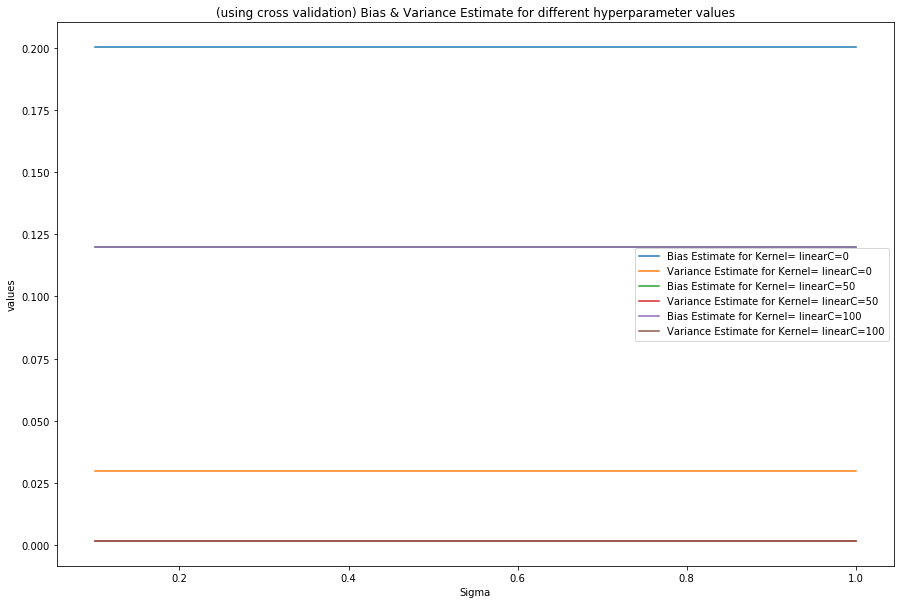

In [154]:
num_folds = 3
classifier = a1
performCrossValidation(X1,Y1,num_folds,classifier,kernel,degree,sigma)

In [157]:
from sklearn.datasets import load_digits
digits = load_digits()
ran = np.random.rand(len(digits['data'])) < 0.8
train_X_data = digits['data'][ran]
train_Y_data = digits['target'][ran]
val_X_data = digits['data'][~ran]
val_Y_data = digits['target'][~ran]

In [ ]:
sklearn.metrics.pairwise.rbf_kernel(X, Y=None, gamma=None)

In [162]:
from sklearn.datasets import load_digits
data1 = load_digits()
GivenData = dimensionality_reduction(data1['data'],data1['target'])
ran = np.random.rand(len(Givendata['data'])) < 0.8
train_X_data = Givendata['data'][ran]
train_Y_data = Givendata['target'][ran]
val_X_data = Givendata['data'][~ran]
val_Y_data = Givendata['target'][~ran]
kernel = 'rbf'
degree = 4
sigma = 0.4
C = 10
a1 = SMCSVM()
#a1.fit()
start_time = time.time()
a1.fit(train_X_data,train_Y_data,C,kernel,degree,sigma)
print('\n Time taken for training in seconds: ', time.time()-start_time )
predictedLabels = a1.predict(train_X_data)
conMatrix = pd.crosstab(np.array(predictedLabels).ravel(),train_Y_data.reshape(-1,1).ravel())
conMatrix

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in true_divide
  """


LinAlgError: Array must not contain infs or NaNs

In [164]:
np.exp(1)

2.718281828459045